# Capstone Edgar Allan Poe, Mary Shelley, HP Lovecraft Model

The goal of this workbook is to build a model that will predict the author based on the text of Edgar Allan Poe, Mary Shelley, and HP Lovecraft>

In [515]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.metrics
from sklearn.metrics import log_loss

Importing data into workbook

In [516]:
train = pd.read_csv('./Data/train.csv')

In [517]:
pred = pd.read_csv('./Data/test.csv')

In [518]:
import re

In [519]:
y = pd.Series(train['author'])
y.value_counts()/len(y)

EAP    0.403494
MWS    0.308698
HPL    0.287808
Name: author, dtype: float64

Making graph (background used that would show up on a black powerpoint slide

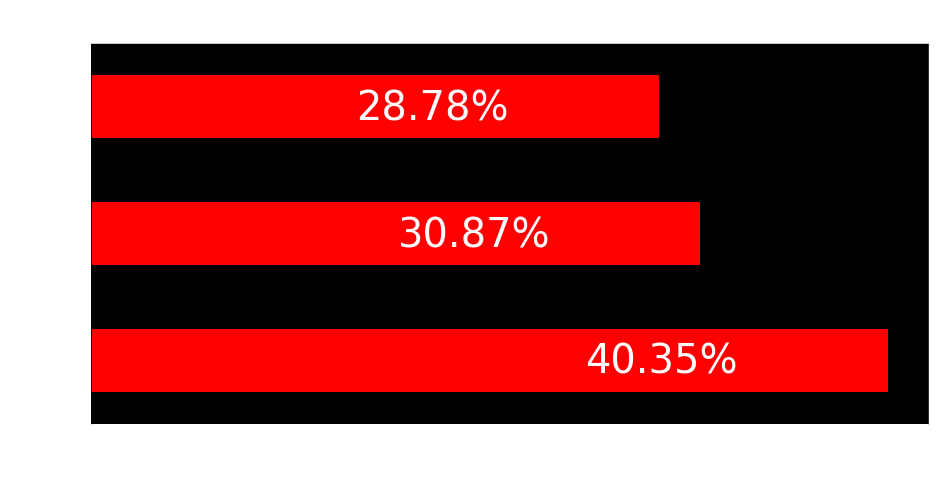

In [520]:
ax = y.value_counts().plot(kind='barh', figsize=(15,7),
                                        color="red", fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Authors in Data", fontsize=40, color = 'white')
ax.set_facecolor('black')
ax.set_xlabel("Number of Sentences from author", fontsize=40, color = 'white')
ax.set_ylabel("Author", fontsize=40, color = 'white');

ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')


# create a list to collect the plt.patches data
totals = []

# find the values for each author and set it to list
totals = list(y.value_counts().values)

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # for X find the posistion along horizontal axis, For y, find posistion along vertical axis, 
    # calculate percentage, Font size, color
    ax.text(i.get_width()-3000, i.get_y()+.15, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=40,
color='white')

------------------------------------------

# Feature Engineering

Word Count

(Get the word count from the sentence, standardaized after)

In [521]:
import re

In [522]:
def word_count(text):
    #remove punctuation and lowercase
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.split() 
    return len(text)

In [523]:
words = []
for i in range(len(train['text'])):
    word = word_count(train['text'][i])
    words.append(word)
train['Word Count'] = words

In [524]:
words = []
for i in range(len(pred['text'])):
    word = word_count(pred['text'][i])
    words.append(word)
pred['Word Count'] = words

-----------------------------------------------

Ends with Question Mark

(dummy variable)

In [525]:
def find_question(q):
    if q[-1] == '?':
        return 1
    #If the scentence ends with a quotation mark, this gets the question in diologue
    elif q[-1] == '"' and q[-2] == '?':
        return 1
    else:
        return 0

In [526]:
questions = []
for i in range(len(train['text'])):
    question = find_question(train['text'][i])
    questions.append(question)
train['Question'] = questions

In [527]:
questions = []
for i in range(len(pred['text'])):
    question = find_question(pred['text'][i])
    questions.append(question)
pred['Question'] = questions

----------------------------------

Highest syllable word

In [528]:
import pronouncing

In [529]:
def find_syllable(text):
    #remove punctuation and lowercase
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.split()
    phones = []
    for i in range(len(text)):
        #skips names and non-english words
        try:
            phone = pronouncing.phones_for_word(text[i])[0]
            phones.append(phone)
        except IndexError:
            pass
    #sets sentences with no recongizable words (like one in latin) to 0
    try:
        d = max([pronouncing.syllable_count(p) for p in phones])
    except ValueError:
        d = 0
    return d

In [530]:
syllables = []
for i in range(len(train['text'])):
    syllable = find_syllable(train['text'][i])
    syllables.append(syllable)
train['Syllables'] = syllables

In [531]:
syllables = []
for i in range(len(pred['text'])):
    syllable = find_syllable(pred['text'][i])
    syllables.append(syllable)
pred['Syllables'] = syllables

--------------------------------------------------

Parts of speech

Using nltk, extract different parts of speech. Then normalize it by making it the faction of words in the scentence

In [532]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('treebank')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jmvail\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jmvail\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\jmvail\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\jmvail\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\jmvail\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

In [533]:
def determine_parts_speech(sentance):
    text = nltk.word_tokenize(sentance)
    tagged = nltk.pos_tag(text)
    
    speech = {}
    speech["noun"] = len([word for word in tagged if word[1] in ["NN", "NNS","NNP", "NNPS"]]) #codes denote nouns
    speech["adverb"] = len([word for word in tagged if word[1] in ["RB", "RBR","RBS"]]) #codes denote adverbs
    speech["adjective"] = len([word for word in tagged if word[1] in ["JJ", "JJR","JJS"]]) #codes denote adjetive
    speech["future"] = len([word for word in tagged if word[1] == "MD"]) #codes denote future verbs
    speech["present"] = len([word for word in tagged if word[1] in ["VBP", "VBZ","VBG"]]) #codes denote present verbs
    speech["past"] = len([word for word in tagged if word[1] in ["VBD", "VBN"]]) #codes denote past
    
    return(speech)

In [534]:
nouns = []
adverbs = []
adjectives = []
futures = []
presents = []
pasts = []
for i in range(len(train['text'])):
    parts = determine_parts_speech(train['text'][i])
    nouns.append(parts['noun'])
    adverbs.append(parts['adverb'])
    adjectives.append(parts['adjective'])
    futures.append(parts['future'])
    presents.append(parts['present'])
    pasts.append(parts['past'])    
    
train['Noun Count'] = nouns
train['Adverb Count'] = adverbs
train['Adjectives Count'] = adjectives
train['Future Count'] = futures
train['Present Count'] = presents
train['Past Count'] = pasts


In [535]:
nouns = []
adverbs = []
adjectives = []
futures = []
presents = []
pasts = []
for i in range(len(pred['text'])):
    parts = determine_parts_speech(pred['text'][i])
    nouns.append(parts['noun'])
    adverbs.append(parts['adverb'])
    adjectives.append(parts['adjective'])
    futures.append(parts['future'])
    presents.append(parts['present'])
    pasts.append(parts['past'])    
    
pred['Noun Count'] = nouns
pred['Adverb Count'] = adverbs
pred['Adjectives Count'] = adjectives
pred['Future Count'] = futures
pred['Present Count'] = presents
pred['Past Count'] = pasts

In [536]:
train['Noun Fraction'] = train["Noun Count"] / train["Word Count"]
train['Adverb Fraction'] = train["Adverb Count"] / train["Word Count"]
train['Adjectives Fraction'] = train["Adjectives Count"] / train["Word Count"]
train['Future Fraction'] = train["Future Count"] / train["Word Count"]
train['Present Fraction'] = train["Present Count"] / train["Word Count"]
train['Past Fraction'] = train["Past Count"] / train["Word Count"]

In [537]:
pred['Noun Fraction'] = pred["Noun Count"] / pred["Word Count"]
pred['Adverb Fraction'] = pred["Adverb Count"] / pred["Word Count"]
pred['Adjectives Fraction'] = pred["Adjectives Count"] / pred["Word Count"]
pred['Future Fraction'] = pred["Future Count"] / pred["Word Count"]
pred['Present Fraction'] = pred["Present Count"] / pred["Word Count"]
pred['Past Fraction'] = pred["Past Count"] / pred["Word Count"]

Sentimant Analysis

In [538]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jmvail\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [539]:
sid = SentimentIntensityAnalyzer()

In [540]:
compounds = []
for i in range(len(train['text'])):
    comp = sid.polarity_scores(train['text'][i])['compound']
    compounds.append(comp)
train['Sentiment'] = compounds

In [541]:
compounds = []
for i in range(len(pred['text'])):
    comp = sid.polarity_scores(pred['text'][i])['compound']
    compounds.append(comp)
pred['Sentiment'] = compounds

Processed text

(processing the text after the feature enginneering and before the tokenizing is done)

In [542]:
train['processed'] = train['text'].apply(lambda x: re.sub(r'[^\w\s]','', x.lower()))

In [543]:
pred['processed'] = pred['text'].apply(lambda x: re.sub(r'[^\w\s]','', x.lower()))

In [544]:
train = train.drop(['id', 'text', 'Noun Count', 'Adverb Count', 'Adjectives Count', 'Future Count', 'Present Count', 'Past Count'], axis=1)

In [545]:
pred_id = pred['id']

In [546]:
pred = pred.drop(['id', 'text', 'Noun Count', 'Adverb Count', 'Adjectives Count', 'Future Count', 'Present Count', 'Past Count'], axis=1)

In [547]:
train.head()

,author,Word Count,Question,Syllables,Noun Fraction,Adverb Fraction,Adjectives Fraction,Future Fraction,Present Fraction,Past Fraction,Sentiment,processed
0,EAP,41,0,4,0.243902,0.073171,0.048780,0.024390,0.073171,0.048780,0.6329,this process however afforded me no means of a...
1,HPL,14,0,3,0.142857,0.142857,0.071429,0.071429,0.000000,0.071429,-0.3400,it never once occurred to me that the fumbling...
2,EAP,36,0,4,0.277778,0.027778,0.138889,0.000000,0.027778,0.083333,0.9246,in his left hand was a gold snuff box from whi...
3,MWS,34,0,3,0.294118,0.029412,0.176471,0.000000,0.058824,0.088235,0.9460,how lovely is spring as we looked from windsor...
4,HPL,27,0,5,0.259259,0.148148,0.037037,0.000000,0.148148,0.037037,-0.8385,finding nothing else not even gold the superin...


Past Tense (Not used)

This and "Present tense was not used as everything turned out to be past tense. This was a more sophisticated version of detecting parts of speech that looked at if the verb was inside of a participle phase or other part of speech. Using this, one could find if the scentence was in the past or present tense.

In [548]:
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk import conlltags2tree, tree2conlltags

In [549]:
grammar = r"""
  NP:
    {<.*>+}          # Chunk everything
    }<VBD|IN>+{      # Chink sequences of VBD and IN
  """

In [550]:
cp = nltk.RegexpParser(grammar)

In [551]:
def past_tense(sentence):
    tokens = nltk.word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    iob_tags = tree2conlltags(cp.parse(tagged))
    pasts = 0
    new_tagged = []
    for i in range(len(iob_tags)):
        if iob_tags[i][1] in ["VBD", "VBN"] and iob_tags[i][2] == 'O':
            pasts += 1
    return pasts

Present Tense (Not Used

In [552]:
def present_tense(sentence):
    tokens = nltk.word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    iob_tags = tree2conlltags(cp.parse(tagged))
    presents = 0
    for i in range(len(tagged)):
        if iob_tags[i][1] in ["VBP", "VBZ","VBG"] and iob_tags[i][2] == 'O':
            presents += 1
    return presents

--------------------------------------------------

Train Test Split

In [553]:
X = train.drop(['author'], axis = 1)

In [554]:
y = train['author']

In [555]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [556]:
y_train = y_train.reset_index().drop('index', axis =1)
X_train = X_train.reset_index().drop('index', axis =1)
y_test = y_test.reset_index().drop('index', axis =1)
X_test = X_test.reset_index().drop('index', axis =1)

Scaling Word Count and Syllables manually before modeling is done

In [557]:
scaler = MinMaxScaler()

In [558]:
train_word = X_train['Word Count'].values.astype(float).reshape(-1, 1)
test_word = X_test['Word Count'].values.astype(float).reshape(-1, 1)
pred_word = pred['Word Count'].values.astype(float).reshape(-1, 1)

In [559]:
scaled_train_word = scaler.fit_transform(train_word)
scaled_test_word = scaler.transform(test_word)
scaled_pred_word = scaler.transform(pred_word)

In [560]:
train_word_df = pd.DataFrame(scaled_train_word)
test_word_df = pd.DataFrame(scaled_test_word)
test_pred_df = pd.DataFrame(scaled_pred_word)

In [561]:
X_train['Word Count'] = train_word_df
X_test['Word Count'] = test_word_df
pred['Word Count'] = test_pred_df

In [562]:
train_Syllables = X_train['Syllables'].values.astype(float).reshape(-1, 1)
test_Syllables = X_test['Syllables'].values.astype(float).reshape(-1, 1)
pred_Syllables = pred['Syllables'].values.astype(float).reshape(-1, 1)

In [563]:
scaled_train_Syllables = scaler.fit_transform(train_Syllables)
scaled_test_Syllables = scaler.transform(test_Syllables)
scaled_pred_Syllables = scaler.transform(pred_Syllables)

In [564]:
train_Syllables_df = pd.DataFrame(scaled_train_Syllables)
test_Syllables_df = pd.DataFrame(scaled_test_Syllables)
pred_Syllables_df = pd.DataFrame(scaled_pred_Syllables)

In [565]:
X_train['Syllables'] = train_Syllables_df
X_test['Syllables'] = test_Syllables_df
pred['Syllables'] = pred_Syllables_df

Creating 3 Kmeans clusters for the features

In [566]:
from sklearn.cluster import KMeans, k_means

In [567]:
kmeans = KMeans(n_clusters=3)
model = kmeans.fit(X_train.drop(['processed'], axis =1))

In [568]:
X_train['clusters'] = model.labels_

In [569]:
X_train['cluster_1'] = pd.get_dummies(X_train['clusters'], prefix='cluster', drop_first=True)['cluster_1']
X_train['cluster_2'] = pd.get_dummies(X_train['clusters'], prefix='cluster', drop_first=True)['cluster_2']
X_train.drop(['clusters'], axis = 1, inplace=True)

In [570]:
X_test['clusters'] = model.predict(X_test.drop(['processed'], axis =1))
X_test['cluster_1'] = pd.get_dummies(X_test['clusters'], prefix='cluster', drop_first=True)['cluster_1']
X_test['cluster_2'] = pd.get_dummies(X_test['clusters'], prefix='cluster', drop_first=True)['cluster_2']
X_test.drop(['clusters'], axis = 1, inplace=True)

In [571]:
pred['clusters'] = model.predict(pred.drop(['processed'], axis =1))
pred['cluster_1'] = pd.get_dummies(pred['clusters'], prefix='cluster', drop_first=True)['cluster_1']
pred['cluster_2'] = pd.get_dummies(pred['clusters'], prefix='cluster', drop_first=True)['cluster_2']
pred.drop(['clusters'], axis = 1, inplace=True)

In [572]:
X_train.head()

,Word Count,Question,Syllables,Noun Fraction,Adverb Fraction,Adjectives Fraction,Future Fraction,Present Fraction,Past Fraction,Sentiment,processed,cluster_1,cluster_2
0,0.018626,0,0.571429,0.166667,0.055556,0.111111,0.000000,0.055556,0.222222,0.0000,i was galled too by the rumor touching a relat...,0,0
1,0.032596,0,0.571429,0.233333,0.033333,0.000000,0.033333,0.033333,0.133333,0.6249,brooding over this plan resolved when the hour...,1,0
2,0.031432,0,0.571429,0.241379,0.068966,0.034483,0.034483,0.000000,0.034483,-0.8811,but as jermyn indulged in these reflections he...,0,1
3,0.006985,0,0.428571,0.250000,0.000000,0.125000,0.000000,0.250000,0.125000,-0.7096,tragedies deep and dire were the chief favourites,0,1
4,0.033760,0,0.571429,0.322581,0.000000,0.064516,0.032258,0.000000,0.129032,0.5267,but for one thing old bugs would have been an ...,1,0


The order affected the ability for the Feature Unions to work correctly. Reason is unknow. Put processed text in the back of the panda dataframes

In [573]:
X_train.columns.tolist()

['Word Count',
 'Question',
 'Syllables',
 'Noun Fraction',
 'Adverb Fraction',
 'Adjectives Fraction',
 'Future Fraction',
 'Present Fraction',
 'Past Fraction',
 'Sentiment',
 'processed',
 'cluster_1',
 'cluster_2']

In [574]:
X_train=X_train[['Word Count',
 'Question',
 'Syllables',
 'Noun Fraction',
 'Adverb Fraction',
 'Adjectives Fraction',
 'Future Fraction',
 'Present Fraction',
 'Past Fraction',
 'Sentiment',
 'cluster_1',
 'cluster_2',
'processed']]

In [575]:
X_test=X_test[['Word Count',
 'Question',
 'Syllables',
 'Noun Fraction',
 'Adverb Fraction',
 'Adjectives Fraction',
 'Future Fraction',
 'Present Fraction',
 'Past Fraction',
 'Sentiment',
 'cluster_1',
 'cluster_2',
'processed']]

In [576]:
pred=pred[['Word Count',
 'Question',
 'Syllables',
 'Noun Fraction',
 'Adverb Fraction',
 'Adjectives Fraction',
 'Future Fraction',
 'Present Fraction',
 'Past Fraction',
 'Sentiment',
 'cluster_1',
 'cluster_2',
'processed']]

In [577]:
#X_train_p = X_train['processed']
#X_test_p = X_test['processed']
#pred_p = pred['processed']

# Basic CountVectorize

Basic model with only text

In [578]:
# Lets use the stop_words argument to remove words like "and, the, a"
cvec = CountVectorizer(stop_words='english')

# Fit our vectorizer using our train data
cvec.fit(X_train['processed'])

# and check out the length of the vectorized data after
len(cvec.get_feature_names())

21690

In [579]:
X_train_tran = pd.DataFrame(cvec.transform(X_train['processed']).todense(),
                       columns=cvec.get_feature_names())
X_test_tran = pd.DataFrame(cvec.transform(X_test['processed']).todense(),
                      columns=cvec.get_feature_names())

In [580]:
X_train_tran.head()

,aback,abaft,abandon,abandoned,abandoning,abandonment,abaout,abasement,abashed,abate,...,ædiles,ægyptus,æmilianus,æneid,ærial,æronaut,æronauts,élite,οἶδα,υπνος
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [581]:
names = ['EAP', 'HPL', 'MWS']
names

['EAP', 'HPL', 'MWS']

20 most used words for all authors

In [582]:
word_counts = X_train_tran.sum(axis=0)
word_counts.sort_values(ascending = False).head(20)

time       528
man        521
said       518
did        499
old        440
like       417
night      390
life       382
eyes       364
saw        362
little     361
great      356
long       353
day        349
thought    317
came       315
say        281
far        275
years      265
mind       264
dtype: int64

In [583]:
np.asarray(y_train==names[0])

array([[ True],
       [False],
       [False],
       ...,
       [False],
       [ True],
       [False]])

20 most used words for each author

In [584]:
common_words = []
for i in range(3):
    word_count = X_train_tran[np.asarray(y_train==names[i])].sum(axis=0)
    print(names[i], "most common words")
    cw = word_count.sort_values(ascending = False).head(20)
    print(cw)
    common_words.extend(cw.index)
    print()

EAP most common words
said       277
little     184
time       184
say        181
man        177
great      167
long       145
did        145
day        133
having     126
length     123
mr         119
far        118
thought    117
head       116
eyes       111
night      106
like       105
just       102
matter     102
dtype: int64

HPL most common words
old        289
did        195
like       189
man        180
time       169
things     165
night      165
saw        162
came       149
men        147
great      134
thing      134
house      125
strange    119
heard      117
long       113
street     107
room       106
knew       105
place      105
dtype: int64

MWS most common words
life       225
time       175
heart      173
love       172
raymond    171
man        164
eyes       164
did        159
said       141
death      136
day        128
shall      124
father     123
like       123
night      119
saw        115
mind       115
perdita    105
thought    102
hope        96
dtype:

# Logistic Regression

In [585]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_tran, y_train)
print(lr.score(X_train_tran, y_train))
print(lr.score(X_test_tran, y_test))

C:\Users\jmvail\Anaconda3\envs\dsi\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9672382342210872
0.7897514470548178


In [586]:
pred_tran = pd.DataFrame(cvec.transform(pred['processed']).todense(),
                      columns=cvec.get_feature_names())

In [587]:
y_hat = lr.predict_proba(pred_tran)

In [588]:
y_hat_2 =lr.predict(X_test_tran)

In [589]:
predition = lr.predict_proba(X_train_tran)

In [590]:
from sklearn.metrics import log_loss

In [591]:
log_loss(y_train, predition)

0.24246421793682052

In [592]:
predition = lr.predict_proba(X_test_tran)

In [593]:
log_loss(y_test, predition)

0.5238823136917913

In [594]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier

# Random Forest

In [595]:
rf = RandomForestClassifier()
rf.fit(X_train_tran, y_train)
print(rf.score(X_train_tran, y_train))
print(rf.score(X_test_tran, y_test))

C:\Users\jmvail\Anaconda3\envs\dsi\lib\site-packages\ipykernel\__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


0.9865012769062386
0.6470888661899897


In [596]:
predition = rf.predict_proba(X_train_tran)
log_loss(y_train, predition)

0.20497275633184228

In [597]:
predition = rf.predict_proba(X_test_tran)
log_loss(y_test, predition)

1.4192165250290585

# Ada Boosting

In [598]:
ada = AdaBoostClassifier()
ada.fit(X_train_tran, y_train)
print(ada.score(X_train_tran, y_train))
print(ada.score(X_test_tran, y_test))

C:\Users\jmvail\Anaconda3\envs\dsi\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5609631521342576
0.562648961525366


In [599]:
predition = ada.predict_proba(X_train_tran)
log_loss(y_train, predition)

1.0674502243149373

In [600]:
predition = ada.predict_proba(X_test_tran)
log_loss(y_test, predition)

1.0688023475555646

In [602]:
lr_bag = pd.DataFrame(y_hat, index = pred_id)
lr_bag.columns = ['EAP', 'HPL', 'MWS']
lr_bag.head()

,EAP,HPL,MWS
id,,,
id02310,0.120208,0.063151,0.816641
id24541,0.700813,0.288883,0.010304
id00134,0.321743,0.658562,0.019695
id27757,0.857793,0.116108,0.026099
id04081,0.791340,0.125203,0.083456


In [603]:
#lr_bag.to_csv("./lr_bag.csv")

Model evaluations

Logistic Regression
- Some overfitting, but overall good performance

Random Forest
- Major overfitting with little in good performace

AdaBoosting
- Little overfitting, but not good performace

# Feature Union

In [604]:
from sklearn.metrics import log_loss

In [605]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion

# Feature Union 1 (Unused)

Did not use this method as I could not get the feature importances out of the pipeline

In [606]:
class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [607]:
processed = Pipeline([
                ('selector', TextSelector(key='processed')),
                ('tfid', TfidfVectorizer(stop_words='english'))
            ])
word_count =  Pipeline([
                ('selector', NumberSelector(key='Word Count')),
                ('standard', StandardScaler())
            ])
question =  Pipeline([
                ('selector', NumberSelector(key='Question')),
                ('standard', StandardScaler())
            ])
syllables =  Pipeline([
                ('selector', NumberSelector(key='Syllables')),
                ('standard', StandardScaler())
            ])
noun_fraction =  Pipeline([
                ('selector', NumberSelector(key='Noun Fraction')),
                ('standard', StandardScaler()),
            ])
adverb_fraction =  Pipeline([
                ('selector', NumberSelector(key='Adverb Fraction')),
                ('standard', StandardScaler()),
            ])
adjectives_fraction =  Pipeline([
                ('selector', NumberSelector(key='Adjectives Fraction')),
                ('standard', StandardScaler()),
            ])
future_fraction =  Pipeline([
                ('selector', NumberSelector(key='Future Fraction')),
                ('standard', StandardScaler()),
            ])
present_fraction =  Pipeline([
                ('selector', NumberSelector(key='Present Fraction')),
                ('standard', StandardScaler()),
            ])
past_fraction =  Pipeline([
                ('selector', NumberSelector(key='Past Fraction')),
                ('standard', StandardScaler()),
            ])

In [608]:
feats_1 = FeatureUnion([('processed', processed), 
                      ('word_count', word_count),
                      ('question', question),
                      ('syllables', syllables),
                      ('noun_fraction', noun_fraction),
                      ('adverb_fraction', adverb_fraction),
                      ('adjectives_fraction', adjectives_fraction),
                      ('future_fraction', future_fraction),
                      ('present_fraction', present_fraction),
                      ('past_fraction', past_fraction)])

feature_processing = Pipeline([('feats', feats_1)])
feature_processing.fit_transform(X_train)

<13705x21699 sparse matrix of type '<class 'numpy.float64'>'
	with 278056 stored elements in Compressed Sparse Row format>

# Differant approach (one I used)

In [609]:
class DfExtract(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if len(self.column) > 1:
            return pd.DataFrame(X[self.column])
        else:
            return pd.Series(X[self.column[0]]) 
    def get_feature_names(self):
        return X.columns.tolist()

In [610]:
col_names = X_train.columns.tolist()

In [611]:
col_names

['Word Count',
 'Question',
 'Syllables',
 'Noun Fraction',
 'Adverb Fraction',
 'Adjectives Fraction',
 'Future Fraction',
 'Present Fraction',
 'Past Fraction',
 'Sentiment',
 'cluster_1',
 'cluster_2',
 'processed']

In [612]:
text_pipe = Pipeline([
    ('ext', DfExtract(['processed'])),
    ('tf', TfidfVectorizer(stop_words='english', max_df=.75, norm= 'l2'))])

numerical_pipe= Pipeline([
    ('ext', DfExtract(col_names[:-1]))
])


In [613]:
feats = FeatureUnion([
    ('text_pipe', text_pipe),
    ('numerical_pipe', numerical_pipe)
])

feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(X_train)

<13705x21702 sparse matrix of type '<class 'numpy.float64'>'
	with 258294 stored elements in Compressed Sparse Row format>

In [614]:
feature_names = text_pipe.fit(X_train, y_train).steps[1][1].get_feature_names()
feature_names.extend(col_names[:-1])

# Pipeline Logistic Regression

After tuning, the following parameters were found to be the most optimal for Logistic Regression

In [615]:
#{'classifier__C': 3,
# 'classifier__tol': 0.1,
# 'features__text_pipe__tf__max_df': 0.75,
# 'features__text_pipe__tf__max_features': None,
# 'features__text_pipe__tf__norm': 'l2'}

In [616]:
from sklearn.linear_model import LogisticRegression

In [617]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(multi_class='multinomial', 
                                      solver='newton-cg', 
                                      penalty = 'l2',
                                     C= 3,
                                     tol = 0.1))
])

pipeline.fit(X_train, y_train)

C:\Users\jmvail\Anaconda3\envs\dsi\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text_pipe', Pipeline(memory=None,
     steps=[('ext', DfExtract(column=['processed'])), ('tf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='con...nalty='l2', random_state=None, solver='newton-cg',
          tol=0.1, verbose=0, warm_start=False))])

Accruacy Scores

In [618]:
pipeline.score(X_train, y_train)

0.9755563662896753

In [619]:
pipeline.score(X_test, y_test)

0.7950289410963568

Log Loss Scores

In [620]:
predition = pipeline.predict_proba(X_train)
log_loss(y_train, predition)

0.2629825327168154

In [621]:
predition = pipeline.predict_proba(X_test)
log_loss(y_test, predition)

0.5219409407135436

# Build Confusion Matrix

In [622]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

In [623]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [624]:
def plot_confusion_matrix_white(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, color = 'white')
    
    color_bar = plt.colorbar()                            
    plt.setp(plt.getp(color_bar.ax.axes, 'yticklabels'), color='w') 
      
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, color='white')
    plt.yticks(tick_marks, classes, color='white')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', color = 'white')
    plt.xlabel('Predicted label', color = 'white')

In [625]:
y_predition = pipeline.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_predition)
np.set_printoptions(precision=2)

Confusion Matrix with white text to be used for powerpoint

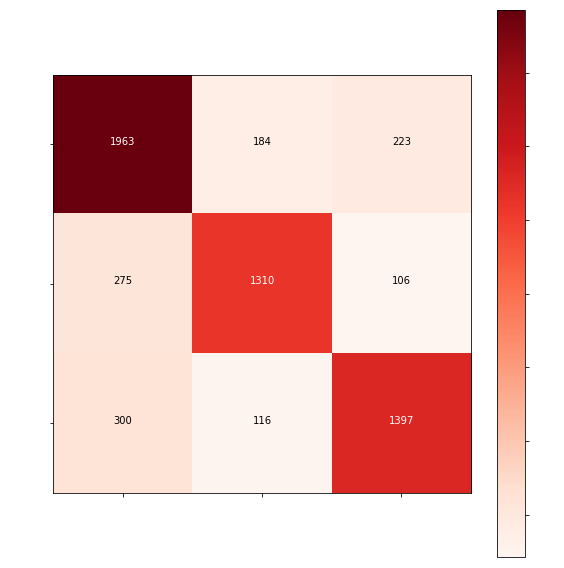

In [626]:
plt.figure(figsize=(8,8))
plot_confusion_matrix_white(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of LR')
plt.show()

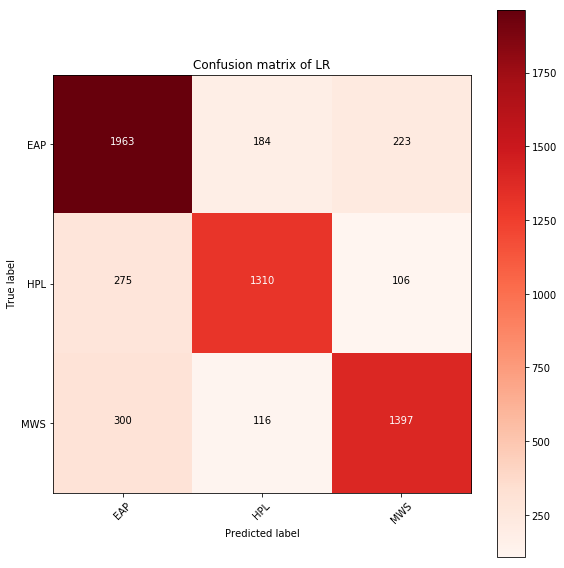

In [627]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of LR')
plt.show()

---------------------------------

# Feature Importance

Grabbing feature impirtance from the pipeline

In [628]:
coef = pd.DataFrame(feature_names, pipeline.steps[1][1].coef_.tolist()[0], columns=['Feature'])
coef['abs'] = abs(coef.index)
coef['coef']= coef.index
coef = coef.sort_values(['abs'], ascending=False).head(25)

In [629]:
coef

,Feature,abs,coef
-3.915737,raymond,3.915737,-3.915737
-3.259466,men,3.259466,-3.259466
3.061309,minutes,3.061309,3.061309
3.048395,ordinary,3.048395,3.048395
3.038251,dupin,3.038251,3.038251
-2.935533,till,2.935533,-2.935533
2.867803,character,2.867803,2.867803
2.814417,portion,2.814417,2.814417
-2.762448,perdita,2.762448,-2.762448
2.760111,lady,2.760111,2.760111


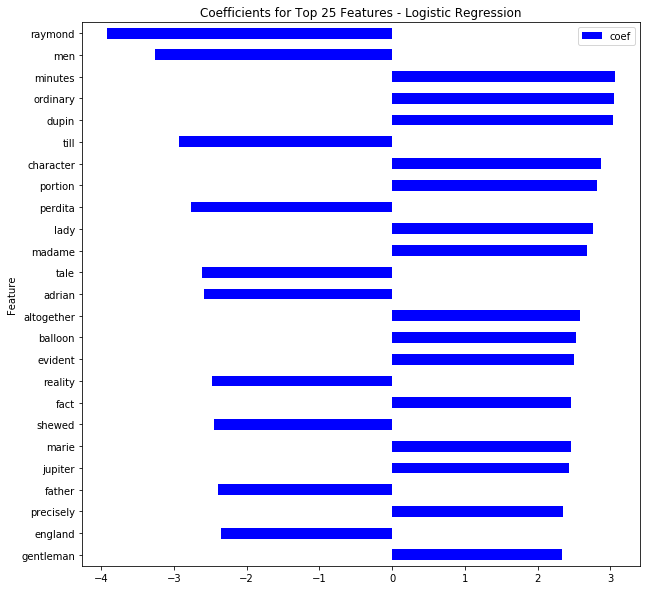

In [630]:
coef.sort_values(by='abs').plot(y='coef',x='Feature',kind='barh', figsize=(10,10), color='b', 
                                  title='Coefficients for Top 25 Features - Logistic Regression');

Will be used for Powerpoint

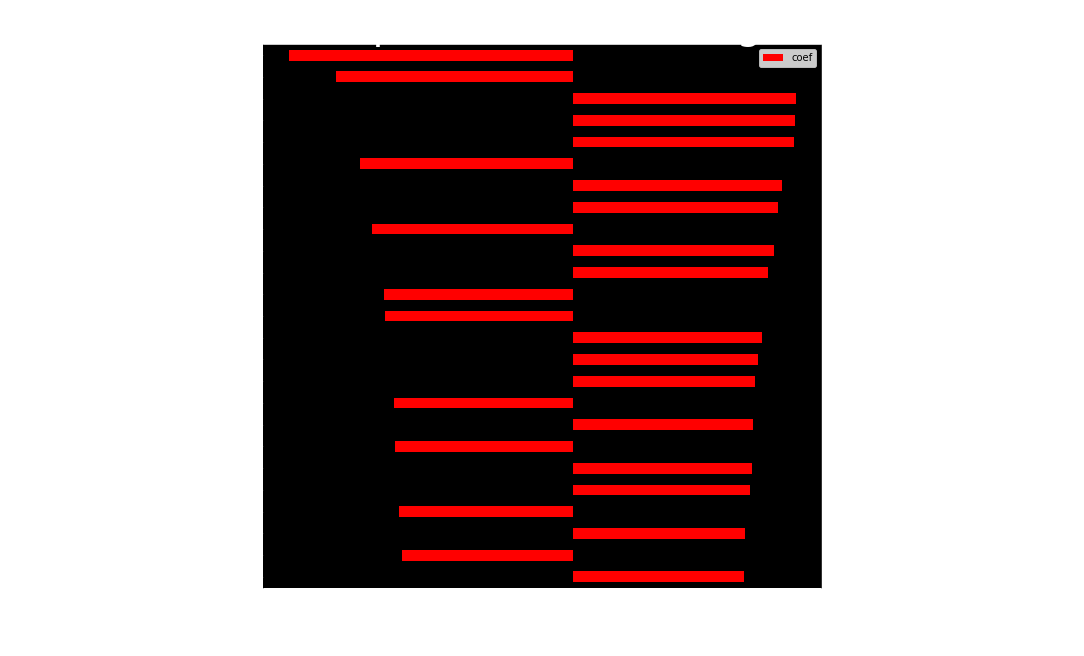

In [632]:
ax = coef.sort_values(by='abs').plot(y='coef',x='Feature',kind='barh', figsize=(10,10), color='r')
ax.set_alpha(0.8)
ax.set_title("Coefficients for Top 25 Features - Logistic Regression", fontsize=40, color = 'white')
ax.set_facecolor('black')
ax.set_xlabel("Coefficient", fontsize=40, color = 'white')
ax.set_ylabel("Top Features", fontsize=40, color = 'white');

ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

In [633]:
y_hat = pipeline.predict_proba(pred)

In [634]:
lr_bag = pd.DataFrame(y_hat, index = pred_id)
lr_bag.columns = ['EAP', 'HPL', 'MWS']
lr_bag.head()

,EAP,HPL,MWS
id,,,
id02310,0.135149,0.097103,0.767747
id24541,0.625879,0.292246,0.081875
id00134,0.389342,0.542728,0.067930
id27757,0.733235,0.197722,0.069043
id04081,0.838558,0.095857,0.065585


In [636]:
lr_bag.to_csv("./pipeline_5.csv")

# Gridsearch

Used following gridseach to tune model. commented it out to make running page faster. Can be uncommented if further tunning needed

In [637]:
#pipeline.get_params().keys()

In [638]:
#from sklearn.model_selection import GridSearchCV

#hyperparameters = { #'features__text_pipe__tf__sublinear_tf': [True, False],
                    #'features__text_pipe__tf__smooth_idf' : [True, False],
#                    'features__text_pipe__tf__norm' : ['l1', 'l2'],
                    #'features__text_pipe__tf__binary' : [True, False],
#                    'features__text_pipe__tf__max_df' : [1, 0.75],
#                   'features__text_pipe__tf__max_features': [None, 2000, 5000],
#                    'classifier__tol': [.001, .01, .1],
#                   'classifier__C' : [0.75, 1, 2.5, 3]
#                  }
#clf = GridSearchCV(pipeline, hyperparameters, cv=5, scoring='neg_log_loss')
 
# Fit and tune model
#clf.fit(X_train, y_train)

In [639]:
#clf.best_params_

In [640]:
#clf.score(X_test, y_test)

In [641]:
#predition = clf.predict_proba(X_train)

In [642]:
#log_loss(y_train, predition)

In [643]:
#predition = clf.predict_proba(X_test)

In [644]:
#log_loss(y_test, predition)

In [645]:
#y_hat = pipeline.predict_proba(pred)

In [646]:
#lr_bag = pd.DataFrame(y_hat, index = pred_id)
#lr_bag.columns = ['EAP', 'HPL', 'MWS']
#lr_bag.head()

In [647]:
#lr_bag.to_csv("./pipeline_3.csv")

# Pipeline Randsom Forest

In [648]:
#{'classifier__max_depth': 100,
# 'classifier__n_estimators': 70,
# 'features__text_pipe__tf__max_df': 0.5,
# 'features__text_pipe__tf__max_features': 5000,
# 'features__text_pipe__tf__norm': 'l2'}

In [649]:
text_pipe = Pipeline([
    ('ext', DfExtract(['processed'])),
    ('tf', TfidfVectorizer(stop_words='english', max_df=.5, norm= 'l2', max_features=5000))])

numerical_pipe= Pipeline([
    ('ext', DfExtract(col_names[:-1]))
])


In [650]:
feats = FeatureUnion([
    ('text_pipe', text_pipe),
    ('numerical_pipe', numerical_pipe)
])

feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(X_train)

<13705x5012 sparse matrix of type '<class 'numpy.float64'>'
	with 224461 stored elements in Compressed Sparse Row format>

In [651]:
feature_names = text_pipe.fit(X_train, y_train).steps[1][1].get_feature_names()
feature_names.extend(col_names[:-1])

In [652]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(n_estimators=70, max_depth=100)),
])

pipeline.fit(X_train, y_train)

C:\Users\jmvail\Anaconda3\envs\dsi\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text_pipe', Pipeline(memory=None,
     steps=[('ext', DfExtract(column=['processed'])), ('tf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='con...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [653]:
pipeline.score(X_train, y_train)

0.9853338197738052

In [654]:
pipeline.score(X_test, y_test)

0.6467483827034389

In [655]:
y_predition = pipeline.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_predition)
np.set_printoptions(precision=2)

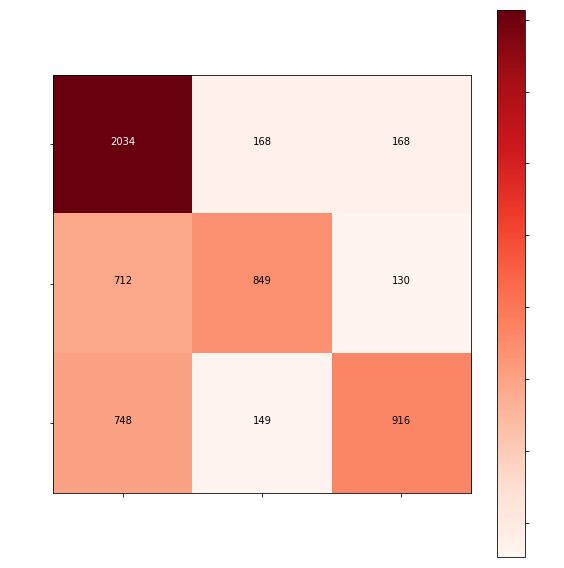

In [656]:
plt.figure(figsize=(8,8))
plot_confusion_matrix_white(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of RF')
plt.show()

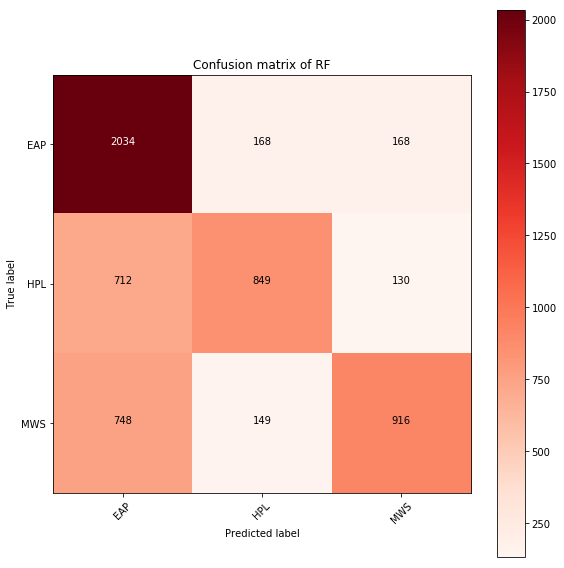

In [657]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of RF')
plt.show()

In [659]:
feature_impor = pd.DataFrame(feature_names, pipeline.steps[1][1].feature_importances_.tolist(), columns=['Feature'])
feature_impor['abs'] = abs(feature_impor.index)
feature_impor['coef']= feature_impor.index
feature_impor = feature_impor.sort_values(['abs'], ascending=False).head(25)

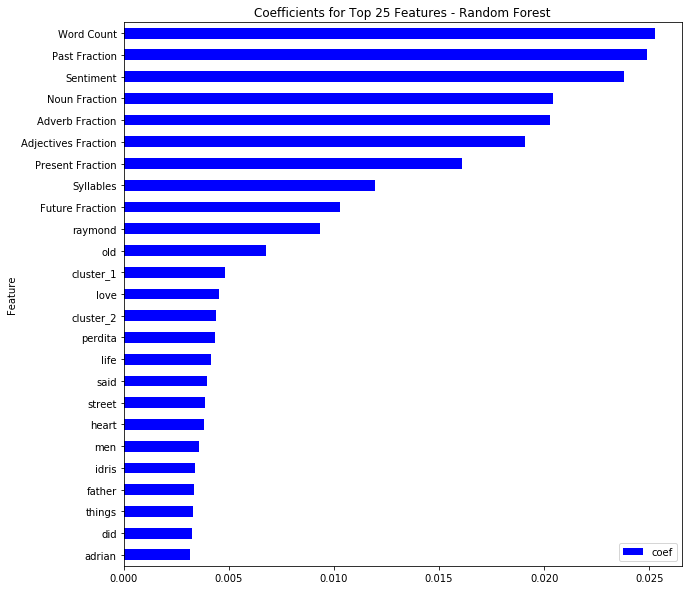

In [660]:
feature_impor.sort_values(by='abs').plot(y='coef',x='Feature',kind='barh', figsize=(10,10), color='b', 
                                  title='Coefficients for Top 25 Features - Random Forest');

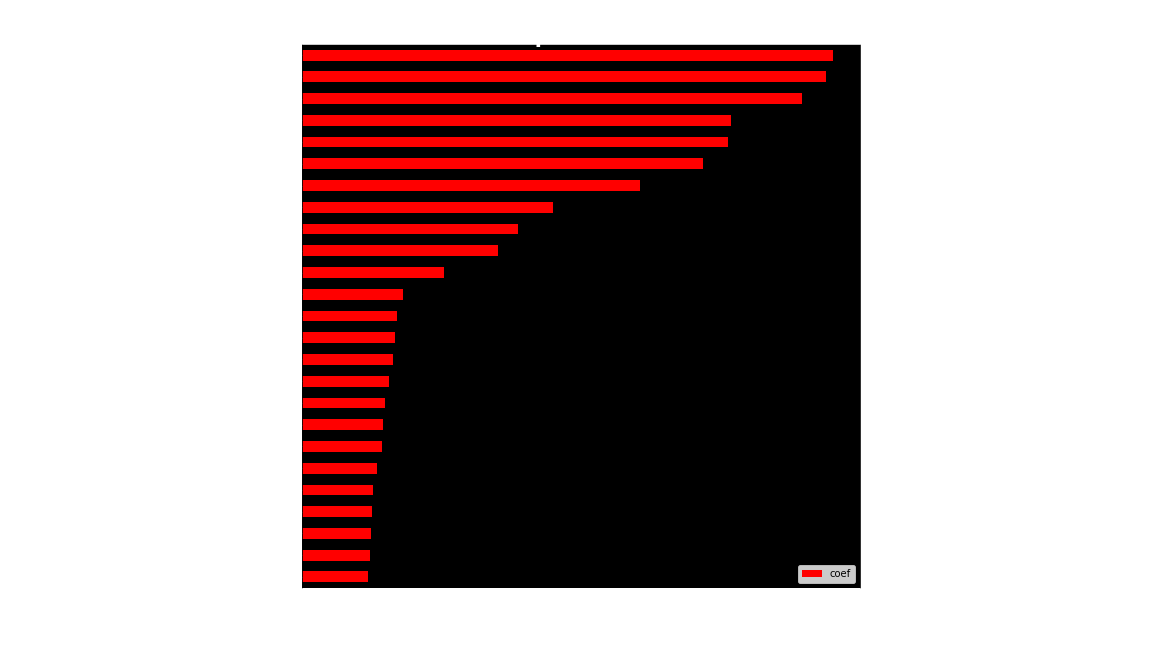

In [661]:
ax = feature_impor.sort_values(by='abs').plot(y='coef',x='Feature',kind='barh', figsize=(10,10), color='r')
ax.set_alpha(0.8)
ax.set_title("Feature Importance for Top 25 Features - Random Forest", fontsize=40, color = 'white')
ax.set_facecolor('black')
ax.set_xlabel("Coefficient", fontsize=40, color = 'white')
ax.set_ylabel("Top Features", fontsize=40, color = 'white');

ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Gridsearch

In [662]:
#hyperparameters = { #'features__text_pipe__tf__sublinear_tf': [True, False],
                    #'features__text_pipe__tf__smooth_idf' : [True, False],
#                    'features__text_pipe__tf__norm' : ['l1', 'l2'],
                    #'features__text_pipe__tf__binary' : [True, False],
#                    'features__text_pipe__tf__max_df' : [1, 0.75, 0.5],
#                   'features__text_pipe__tf__max_features': [None, 2000, 5000],
#                    'classifier__n_estimators': [50, 70, 90],
#                    'classifier__max_depth': [70, 90, 100]
#                  }
#clf = GridSearchCV(pipeline, hyperparameters, cv=5, scoring='neg_log_loss')
 
# Fit and tune model
#clf.fit(X_train, y_train)

In [663]:
#clf.best_params_

In [664]:
#clf.score(X_test, y_test)

In [665]:
#predition = clf.predict_proba(X_train)

In [666]:
#log_loss(y_train, predition)

In [667]:
#predition = clf.predict_proba(X_test)

In [668]:
#log_loss(y_test, predition)

# Pipeline AdaBoost

In [669]:
#{'classifier__algorithm': 'SAMME.R',
# 'classifier__learning_rate': 0.25,
# 'features__text_pipe__tf__max_df': 0.75,
# 'features__text_pipe__tf__max_features': 5000,
# 'features__text_pipe__tf__norm': 'l1'}

In [670]:
text_pipe = Pipeline([
    ('ext', DfExtract(['processed'])),
    ('tf', TfidfVectorizer(stop_words='english', max_df=.75, norm= 'l1', max_features=5000))])

numerical_pipe= Pipeline([
    ('ext', DfExtract(col_names[:-1]))
])


In [671]:
feats = FeatureUnion([
    ('text_pipe', text_pipe),
    ('numerical_pipe', numerical_pipe)
])

feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(X_train)

<13705x5012 sparse matrix of type '<class 'numpy.float64'>'
	with 224461 stored elements in Compressed Sparse Row format>

In [672]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', AdaBoostClassifier(algorithm='SAMME.R', learning_rate=.25)),
])

pipeline.fit(X_train, y_train)

C:\Users\jmvail\Anaconda3\envs\dsi\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text_pipe', Pipeline(memory=None,
     steps=[('ext', DfExtract(column=['processed'])), ('tf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='con...='SAMME.R', base_estimator=None,
          learning_rate=0.25, n_estimators=50, random_state=None))])

In [673]:
pipeline.score(X_train, y_train)

0.5358628237869391

In [674]:
pipeline.score(X_test, y_test)

0.5292815798433776

In [675]:
predition = pipeline.predict_proba(X_train)

In [676]:
log_loss(y_train, predition)

1.067149539595237

In [677]:
predition = pipeline.predict_proba(X_test)

In [678]:
log_loss(y_test, predition)

1.0684024090741016

In [679]:
y_predition = pipeline.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_predition)
np.set_printoptions(precision=2)

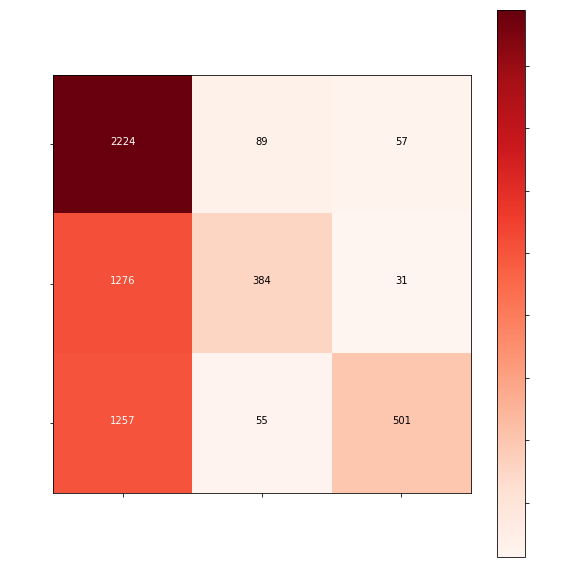

In [680]:
plt.figure(figsize=(8,8))
plot_confusion_matrix_white(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of LR')
plt.show()

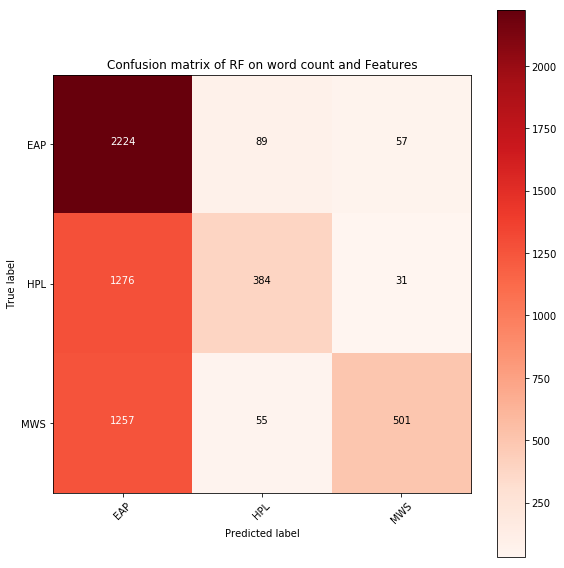

In [681]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of RF on word count and Features')
plt.show()

In [682]:
feature_impor = pd.DataFrame(feature_names, pipeline.steps[1][1].feature_importances_.tolist(), columns=['Feature'])
feature_impor['abs'] = abs(feature_impor.index)
feature_impor['coef']= feature_impor.index
feature_impor = feature_impor.sort_values(['abs'], ascending=False).head(25)

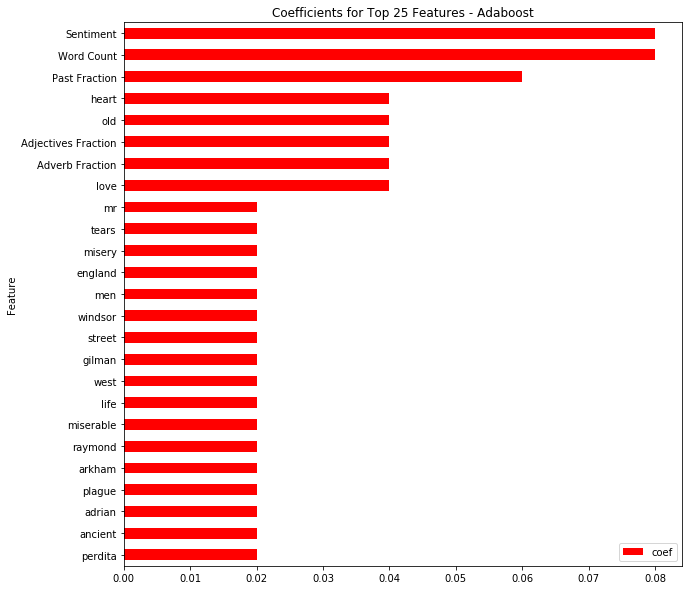

In [683]:
feature_impor.sort_values(by='abs').plot(y='coef',x='Feature',kind='barh', figsize=(10,10), color='r', 
                                  title='Coefficients for Top 25 Features - Adaboost');

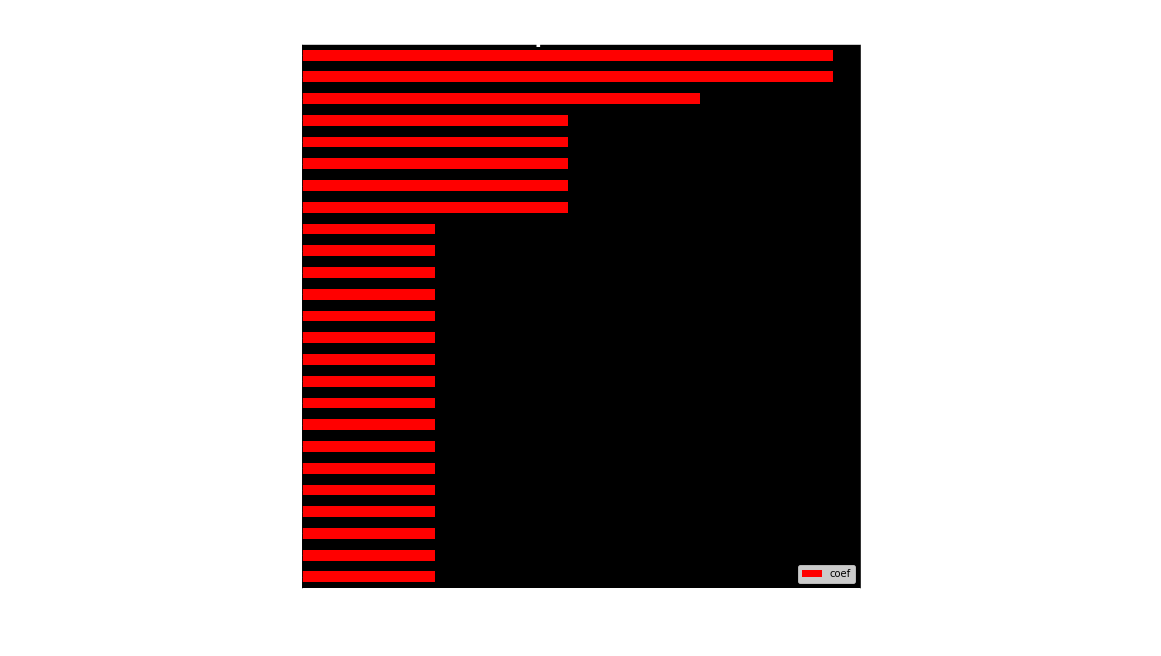

In [684]:
ax = feature_impor.sort_values(by='abs').plot(y='coef',x='Feature',kind='barh', figsize=(10,10), color='r')
ax.set_alpha(0.8)
ax.set_title("Feature Importance for Top 25 Features - Random Forest", fontsize=40, color = 'white')
ax.set_facecolor('black')
ax.set_xlabel("Coefficient", fontsize=40, color = 'white')
ax.set_ylabel("Top Features", fontsize=40, color = 'white');

ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Gridsearch

In [685]:
#hyperparameters = { 'features__text_pipe__tf__max_df' : [1, 0.75, 0.5],
#                   'features__text_pipe__tf__norm' : ['l1', 'l2'],
#                   'features__text_pipe__tf__max_features': [None, 2000, 5000],
                   #'features__processed__tfid__binary': [True, False],
                    #'classifier__base_estimator': [30, 50, 70],
#                   'classifier__learning_rate' : [0.25, 0.5, 0.75, 1],
#                   'classifier__algorithm' : ['SAMME', 'SAMME.R']
#                  }
#clf = GridSearchCV(pipeline, hyperparameters, cv=5, scoring='neg_log_loss')
 
# Fit and tune model
#clf.fit(X_train, y_train)

In [686]:
#clf.best_params_

In [687]:
#clf.score(X_test, y_test)

In [688]:
#predition = clf.predict_proba(X_train)

In [689]:
#log_loss(y_train, predition)

In [690]:
#predition = clf.predict_proba(X_test)

In [691]:
#log_loss(y_test, predition)

In [692]:
#pipeline.get_params().keys()

# Pipeline PassiveAggressiveClassifier

In [693]:
#{'classifier__fit_intercept': True,
# 'classifier__n_jobs': 1,
# 'features__text_pipe__tf__max_df': 0.75,
# 'features__text_pipe__tf__max_features': None,
# 'features__text_pipe__tf__norm': 'l2'}

In [694]:
text_pipe = Pipeline([
    ('ext', DfExtract(['processed'])),
    ('tf', TfidfVectorizer(stop_words='english', max_df=.75, norm= 'l2'))])

numerical_pipe= Pipeline([
    ('ext', DfExtract(col_names[:-1]))
])


In [695]:
feats = FeatureUnion([
    ('text_pipe', text_pipe),
    ('numerical_pipe', numerical_pipe)
])

feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(X_train)

<13705x21702 sparse matrix of type '<class 'numpy.float64'>'
	with 258294 stored elements in Compressed Sparse Row format>

In [696]:
feature_names = text_pipe.fit(X_train, y_train).steps[1][1].get_feature_names()
feature_names.extend(col_names[:-1])

In [697]:
from sklearn.linear_model import PassiveAggressiveClassifier

In [698]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', PassiveAggressiveClassifier(fit_intercept= True)),
])

pipeline.fit(X_train, y_train)

C:\Users\jmvail\Anaconda3\envs\dsi\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\jmvail\Anaconda3\envs\dsi\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text_pipe', Pipeline(memory=None,
     steps=[('ext', DfExtract(column=['processed'])), ('tf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='con...   n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_start=False))])

In [699]:
pipeline.score(X_train, y_train)

0.9857716161984678

In [700]:
pipeline.score(X_test, y_test)

0.7791964589717398

In [701]:
y_predition = pipeline.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_predition)
np.set_printoptions(precision=2)

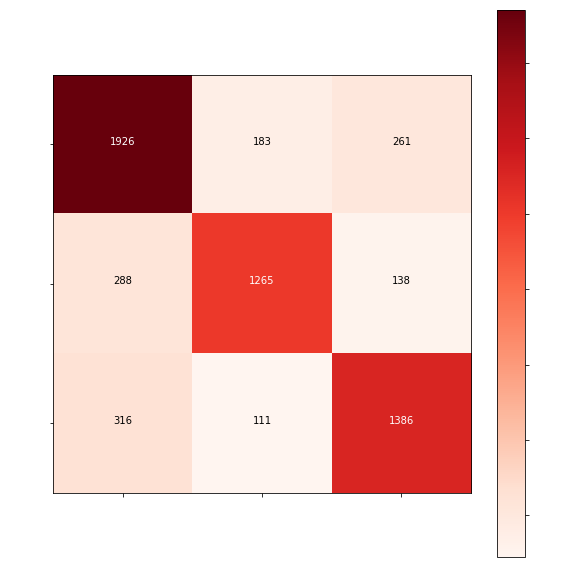

In [702]:
plt.figure(figsize=(8,8))
plot_confusion_matrix_white(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of Passive Aggressive')
plt.show()

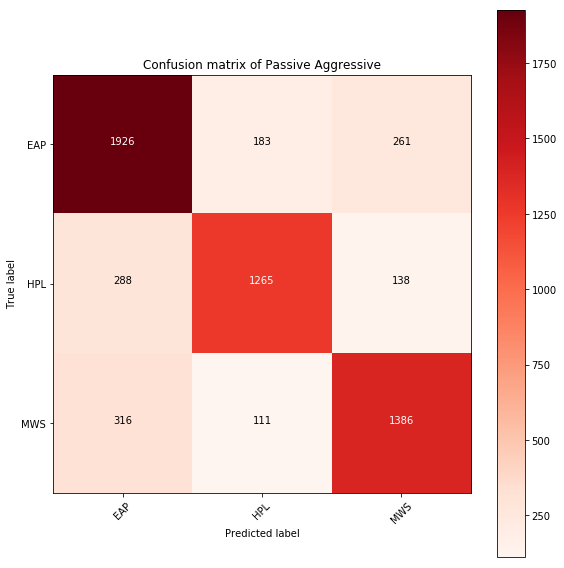

In [703]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of Passive Aggressive')
plt.show()

In [704]:
coef = pd.DataFrame(feature_names, pipeline.steps[1][1].coef_.tolist(), columns=['Feature'])
coef.head()
#coef['abs'] = abs(coef.index)
#coef['coef']= coef.index
#coef = coef.sort_values(['abs'], ascending=False).head(25)

,,,Feature
0.197646,-0.011433,-0.004842,aback
-0.052450,-0.054919,0.219766,abaft
0.726679,0.081128,-1.240289,abandon
-0.517111,1.013380,-0.271165,abandoned
-0.177787,0.169519,-0.106114,abandoning


# Gridsearch

In [705]:
#hyperparameters = { 'features__text_pipe__tf__max_df' : [1, 0.75, 0.5],
#                   'features__text_pipe__tf__norm' : ['l1', 'l2'],
#                   'features__text_pipe__tf__max_features': [None, 2000, 5000],
                   #'features__processed__tfid__binary': [True, False],
                    #'classifier__base_estimator': [30, 50, 70],
#                   'classifier__n_jobs' : [1, 2, 5],
#                   'classifier__fit_intercept' : [True, False]
#                  }
#clf = GridSearchCV(pipeline, hyperparameters, cv=5, scoring='accuracy')
 
# Fit and tune model
#clf.fit(X_train, y_train)

In [706]:
#clf.best_params_

In [707]:
#clf.score(X_test, y_test)

# Modeling Evaluation

Model evaluations

Logistic Regression
- Some overfitting, but overall good performance
- Top Coefficience are words

Random Forest
- Major overfitting with little in good performace
- Top Features are created features

AdaBoosting
- Little overfitting, but not good performace
- Top Features are created features and words from text

# Wordcloud

See following Kaggle Kernal for method of making word clouds
https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial

In [708]:
from wordcloud import WordCloud, STOPWORDS

In [709]:
from PIL import Image

In [723]:
from scipy.misc import imread

In [724]:
eap_64 = b'iVBORw0KGgoAAAANSUhEUgAAAoAAAAGHCAYAAAAgIOMGAAB+7klEQVR42u3deXhV1b0+8HcNG2QKQ04YnFGrVisZGB3A2hZBIThACFasE3pltna4t4ND1fb23v6uV8CpoqKtViSISoBItVoVvIQhCdbWoSJWUECSIEEEstfw+yN7x0NMIEACGd7P85xHOTkckp191n73d03Cew9qnrz3cM4J770EIIQQUEo5AK7ma7dt2wZjTPtXX321izHmmMrKyqOfe+65Y40xvTdt2tS7uLi4mxDiKO99WwBHAUj+b1sA7QAIAGH0MAD2ANghhNjuva/IzMzcfvTRR39qrf34xBNP/GTw4MGblVLrvvOd72zWWu/q2rVrzW9LGWMEAKeUckII/lKJiIgOA8EA2HzCnvdeWGsFAKW1hhAirO21paWlWLVqVZf169f3Wbp0aeamTZvOXrVq1TcB9AbQ6Qh8+9sBvNO3b9+3zj///Fe++93vFvbv3/+jtLS0vV5krQ2cc1Yp5aWUPDGJiIgYAFtf4LPWCu+9AiCCIHAAbM3XlZSUYP369Vl/+MMf+nz55Zfn/fnPf+4DIB1Am9reV0oJKSUA+Pj9nHNwzsn4nwYga54ntX2LSf/vAAgppYveO/47Knrv2r6Vyq5du748fvz4vIsvvnjx8OHDt9b4ehCGoVdKWYZBIiIiBsCWHPpEHPqCILCo0ZW7detWrFy58uiXXnrpnFdffXXoW2+9dS6AM2t7ryAIgKpuWh+HSQDSey/2Eeoa5ccSQnhUdfN6IQS894Expubr3h01atTca665Zu555533Xo3qoDLGCKWUYTcxERERA2CLCH3GGCGlVEqpvbp0i4uL8frrrw946aWXLli5cuV3t27dOgi1dOEGQeCjsIdoTF0c9JpqWvJCCC+EcEop75wLrN2ruLkpMzPz2WuuuebJK664ojA5DIZhKKNqKBERETEANq/QZ60VQoivhb6FCxee+Pjjj1+6bNmyy7Zu3Tqk5t+Nxv4Z771P7iJu7odECGGjCmEQhnsdki/T09OfnDBhwowpU6b8I3pOOuc4TpCIiIgBsEkHPiR17cYzaavl5+efMnv27Kvz8/OvRNVEjeTA54QQNvr7Tb2y1zAnZVVl0AohdBiG1T9rt27dlt15553XTJ48eR0AWGuVUsryDCMiImIAbFKMMVJrLVBjAseiRYuOffjhh6/Oz8+/BsAp8fNKKUgpQ2utcM61hOpeg4RB51wQTybp27fvbxYtWvSLnj17AlUTTWzS5BMiIiJiADyiJKKJHEVFRVi+fPnAxx57bGxJScmlAE6qGfqMMao1VPgO+mBKaYQQOhov+P6MGTOyp02b9j4AOOeklJJjA4mIiBgAjwzvfdWqzIDPy8s79qabbrq3vLz8UgCKoe/QD69SyllrFQD07dv3l/n5+b/u1asXwGogERERA+CRCn/eeyWltGPGjPnes88++xIACCGgtfbee2OtZeg71BNXCCulVFE18G9z587Nzs3N/RcAWGtltCMKERER1YKlkgZmrVVSSjtr1qyznn322ZfiSp/33odhKIwxQbx1G4/WIQVtZa310SSQs8aNG/fR6NGjf/Tll1/G2+Ep3twQERHVjhXAhgsksNYGWutw/vz5iZycnM+ibmAbLdVCjXUSC1F9jNu1a7fqySefvOzyyy//BKja5YRdwkRERAyADRL2AAhrbdzdK+L1/ObPny9zcnI+A5CaHEyo8X8tSql4xxPk5ubeOHfu3NlRCBRcM5CIiIgBsN5BL160GVXd5UJKCaVU9c4byR588MF+kyZNygfQUwjhoq5eOoyklDZaPgeJROJ/t2zZcouUEsYYobXmyU5ERMQA+FXQAyDibdQAiHjHDQB1HqC1a9fi9ddfP3fJkiUjX3zxxYsB9AEAIYRP2nOXjsCvNAgChGEoLrroorufffbZW9u1a8dKIBERUWsNgDXDXtR9axGt11dTWVkZ3nzzza4Aznz00UdPrayszCooKDgTwDcAHJP82qgL0iJpuRc6cr9qKaVwzqFjx46Pf/LJJ9empKSwEkhERNQaAmBSN64CIIIgqLX7FgCWLl3aadeuXWc98cQTZ61fv/7stWvXfgvAWQDa1PX+QRC4qm15rfDea55STYvW2htjREpKSsGGDRsuTklJgfdeCCEYAomIiAGwJQW+eN/dfVX3XnrppS4LFy4854MPPhj+4osv9kdV9237OkIeovewABBXD7mWX7MJgdYYozp16vT6xx9/fH6XLl3YHUxERAyAzT3wxRW+ugJfWVkZXnvttdOfeuqpwa+99trwsrKycwH0qPle0Zp9DlVLt8QzShn0WlAI7Nq16+zy8vIbo3PfV63UQ0RExADYHEKfiKt8QRBUV+ZiJSUleOONN85ZvHjxxUuXLv0OgIGoseh1FPYsAMeKXuuglPLWWpGTkzNh3rx5jzrnlBDCMgQSEREDYNMMfEgKfAJAmPz10tJSvPHGG6c/9thj2YsWLboMwNk13yPqxg3jtfsY9lolr5QS1lrMnDnzzKlTp/7DWquVUoaHhoiIGACbRugTxhghpVTRBXqvb3Tp0qXdlyxZMvypp566rKys7LsAOtUIfNWTM1C1LRjDHkEI4VBV7f3ymWeeSRs7duyX3DuYiIgYAI9c4Ntnla+kpEQ/9thj31m2bNnlxcXFwwGcUCPwwXsfxu8BVveo7hAY79CyoaSk5Pj09HSEYSij4QREREQMgIch9Mm6xvItXrz4xAcffPDyxYsXXwGgX/LXojF8yV263HWD6i3eMaRr166r//Wvf/Xv1KkTjDFSa80QSEREDIANzTmXPGN3rypfUVERli9ffs5jjz12RUlJyWWosdByEATWe++stRzDR4d+8kfb9aWkpLy2YcOGb0cLRTMEEhERA+Ch2l/X7osvvtiloKBg1J/+9KdxpaWlw5A0Wzeu8hlj2K1LjUJr7YwxMiUlZemGDRuGMwQSERED4CGIK33RzhvVXbtbt27FsmXLznz88cfHLFy4cAyAbyX/vaTJG6zy0eEOgQs3bNhwCXcLISIiBsADEI/p01qL5NBXXFyMOXPmXLh8+fIrioqKRgHoFn8tqvIZay2cc6zy0RENgZ06dZr/8ccf53C3ECIiYgDcD+ec8N6r5PXUSktLceedd35n7ty5N2zdujUHgIq/xhm71ERDYLxbyL3l5eU/BHcLISIiBsCvi9bp01LK6nF9DzzwQO+HH3745rVr194AoF1S6PPeexN17XLGLjVJSilYa5Gbmzt97ty5M1G1ZqBjCCQiolYfAI0xQmutABgA2LZtG37+85/nPvTQQz8B0Dc59FlrLbt2qRmpGvznPXJyci6ZN2/eQu+9jBaQJiIian0BsGbwW7FiBX7zm9/8KD8//+eIxvUppSCECFnpo2bMKaWktRZz5849ITc392PnnIr2jiYiImodAdA5h2iMnwWAwsLCttOnT7+jsLDwxwA0UDV71xjjvPeah5Wa/Qfjq91CPiktLT02NTWVk0KIiKjF2G+FzjknpZRQStmVK1diwIABPxs0aNDuwsLC/wCgtdZGCOHCMJQMf9RSeO/jit8xp5122hwAkFKiqe6dTURE1CAB0Dknqq550pWVlWHKlCnXDRw4cPuqVat+g6rkZwB4Y4xmVy+1RFG3ry8rK7tm3LhxlwLwiCreREREzVmtXcDW2uru3pkzZ54xffr0pwBkxMHPGMNJHdRaVE8KmTt3brfc3NxtxhilteZ4QCIiahkB0HsPIYQCYDdv3oyRI0fet2bNmslA1YzeMAw96tFtTNSiPiRfjQf8V3l5+Yldu3aFtVYopdgfTEREzTsAJg9wnzFjxuk333zznwEcp5SCc84c4vg+H11IPQAnhPBKqQb5Aay1iLaMi8no35NJ4ZbVSjokUkrrnFMpKSkLysrKRmutOSmEiIiadwBM3vc0Jydnyvz582cBgFLKWmvrk9T2Cnhaa58UvBQAEYbhYf/hgiBI/qND0vZ0NcKjxN7VUAZG+hqttTfGiJEjR/40Pz//d+Ai0URE1FwDoLVWSCn99u3bceqpp8747LPPpkUXNFfL5I54WyyrlIr/XwDQ9Qx4ZQA2pqambjznnHM2WWu/EELsBLATwJfRf7+IAmVbAAGANtF/A1QNwG8LoJ33vqtSKmX58uWdy8vLOwDoCKBT9N8OADofQmCsDovR/sYiutgLhsNWzUsphXMOY8aMuSovL+9JcLs4IiJqjgHQOae2b99ujzvuuLwvvvhiTLQVVm0VvfoEvS0A3rv44ovf8d6XDB8+fP03vvGNT40xG4877rhtGRkZh+0HKysrw5tvvqmUUqnW2m5a69SCgoJu69at6ymE6C6l7PXmm28eV1ZWdgyAowH02t97KqUgpQQA47333Mu4dYZApZSw1mLMmDG5eXl58xgCiYio2QXAyspKDBo06O6ioqJftGnTJrTWVq394pyyttaJjh7A2qysrLd79uxZNHz48L+fdNJJ/+zVq9f6rKysev2bAFQYhg1ytYyqdh5VFbuDHo8VBca2SqljwjDs9eijjx7jvT9z48aN3yopKTkZwCmoqizW9j1wEezWGwIvy8vLe54hkIiImlUAvOWWWy685557lrZt29bv2bOn5tWrAkDJsGHDCk877bTlF154YfHAgQM/TiQS+3pPaa1VzrnkwJg88SOuLjbMlfjry9iI+PkowMZj/Kq/ViM8mvoGxyVLlgQATvnzn/98xquvvjrsrbfeOhvAt3gatfoQyEogERE1rwDYqVOnt3fs2HFm9OedmZmZC84777z8ESNGvDZs2LDP6vp73nttjIn/bJMDXnO5ACZP+kga64coMAoA0FpDCFFnSHzvvfewbt26kydPnnzrRx99dLWU0keLaFPrCoET8/LyHorPK4ZAIiJqyrQQoqJr164vXnXVVf996623vlpLdS+5ohdP/vBCiLDGLNvml36/ukh7IQSSlvRwNYOi917s2bNHCyHUUUcdVRm/5rTTTsOGDRs+9t5XJP1dxVOrddxAWWu9UkrMnz//wZycnJS8vLz/jhaOZiWQiIia7gXs888/R+fOe02YVWEYSiGEjRa6bbUXsqgqKIUQSim11+yX/Pz8k3//+9//YPHixVcDOIGnUquWXAmckJeX9yjYHUxERE05AEbdoDIMQ6mUslzYtmpRbGutCoJgr4kl+fn5p8yePfuq/Pz8qwD0rk7MDbNYNjXzEKi1FsYYTJ48+YL77rvvr9FewtwyjoiIml4AjCdrtPZKRVzt01orANXVvlWrVnW68847r120aNEkAKclhz4pZWiMUVwfkKLPkBFCaOfcrpUrV7bv378/jDEiaWF0IiKiJkEKIdCau3iNMcJaGwghoLV2AMLS0lJMnTp1ePfu3QsGDBhQsWjRohkATlNKIQiCUAjhrLU+DMMgWiyb4Y/gvddKKQOg3a233vrz6GlWhYmIqMkRtSyj0uIldfHG6wcCAB544IFvPPzww5PXrl17Hap2Fam6gmsdRos+82JO+/5ACRHvoPPZ9u3be6SkpHDPYCIianJka/lBo2qfdM4FUkofBIEBYNeuXdtm8uTJNwkh3pk8efL7a9eunQ6gUxAEXkppAHhjTMDwR/U8z2TU5dv9iSeeyAIAYwxnhRMRUZPS4iuAtU3oKCsrw1NPPTXwrrvuurm0tHRc/FqlFIQQobVW1bIPMlH97qqkDJ1zQUpKygvbt2+/FIDy3lvOCCYioiZzrWqJP1Rc7QOQXO3zCxcuTLvkkkt+kUgkNk6fPn1FHP601lYIYay1iKp9DH90KDcdWmuNioqKSx544IEzUTXMgFVAIiJqMlpUBdAYI6I1+6q3KCktLcVdd92V/dRTT/2wrKzsgvj5IAhgrTXOOQVO4qCG/mB9NRZw19y5c7vl5ubuds5JKaXj0SEiIgbAQ5S0fItE1b6+AIAHHnjgpGhCxw2IJnRIKSGlZBcvHa4QaL33CsDbO3bsOKtjx45wzkFKnnpERHRkNdsrkXNOhGGohRAiWr7FFBcXY/LkyT8QQvxt8uTJ69auXXsLkiZ0OOc8u3jpMN6cqDZt2lgA3/rhD384NDpv2RVMRERHXLOrADrnBAAVzdAFAOTn5/f69a9/Pb2wsHAqgPYAJ3RQE/mACRHvEPPhzp07T27fvr2qrKz0QRA4TgohIqIjpdkEI2OMQDSpQ0ppSktLMWvWrMGpqakvjho16tPCwsJ/B9CeEzqoKfHe6yAIHICTfvSjH10GwLZp08YJIWQYhoExRkY7yRARER02Tb4CGG2lpRCN7ystLcXtt99+wwMPPPBLAMcDX43ti9ZbY+CjJpcDEU00mj59+uXXXnvtc+np6TVfE4RhCCGEVUqxOkhERK0zABpjpNZaINqpo7CwENOmTfvRypUrbwXQGQCCIPDWWsuZvNTcpKWlvX7eeec9c+21176QnZ39Sc2vW2sD55yPAqFnICQiohYdAKOKnwDgouDXdvr06T8vLCz8DwBtAEBr7ay1YPcuNTNea+1q2RlkY3p6+otDhgx54eKLL35l+PDhX9b4urTWKuecV0pZIQQDIRERtYwAWLOrt7CwsMv06dNvLywsvDl+jdbaWGslgx819yAopbRKKe+cC6y1Nb/+7vDhw5dcfPHFzw8ePPiNjIyMml9XYRgKpZTlHsNERNQsA2Atwe+o6dOn/7awsHB6cvCLqiYse1CLC4NCiLiyJ51zqpZAWDhy5MjnrrvuukWDBw/+eyKRYBgkIqLmGQCdc0JKmRz85PTp0+8sLCz8RVLwC40xmsGPWlkgjMf9qTAMa1a7v0wkEgXjxo17+Pbbb/9zjTAYhGHoGQaJiKjJBcBo5w6ltbYAsGLFCtx8880/LSws/DUAHQU/VvyIvh4IgzAMk7+2KzMz80/XXHPNQ1dcccXqtLS05BuswDnHGcVERHRkA2AU/LTW2gBAeXk5brjhhikLFiz4LYAODH5E9fjACuGEEE4ppcIwTP6clGZmZj5x9dVXPzJ+/Ph3U1NTq78QzSi2WmuGQSIiOnwB0ForlVIegN+1axduueWWSx966KHfA+geBT9rjJEMfkQHFAbjsYO6RmXwo1GjRj0+YcKEx7Kzszck/5UwDBW7iImIqFEDYM0lXR566KH0W2655fe7du0aCABKKRcNeOesXqJDC4MuCoM1u4n/kZ2d/ciECRP+MGrUqLKk5wNjDLuIiYgYABuO9x7OOaWUsgCwYMGCbjfccMMD5eXluQCgtYa11nE5F6LGCYNaa1tziZnU1NQ3rrzyyv+59dZbX0iaPBJXBY2U/DgSETEAHqSou9cBwMqVKzF16tRfr1y58udJwc9473Uj/TzVA+adc8J7H++zyhIHtUbJn4fAORc/v2PAgAEP/fKXv7w/Ozv7X/GT0WuM1prdw0REDID1Ey3rUt3dO3369Etmzpz5BwApACCljLdsa/ALXHTBqmsNNQRB4AGYeAYyK4/UGsNgtPj0XpNHEonE61dcccUdt99++6tJE0e0Mcaxe5iIiAGw7qvK17t7e9xwww1PlpeXfw9o8Jm9+1sjDQD+OWjQoGUfffRR982bN2cAOKaWQOi895ZhkFrlhz4aL1ijKrh+8uTJv77++usfzczMrH4pJ40QETEAfo21ViilAMBv3rwZo0aNum3VqlW/ioKfN8Z4HNoEj/oEvr8PGzbslVNPPTU/Ozt72dChQ3clf3Ht2rX48MMPv/XHP/6x/0cffXRBcXHxpQA6JYVBHw2aZ6mDWh0ppalRFdwzcODA+37xi1/ck52d/WnyfRMXmSYiYgCEtba66jdt2rRvz5o16ykAR0cXlYPt7q1P4Fs7bNiwl0aMGLF48ODByzIyMkzNFzjngugi9bWvlZWV4fbbbx+5fv36s5csWXIlgBN4GlCrbwiqqoI+qtYDALp16/bSr371q1/n5ua+xkWmiYhaeQCMxvoBgF+9ejWys7Nnb968eQIAKKWstbbe6/kJIaoDX1RhqO1lq4cNG7Z0xIgRSwYPHvx/GRkZvpYwGjjnPAAXL3Yb/VzCWgvvvRJCCK01AFT/I9u2bcNtt9126X333fckgA5Jf4+otfJaa1OjezheZPqx8ePH/4OLTBMRtbIA6JyTUkoHALNmzRo4bdq0hQC6K6XgnNvfsi4+CnxOKeW994ExprbX/d+wYcNeHDFixNLBgwcXZmRkoK7Al1QtPKAAG1UvhZQyBIAFCxa0HT16dKkQoqP33oHrEhLVOmkEwIZRo0bNmTBhwuPZ2dnra34uvfesDBIRtaQA6L2XQgi3adMmZGdn37NmzZofAlVjiJxzuq7AFy1OizoCn01LS1s+YMCAJUOHDn3p/PPPL2rowLefMAjn3FFa690DBgyYuWrVqqlHHXVU5e7du9vw1CCKGom6F5n+Z3Z29pwbbrjhiRrjBbm2IBFRcw+A3nsIISQAN3/+/O45OTn/B+AkKSVcVR+RTAp8cUATzjldy5IsOxKJxJtDhgxZfOWVV746ZMiQt5MWpI1Ja61qjMBXm8rKyqBNmzbh8OHDf7Z06dLfJP/o4MQQoq+FwdoWmQbw9siRIx+77bbb5vTv3//zpJssri1IRNTcAmAU/gAAU6dOPfu+++57E6he2kVGF4N9rcG3KSMj4/XevXsXjB8//rUhQ4Z8VFvgM8Yo7/1hCXw1RWMa/d///veU//u//xu0ZcuW7b/85S9XtGnTBt77yjgEGmN0tKg0EUUV/trCYCKRWHDrrbf+1/e///2VSZ93ZYzx7B4mImriATA5/OXk5Nwwf/78h6WU0Frvds4dVcf4vfczMjL+Onjw4CUjRox4fdiwYdtqeY0yxkjvfdw97JvaBSEtLe3+0tLSSTw9iOodBm00izhIev6j7Ozse37xi1/8fuDAgZXxk2EYaq21YRAkImqCARBVlS+fm5t787x58/63jtesGTp06F+ys7MLTj311P8bNmzYnlpeo6NB5HF1zzfFht97L8Iw1G3atAkBYOHChSc++uijF1prIaW0+fn5MwB0kFKGSilYa0UdYx+JWnUYjCaP6OTxgpmZmY9fd911d06ZMmV9chDkOEEioiYUAMMwlEEQuD/+8Y8n/eAHP1gXPf1pIpF4d9CgQX/+3ve+95fzzz9/dW0TNhAt55LUndusxv5ElU+BqjGA1R588MFvTJo06f3k56JxkBwrSFRb41L72oJL7r777l9MnDixJH7OOaeFEKwIEhEd6QBYNRxP+NLS0javv/76aaeccsrbffr0qTXI1bYGX7MvYXgPY4wEoOKgp5QKL7nkkl8uXLhw/OjRo19ctmzZGVu2bBka/xWGQKK6P1I11xZMJBIrrrjiip8n70FsjNFKKQZBIqIjFQD3Ie7OPSITNo5kIKzt57z55puHzJgx47UaITA+oLyKEdUgpTQAdNIi0+/edNNNP73nnnvy27VrB+CrHggeLSKiIxQAvfcinu0b7/nbWu/Oo+OkhBDOGKO11g6AvfTSS8e88MILeUopb60VUbcwzyyi/QTB5HGC7dq1W3XPPfdMuummm1bHL3HOee47TER0BAIg1R4EhRCw1opofBOCIFgP4MRoweutAD4EMBCARdSNTES1NEBVN5cyXlUgNTX1+V/96leTJk+evAnYe89xIiJqwBtxHoIDvmABAOIlL7TWGD58+AtxOBw5cuSN3bp12xq9lumaaN83VNIYAyGEkVKirKzs0ilTpnzar1+//928eTOi8KeccxxSQUTEANhkLl4AgHbt2r0HAGlpaYvy8/Of//LLL4dHL2H1j6h+nyXtnIu7hrFmzZqbe/Xq9a+ZM2d+C4CVUnrnHNsrIiIGwKZx3QKAnJycIgArly1blg0Au3fv5vqARAch2kLSR5W/46dPn/63fv363bZp0yZIKR2qqoE8UEREh4hjABvjoEZdv0IIz+3jiA76c+SklDLaZm7t3Llzs3NzczcAgLVWKqWYBImIDhIrgA1HJx3Pf0X/ZbomOkjee5lUDUwfN27cx6NHj560e/duKKWctVbzBpaIiAHwSF+sjLVWAcCpp576BgBw9iLRIRPWWiWEsACwYMGC+7t27frK888/3yFeNNpayyo7ERED4BG6SgkRbwuHH/3oR/8TBUANVgGJGuIGS6FqRxG/e/fuCy677LIdN9988+XR58zHN19ERFTP3MIulAa9SFUvE9OpU6fnv/jii0t4VIga+K5VSuucUwDQs2fPeYsWLcrt27cvAIhoJjEbNSKi/bWlPAQNmKarqoACAD755JNLp0yZchmqFoMGWAkkahBR+PNKKWzevHlsv379tk2bNu08AJ7LxRAR1TOzsALYuI499tj5n3zyyWgpZeicC3hEiBrwDlZK45zTANCvX797Fi5c+KNevXoBVcvFWCmZBYmIam0/eQgax+7du9sAQEZGxmoAiPZSJqIGFIU/p5TC6tWrbzn66KP/+cwzz5yCqsWjYa1lG0dExAB4+MRrlA0ePPjl6CkuDk3USO2YtTaedX/KuHHj/jl69OhJu3btglLKGWN490VEVAO7gBuJc05IKf0XX3yBTp06bQbQQwjhvPcM3USN1aAlfcZSUlJefPXVV0dmZWVZcIIIEdHed848BI10YKX0xpigY8eOmDBhwmQA0Frz4kPUiKLw57XWvqKiYnjfvn2/mDZt2gWIJogYY9jmERGBFcBGFVcBd+zYgZSUlPcAnBoEwZ4wDNvy6BA1+k1Y9XIxffv2veeVV175UUpKCqy1iou0E1GrbyN5CBr1AuSttbJTp054+umnzwYAhj+iw3YDpgA4rTXWrFlzS8+ePdc899xzbaPwp3jzS0QMgNRooskgYty4ceWzZs0648wzz3w8Coc8OESHoY0zxkBrbXft2pV1+eWXl86aNetbAKwQQsTrdhIRtTbsAj5MkncJEUL8E8ApnBRCdBiTYFKX8OjRo6+cP3/+nwDAGCO11o5HiIhaVZvIQ3CYkrYQ2L1791EA8N3vfncJAGitOQ6J6DCJu4SFEHj22Wef6t+//z3bt2+H1trFwZCIiAGQGlw88Pyb3/zmX+JcyKNCdHjbPO+9l1Ji9erVPzzhhBP+unr1akgprfeeIZCIGACpUVgAGDNmzBvRnzW4RzDR4Sacc9Bau+3bt5/fv3//Tc8++2xPIYSNAiKPEBG1/IaQjd3h470XQggPAEKIzwCkcRwg0RG8A04aFzh16tSzZ86cuQL4agknHiEiarHtHw/B4c2AiLaESyQS/xcFQY4DJDpCnHMq/gzOmjXr/3Jycq6JgqH33nOIBhExANKhE0IgDEMBAAMHDlwFAEpx2BHREb0rqxr754QQmD9//pz+/fv/1+effw4hhA/DkG0kETEAUsPp3bv3qjgX8mgQHfm2MGlyyE+PP/74F3bu3IkgCDhDmIgYAKlBWAC45JJL/hH9mRNBiJqG6skhO3bsGNW9e/e/LViwoK2U0gJgCCQiBkA6JB4A9uzZsxGoWiCaiJoOY4wUQtgvv/zyW6NHj94yf/78k6MbN84QJqKWc8fLBu0wp7+9ZwLvAdBGCMEB50RN7e5YSueckwCQk5PznXnz5r2KqErIGcJE1OzbOB6CI+qL6L/choqoiYnCnxNCIC8v75Xc3NxJADxnCBNRS8AK4GFWRwWQuxAQNeEsKISQ3nt07979f99///1bOnfujDAMZRAEvHkjomaJFcDDzNqqZf+KiooAoI1SClwImqhpt5Pee6+U8p999tkPjzvuuPx4hjBv3IiIAZDqJe462rx589EAICV/BUTNgLDWCiml27Fjx8ju3bu/tWDBAiWEsNZahkAiYgCk/VIA8OGHH34r+rMB1wIkahacc/EM4bNGjx69ZcGCBccppThDmIgYAKl+XnjhhTOj/+VVg6gZ8d4rKaUDkDp69OiPp02bNghV4wSFcxwSSEQMgFQLIaqKfW3btj2DR4OoeYorgUDVHsJjxoy5ElUzhMEZwkTULPIIuy0Oa+UAQggNwAgh/grgfCGE8d5rHh2i5pkFlVLSWovLL7/8jj/84Q+/6tChA5xzgmsFEhEDIMUBMHkJmA0AjhVCOM4CJmreH21RtZo7OnToMPvTTz+9MSUlBcYYqbVmnzARNUkMHkdONx4CopZzIx0Egd+5c+cNxx133IKKigporV0YhmxjiYgBkPa+aACA1trwUBA1f2EYCq21r6iouOy44457jWsFEhEDINUmiC4abXgoiFoGY4yQUrqKiooh0VqBiNYKZFtLRAyABADQAHDuuedeJ6XcHT3HAZlEzVyNtQI/mj9/fgellDPGsBJIRAyABHfeeectWrZs2Rzn3AcAEC8rQUTNW7RWoAVwQk5Ozsfz58/vobW2ABQn3hERA2ArvC4kHfPdX3755UcAcOaZZ74DAEopXhmIWsodnnNKCOEAdMvJydk4a9asMwFYIYTkgtFExADYiggh4JwTADBlypTrr7766tkAcMwxx6yJv05ELeiOz/t4wWg9bdq0t0ePHn0pACelhDGG7S8RHblMwu6II2/q1KmX33fffc8GQRCGYRjwiBC1OMkLRv/yySef/HW7du1gjFFKKcubPyI63HgHeoQYY+SuXbsCABg9evSG6GkOEidqoW2ttdYLIbBgwYK7e/bsWbBmzRpora2omibMBEhEDICtgdbaRYPCUVpauiHp98GSLFHLJLz3iNYKHN6vX7/y+++//xwAPhr/q40xDIJExADY4q8G0bZwJ5988mYA4MBwopYvXisQQNcpU6Ys79Wr12OrV69WAIzWOg6CksNziKjR70jpyKixN/AWAN25NzBRq1E9LhBAOHDgwF/MmDHjdwMHDqxun8MwVEopK6VkQ01EDYpB4whnwKTfwbr4osDDQtQ62l9rLaL1AoPCwsL/HjRo0I6zzz77N/n5+UcD8EEQmCj8BawKEhEDYAshhEC8O8C3v/3ttQAQdQERUSvhnFMAfDQmuOOKFSt+NmrUqE8SicSr06dPH15aWgoAodbaCSFgrQ3CMJTee44XJCIGwOYqvqPPyMj4C48GUeu9H4xuBp3WOpRSoqys7NszZ84sSEtL2zpgwIBfL1q0qDcAKKXCIAicEMJHYVDHgZAVQiJiAGw+LAAMHTr0zejPATgTmKjVtsnGmMA556WUJggCDyCxatWqn2dnZ38ohHh31KhRt+Tn5x+bFAZNHAiFECoMwyAMQ22MYSAkorrvOtlAHFnOOSGl9Fu2bEHPnj1LAaSiahwgwzkRQQjhlFLWex9EE0ZiHw4fPvz5U0455S+jRo1aMXTo0PI63iIIwxBCCBstN+O58DQRMQA2jRAYSCnDs846a/bbb789QWsdGmO4IwgRJfNCCKu19s65mmEQALYlEokVgwYNeuV73/vesgsuuGBVnz59bC3vo8IwlACsUspzhjERAyAdIWEY6iAIzMyZM78zffr0vwRB4MMw5C06Ee0rDMYTR4RzTtcSCAHgvfT09NeHDBlSMGLEiOXDhg37rJbXBGEYei43Q8QASIdZ3A1cUVGBzp07hwA0qsYBMgQSUb0DYdRd7PFVla+mstTU1GXnn3/+0iuvvPLlwYMH/zMtLS356yoMQ8EwSMQASIcvBAZSyvD0009/5L333rue3cBE1ACh0CqlvBCirirhp5mZmXnXXHPNH6+44oo1NcJgYIwxXJqKiAGQGlHcDfzII4+cdcMNN7yltYYxhgeGiBoyEMahELWMI/wiKytr4dlnn/3kHXfcUZBIJOLnlTHGa625SD0RAyA1eMvsPeKZeUKIdwGcJoQw3nvNo0NEjRUIlVJWCBGEYZj8tc8HDBjwu5kzZ94zcODA3QyCRC0PlxppKklcCIRhGADA9ddffysAaK35+yGixiwASGNMvEyM01qbIAgcgC4rV6789aBBg3YNGjTod4WFhR0A2Cj8KWMMxycTtYAGgEehiYgng3z55Zfo0KFDBYBOQgjnvWcQJKLDeUPqlFLOGFPdAzFw4MB7ZsyYcfvAgQO/iJ7SzjlOFiFqphgsmtIvQ0pvjAnat2+PCRMmTAcArdkDTESHV1QZ1KjaozgEgMLCwlsGDRq0Y9CgQb8tLCyUAIyU0ltrlXOOFUGi5najxwpg0xJXAXfu3ImOHTtuB5DCKiARHelMqLU2SSsThP369fuP/Pz8e3r27Bm3XVoIYbjLCFHzwFDR1H4hVVVA1aFDB1x//fXXAoBSii0qER3RYkEU/rzW2gAIVq9e/T+9evUqmzx58lVlZWWQUhohBIwxmoUFombwoeYHtelxzkFKiT179qBz587Fe/bsyZBSGucc+4OJqCnwSilvrY2LCOtvuummKffcc8+Sdu3aAQDCMJRaa8eKIFHTxApgU/ylSAljjG7bti3uu+++y6Ln4t1BiIiOePHAWiuFEC6aNdz7oYceWpyamrryoYceGgAAQRA4IYQMw1Cy0EDUBD/E/GA24Vts76UQwmVkZNy1du3aXyqlXNIdNxFR07iQVM0alvHi9ampqUvvuuuuyRMnTlwX39daa6GU4hqCRAyAtD/xhJDS0lKkpaWtB3CiEMJ67xWPDhE1wSBohBDaORcHwWfuvPPOH06aNGlTHASNMYi2p+PFh+gIYjWpKf9yoiUWEokEZsyY8Z3oOQV2BRNRE+S919EYZiOlRFlZWe7kyZM/7dWr16OrV6/uBsBF4wI9AB2GISeMEDEAUh0h0AJQ06ZNWz9ixIifsBuFiJo651x1EFRKYfPmzdf179+/LCsr6/cPPPDAidHLTBAERggBa63mWoJEhxe7gJtHYyqklN57jyAI1lhrs6SU1jnHrmAiauq8lNLVaK8+6dOnz8J/+7d/mzVp0qR3agRHq7XmhYmokbEC2Bx+SVVrA0ohBJ577rkLAEAIwa5gImoWhYYo/HmttVFKAcAxb7311sTJkyf/QwixduLEidnl5eWQUpoo/AXcb5iokT+YrAA2H845LaU02dnZVy5atOhJrbUzxjDEE1Fz4oUQXillvfeBtTZ+fuOUKVN+de211z6SlZUVP6eMMV5rzWEvRAyArToAQkopjDE+kUgUbN++fTi7gomoWV+EhDBaaxWGYVzx+2LgwIG/nTFjxn8NHDjQRM/Fs4e5sDQRA2DrZK2VSin3t7/9TfTp02ePlDLw3nOvYCJq7kHQKaW8Mab6hnbgwIH/b8aMGXcPHDhwe/yyMAyVUspIySaP6FDwE9TMKKWcMUadddZZfsqUKYOjqqAExwMSUTPmvZdR+HPRfsMoLCz88aBBgz7v27fv7Pvvv/9oAD4IAiOljCeMsBxIdLA3XawANsuGEkIICcBlZ2f/eNGiRb/jeEAiamlNndbaGGOC+InU1NT822+//e4rrrhiZSKRAAA451S0XBYRMQC2fPHSMNZapKam5m/fvn1ktNQCQyARtbQgaOO1BSP/nDhx4m/uvvvux7t16wZU7U3soxnGRMQA2LIZY4TW2r/11ltIT08vA9BNCMHxgETUIoOglNIqpXQYhvFzpZMmTcq9//77XwEA773gFnNE9cOg0Ixprb0xRvXp0wczZ868AADHAxJRSyWcczoMQwghXBAEDkDigQce+Mvll19+686dOyGE8OwFIarnB4oVwGZ+S1w1HlABsBkZGf+1du3anyqlrLWWfSFE1LIvYEI4KaW01qJDhw5/2LRp09WdOnWqXi2BR4iIAbBFi8cDbtu2Dd26ddsJoD27gomotQiCwIdhKDp37rz8/fffP6979+7w3ishBCeHENWBAaEl/BKrtooLunbtigkTJvwIALTWPDBE1CqEYSiEEG779u3n9ujR4/158+a1FUJY733AIgdR7VgBbCHiKuDOnTvRsWPHLwB0YBWQiFrZzXC8M1LZvHnzzsrJydkEANZaoZTixY4o+fPCQ9BiGj5vjAk6dOiAG2+88cdA1SQRHhkiakU3wkoI4QCkjh079tPc3NwrAEAp5a21ycvIELV6rAC2IPGyMP/4xz9w5plnGiGE8t47Bn0iam1ZMG73evXqtSA/P390375945CohRCGewpTa8dg0IJorb33Xp9xxhnIzMy823sPrTVveYmoNV7bvJQSmzZturxfv347pkyZklNWVgYppRFCIAxDzQIItWasALYwxhiptXbFxcUqKyvLCCHgq37JvN0lotaXBL8aFwgAf5s5c+ZNU6dOfTP+urVWCyGslJIXQ2p1d0nUgmitnfdeZWZm2gEDBjwUVQENjwwRtUZR+HNBEHgAZ02bNm15amrqkoceeqgPACiljJTSO+cCYwxvlKnVYAWwBQrDUAZB4AoKCrpefPHF5UopWGtZBSSi1n3BE8IJIWTSZJDim2666Y7f/OY3C7t27Ro/p4wxXinlOE6QGACpWYl2B5EAXGpq6pPl5eVXSilD51zAo0NErV00DlBbW71O9Kbs7Oz//sUvfnHfwIED4x4TEYah0lpzwggxAFLzEW+FVFJS0ikzM7OCYwGJiGpcAIUwWmsVhmF1u5iZmXn/dddd97spU6b8K34uDEPNIEgMgNRseO+lEMJlZWXdX1xcPElrbYwx3CKEiGjvIOiUUt4YU72Herdu3f5y9913/8fEiRNXJwVBqbVm1zAxAFLTljQjWGdlZYWsAhIR7fu+WWttnHNBPE4wNTX1tbvuuusnEydOXBW9RlprIaVkEKRmjbOAW7BoRrDOzMw0mZmZ/8l1AYmI9kkYYwLnHKSURkqJsrKy8ydNmrQykUi8+MADD5wEwEUTRKQxRrKIQs32ZOfJ27LFu4MUFRWhb9++8S+bu4MQEdWDlNIAqN5GrmfPnn9YtGjRD/v27Vsev4ZjBKlZnts8BC1btDuIysrKwqhRo24GqvbF5JEhIto/55yOK4JKKWzevPkH/fr1K0tLS/vD/fff3xsAgiDg7iLU7LAC2DoaMCGl9GEYok2bNpsA9BRCGO89J4QQEdWfl1K6pJ1F0K1bt6V33333zydOnFgUP8fJItQcsALYGn7JUnpjjAqCAFOnTh0NAEopxSNDRHRARBT+fDxGsLy8fNikSZPWpKWlrb7lllsuAIAgCJwQQlprmQCp6Z7MrAC2ktvWqsWhBQDftm3bP1dWVg6tsUcmEREd+A32XmMEE4nEX3/1q1/dNGnSpPeil2jvPccHUtM7d3kIWknSFwLx3WheXt7YKBQqALwDICI6SMljBKWUKC0t/fbkyZPf7dWr15MrV65sD8AIIWCM4fWWGADpyFBKOQBy1KhRn2dmZt7mvUcQBFwWhoioAYNgNFnkyoEDB35x+eWXX79r1654CS7pnGMpkJoEdgG3vkZKSCl9aWkp0tLS/gngFCGEjaqBRETUAKSUxjmnAaB9+/Zrfve7342bNGnSBwBgjFFKKctuYTqi5ygPQatrlLxzTiYSCcydO/ccAM57r4QQrAQSETXczbYG4JVS/ssvv+w7efLkf/br1++/t2zZAq21FUIIThIhBkA63CHQee9lbm7u1nnz5p2VdC6wHExE1HCEtVYIIYxSCmvWrPlJz549t06bNu17cTi01ir2xNEROTl54rVe1lqtlDLjxo274plnnvmTlBLxTDYiImpQceCTANCzZ89nFy1adGXfvn33oGp5GUgpeUEmBkA6DK1R0tIwaWlpC0tLS7O5NAwRUSNedIVwUkpprQUAM23atFEzZswoiG7KlVLK8igRAyA1ujAMZRAErri4GFlZWdwrmIjoMEieJNKjR49H165dO6FHjx4AoJxzVko2wdTI5yAPQesWBIHz3uvMzEyMGjXqKgDgJiFERI0rCn9OKYUtW7Zc37Nnz40zZ848C4CVUnLdQGp0rAASorEnqKysRNu2bd8FcBr3CiYiOjySh95kZWX94tVXX/1NSkoKwF1EqDHPOx4Ciu42dZs2bTBz5szxAPcKJiI6jDfhSgjhtNYoKir6dc+ePQsXLFjQDdEuIlw8mhoDK4AEYO8JIW3atFkahuGFUsrQORfw6BARHZ6mWClVvW1nbm5uzty5c+cDgDFGRruJEDUIVgCp6k6g9r2CA3BtQCKiw9YUW2uFlNICwDPPPJPXo0ePWTt27IDW2nGFBmIApEYR7xV8ySWXbB87duwl3nsopQRDIBHR4RMFPa+UwmeffTalZ8+eKxcsWHBUFAyrF442xgjvPbuH6eDuNtgFTMmirmAJwGVkZPxm7dq1P1NKWWst7zyJiI7AjXm0ePSuvLy8vmPGjHkHVcUbdgfTIWEFkPa+I6gacOwB4LXXXvu51rrYWqviLgkiIjp8rLVSSmkAtMvJyfnH2LFjvxuHv3/7t3/rt2rVqtTodawEEgMgHeJJIaU3xsjOnTvj+eefPx8AvPcK7AomIjrs4jUDhRDIy8t7+fLLL78RADp06JC6du3a7lEbzQNFB4RdwLTPRkdKafr27furoqKi29gVTER0ZJtlIYT03uOcc865e/ny5bfG13LeoBMDIDUYY4zQWvuSkhJkZmZ+KYRo573nNnFEREeOl1IK5xw6dOgw75NPPsnt3LkzvPdCCMELOtUbL+RUJ621t9aqjIwMTJgw4WrvPbTWHGdCRHSYRAtEh0EQhFrrUAhhvfe2TZs24c6dO8eecMIJy7744gsIITwXjKYDOrdYAaR9ibeJ27NnDzp37vy3PXv2fCt5E3MiIjri3vLepwOQ3nvHreOoPngRp32Kt4lr27atuf/++8dMmDDhXSEEzxsiosPj3fT09PeOP/74Lz7++OO2a9euTQXQBUBbAEcB2HX66afnRa9lRYfqjRVA2q/ktQFTU1OfLC8vv5JVQCKixmt2tdbCGFP27rvvJk477bQDaat59KheOAaQ9n+XULVNHADg5ZdfviZ6WvNuk4iocZpd55wFkPrd73738YqKCgCQ1to2UdsrogdQVcjRcVtNxABIDUop5bz3KjMz04wYMeL7zjlozQIgEVFjcM4pIQQ++eSTq4899tjZFRUVTilVGYah818Rvmr6r+ERowO+y2AXMB1AgwQppTDG+EQiUbB9+/bhUkrLDcqJiBqH1tobY0RKSspTGzZsGJ+SklK9RBePDh0KVgCp/ieLlLDWCq013njjjYsB+OgulXtSEhE1gjjsVVRUXHncccctrKioiEMhr9/EAEiHj1LKGWPUWWed5adNmzY8CoYceEJE1Lgh0FVUVGQfd9xxr0Yh0Hnv2fbSQWMXMB2waKaZAOATicQfy8rKxrMrmIiocWmtnTFGdurUaenHH388vEuXLnDOCSklL+TEAEiHR9zolJWVIZFIfAzguGiFeoZAIqLGC4HWGKO6du36VHl5+fikm3IeHDog7AKmgztxpPTOOZWamoq5c+dmRU8rcGkYIqJGY4xRSim/bdu2K8eOHZsbBUDeeNMBYwWQDon3XgohXG5u7oh58+YtUkrBWuvx1RpVRETUkBduIZz3XgIwn3/+edC5c2d2BdMBYwWQDpUDIJ955pnF6enp/2OtRRAEnBVMRNSIN95BEHgAevbs2UMAwFrLKiAxANJhvROFc84DwKuvvvrjjh075odhqBgCiYgalQGAgoKCc+PmmIeEGADp8J5EUnrvvejatSs++eSTUR07dlwShqGUUgIcE0hE1Cj33wBw1FFHbeOhIAZAOnItkRDxavXYsGHDiH79+v2Xc656uRgeISKiBuOttRoAbr311jlRG2x5WIgBkI4IrbX33osuXbpg1apV/5GTkzPOew+lFEMgEVEDtrXOOYwcOfLfBg0atMd7r7TWHHZDB4SzgKnBRbPRJACbk5Mzfv78+X8UQsBXnWwcp0JEdJDiRfeVUm/s2bNniFKKM4Dp4M4lHgJqhAbKe+8tAJmXl/dkTk7ONO89tNYCgJdSeiml4ZEiIjrQ++uqHZfmz58/TCkFY4xk+CMGQGoyooqfAyDmzZs3q0+fPr82xiAIAuGcE845HU0SISKieoi7eSdNmnT5pZdeussY0y5qa3lwiAGQmlYIdK5qWMorr7zyyx49etwbhiHOOOOMp04//fT/dc6BM4WJiOrFo2q3JRhjvvziiy+gtd6llHJCCFhrgzAMJcMg1fsazZOFDqerrrrqmr59+xbefPPN71x22WV3Pv/887dqreGcs3HXBhER7df7o0aNmj1hwoQ/Zmdnb0n+grU2cM5ZrbXjHsHEAEhHVFK1by9jxoy56tlnn/0DACilvLUW4EQRIqI6SSmre1cib2VnZ8+54YYbnq4tDHrvjVLKMwwSAyAdEd57GGO0UsoBcFJKAcDff//9J/zkJz+Zt2vXrgHcS5iIqB4XbyGc1to654Loxjn29+zs7D9GYfDjpOdVGIZCKWU4/poYAOmIB0IhhATg9uzZgyuuuOJHzz333P+LGjfrvWeXMBHRfppSIYSN1gasGQbfGzly5Mzbbrvtsf79+++On3TOaQAMggyADIB0ZBljZDy7bdq0aefOmjVrWXyH671nC0VEdIhhMJFIPHvrrbf+7vvf/35hIpFgECQGQGoaojGCEoB79tlnjx0zZkwxgES86CmPEBHRgYdBpZQwxiS3oW9NnDjxZ3fdddeS1NTU6iAohDAcI8gASHTEGGOU1trm5eWpsWPHvgPgG6wEEhEdWhiUUlqllA7DMH5u/cSJE3961113zY+DYBiGkjOHGQCJjlxL5b0WQpjVq1dj6NChaz7//PMsrbUzxjAEEhEdykW/qotYhmEYp7y1M2fOvGnq1Kkroj/LMAylUsoKIThzmAGQ6PByzkkppfviiy9wzDHHvFJRUXEBQyARUYMFQRcFQQBAt27dFt999903TZw4cWPSy1QYhsltLtcWZAAkanxhGMogCFxFRQWOO+645ysqKi7RWntjDFsfIqKGCYJGCKHjdQVTU1P/dMcdd/x23Lhxf4sni9RkrdVSSo4ZZAAkajzxDOEoBM6pqKi4JggCn9R9QUREh0hKaQDopAWmdyQSiZVnn332p9ba0iAI3r3++utfzs7O/jD5Jp0VQQZAosYMgUJr7SsqKnD00Uf/786dO2+ONkDngtFERA2ntskiNf1t8uTJP7zvvvv+EmdHay2iBf6pOYV+HgJq6qI1rURKSgq2bNnyw8svv/wO7z2UUgIAGx0iooYhnHM6DEMIIZyU0gRBEMYPpRQAnHX//fe/nEgkXnnggQdOBeCi8Cc5PKeZ/bJZAaRmc2vqvRBCeAAYM2bM1GeffXYmUNV1ES1oSkREjRkaaowZ7Nmz5x/z8/On9uvXb3t8z26McUopdg03cawAUnNqeHzU6Ij58+fPmjJlyveAqkVMtdZeCMFqIBFR496I62jhfqOUwubNm6/q37//54MGDfpNYWGhAGCicYHSGCNZZGrC11T+cqgZNkAQVbeW/rnnnktMmDDhqfLy8gsBIAgCF41d4c0NEVEjq7Fbkx04cOD/mzlz5n8OGDAgrgiKMAyV1pqzhpva746HgJrdXUtVI+Kdc/Kyyy4rLSsrGzZ16tQLAXwYrVkloxltRETUiKLw57XWFoAqLCz894EDB36elpb2+P33338CAB8EgRFCwFqrjTEsPDEAEh3ynaez1koAmDlz5ktlZWUnT548+RoAXzrntFIK7BYmImr8+/Jov2GvtQ4BoLS09OopU6Z8lJqauvihhx7KAgCllImG66gwDLVzjiXBI/lLYxKn5s57D++9jqt+a9aswYgRI2Zv2bJlQtTo2CgosrEhIjoMzbKU0mLvdQXXTpo06d4bb7zxifT09OTgERhjfLz1HA8dAyDRAXPOCe+9UkoZAJg1a1bWtGnT5gL4BsDZwkRERyIICiG0tbb6yUQi8eRtt91237hx4wrT0tKqn7fWBs45bjfHAEh0cKy1IlqvypeXl+OGG26YvmDBgnsBQCkF55zx3jMIEhEdrrAhhFFKxV3FsdL09PTHb7zxxtmTJk16v0Y7HnjvLZeTYQAkOrDbTu9hrdVaawMAq1atajdq1Kj7N2/efC1Qtbi0McaD42CJiA5r81zHbiPrs7OzH7nhhhvmZGdnb0rOKWEYKiEE1xZkACSqP+eckFIqAAYAHnzwwTN/9KMfPbZr164BURA00R0pWxUiosMZQKpCnfXeB8ldxABKRo4cOfu22257sn///hXJX4i6ib1SykopGWAYAIn2LeoWFgDcrl278OMf/3jsAw888HsAXaIgGBpjNIMgEdGRCYNaa+uc2ysMpqWlvXHFFVc8fO211y7IyMj4ssZfU2EYCiGE1VozzDAAEtUu6haWWmsHACtXrsSUKVPuWrVq1S/j10SLmnLGMBHREWqqhRBWKeWNMUGNr60dOXJk3nXXXff8eeed9/fkCSRxGGRlkAGQaJ9B0DmnlFIWAAoLCzvefPPN/7lixYopAKC1hnOOM4aJiI5wcx2NFxRhGKoaX/s8KytrybnnnjvvmmuueSErK6v6C865wDnHCSQMgES1M8YIrbUEYAFgwYIFiRtuuOF/ysvLfwAAUkoAYBAkImoCYTCuDAohghoTSExWVtacH/zgBzPGjx//99TU1OovJM0m9lxnkAGQqGYQlFprAHAA8OCDDx5/66233ltWVnYZgyARURMML9EEEiGErFEd/HDUqFEPTpgw4dHs7OxtNf5aEIZhcpBkACQiwForo/UD4yB4+q233jqzrKxsKIMgEVGT5bXWVghRc2mZkuzs7D/deOON80aOHPmvGn9HRsvLtNrqIAMgUXIr4j2MMTIIgur9ix588MH+URAcxCBIRNSEQ00ds4kBfJSRkfHCddddN+/cc899M3nMYKTVVQcZAInqHwQH33rrrb8rKysbyCBIRNS0m/F4eZhawiDS0tL+cu6558677rrr8mssPA20kuogAyDR/oOgDoLAJAXBgVEQHMwgSETULMKgj8YMqjAMa+4AFVcH884999zldVQHEQXCFjOzmAGQ6OCDYGYUBL9bIwhyZxEioibcpEfLy9RVHfzrueeemxdVBzfU8vfj7uJmvT0dAyDRoQfBM2+99db/KisrGxEHQSkldxYhImoGzfp+qoOfpKenvzhkyJD8ESNGvDJs2LAdNd8geXs6IUSzGT/IAEjUcEHwG7/85S//q7y8/LL4Oa21sdZK773kUSMiavrN+76qgwD+mZGRsfS666574bzzzns9MzOzssbXVRiGsjl0FzMAEh16ENxrssh999133Jw5c35WVFQ0MX4uCAJ470NrrWIYJCJqHk18UnVQOudULYHwb8OGDVty8cUXz7/yyitXJy9CDey1EHWTC4MMgEQNGwQ9AA8AhYWFbadNm/ajlStXTgJwDMMgEVHLCYS1bE9XmZqa+ucrr7xy7kUXXbR4+PDhnyfnrTAMVVPaq5gBkKiBg6C1VmqtBaIt5rZu3Yqnn3464/HHH7+huLh4LIBEHWFQgGMGiYiaUyCMl4rRYRjWbL//MXLkyN/fdtttj/Tv3//L+MloxYgjHgQZAIkaSbTXsAZQvTR9FAb7PP7449cUFxePA9Ar/ppSKp48wjBIRNTMRBNArFIKzjmd3F2clpaWn5ubO+OOO+74S9xN7L2XQgjHAEjUQjnnhLVWBUEgksNgaWkp/vSnP51eUFBw1Ysvvvh9ACfWEQbZTUxE1LxUVweNMUHS81smTpz4yzvvvPORRCJxZAMrAyDRkQ+DAJCfn3/S7Nmzv5+fn38VgFPj5zlmkIioeYfBaGaxSuomXvenP/3p4iuuuOL9ysrKNlJKc7gnijAAEh3hMCilFEqpmmHwxEceeeSahQsXXo2kyiDHDBIRNV/RXsU+nkCyfv16ceKJJ+51XThcYwMZAImawu2h98IYI6SUKjkMlpWV4cknnzztiSeeuK64uPgq1D5mUHjvufsIEVEzEQSBCcNQX3rppT+fNGnSyl27dm0fNWrU6igESillo48NZAAkanphENZaKaVUUsqaE0jOmjNnzlUlJSVjAZxQo0Fx3ntrrRUAVPTZZigkImoGEonEC2+//falPXr0OCwTRBgAiZqwfY0ZXLx48YkPPvjg2MWLF38fQHotd5gAYAB4ay289+w2JiJqQqSUTinlkmYNv/PMM8+cMXbsWFhrlVLKMgASMQzWGQZLSkrkG2+8cd7ixYsvXrp06dAoEKra3idarNpYa4X3ntvUERE1AUopY63VAN7Py8s7bcyYMY0aAhkAiZqhusYMxkpLS7FixYq09evX91m6dGlmYWHhOaWlpRkAetcSCOOJJRxLSER0BEkprXNOAfggLy/vG2PGjIExJpBSmoaeHMIASNT8wyDi8BbNKDaItqOrae3atfjwww/PevLJJ89+/fXXLy0tLb0AwFFJd6CQUobWWhE1QgyDRESHkRDCRjfj/5o/f37f0aNHl8X362EYQghhot1HGACJaO9A6L0X0WQQCUDE3b41X1taWoo33njjW48//vjlCxcuzAHwreSvJ00s4RqERESHLwS6uM2dOnXqVbfffvuT8Q4i8f26McYfytqBDIBErSQUAhDxZBAhhNBaO0T7FcdefPHFrgUFBZf86U9/+n5paenQGmGQXcVEREcgBAIoz8rKKjj33HNfuPbaa5/PzMyMh/6IMAyF1vqAgyADIFErDoVRpbDWxaiLioqwfPnyb8+ZM+f7xcXFlwJIq771ZFcxEdFhaaq11t4Ys1cPTGpq6pO/+tWvfjl58uR/RU9Jay2UUvVeOoYBkIiqA6G1VnrvVRAEe1UHt27dimXLlp3++OOPj124cOFYAGcm/90gCKy11jMMEhE1PCGEU0pZIYSMdxEBgG7duj1z9913/3jixIkbo6e0c87WZ8IIAyAR1RUGRRQGv7bsTFJX8bjS0tJhyV/TWofGGM0gSETUOE20lNJGYS8OgnMffvjhfxs9enQFABhjtNbaMAAS0SHZ177FxcXFePzxxy99+umnp27duvU7SUHQGGNYESQiasQgKKXUxlRlvdGjR097+OGHZ3Xr1g0AhHPOSykZAImoAVqcfXQVr1y5svO0adN+UlhY+HMAQikF55zjDGIiosYNgs45Hf35vRkzZnx/2rRpRQBgjJHRpD8GQCJq0DAYdxVbROsPrlq1KpgyZcpvVq5c+WMAUEo5ay1DIBFRIzbJSikft7VZWVl3vPLKK7/q3LkznHNSSukYAImoscKg1FpLRGsOzpw58/Tp06cvAPBNIQR8VYPDLuF6HM46nuexI6J9ihaK1sYYdO7c+ZWXX355aL9+/VzUfngGQCJqNMYYEQVBu3nzZowaNeqeVatW/TD6skPVAtVUS/ATQnghhFRK1RUMTY3QLQBI771gQCSimNbaRcvHbH/mmWdOGTt2bGny3sIMgETUaJIbm7Fjx16Sl5f3fHSHCrY9e92xeymlsPbg93wPggBROPTxgt8MhUStm5QydM4FALaUlJT0TE9Ph7VWKqUcAyARNSrnnIjXpMrLyzt27NixawF0E0L4KKBQpH379lsuuuiiyQMHDnw7PT19Q2VlZTshhASgnHNaa929oKDg2A8++OB4rfWJH3/88Ylr1649EcBZANrUEQyrq4bGGAFAxTvD8IgTtYoQaJ1zKiUlZfnmzZvPa9euHZxzrAASUeOL2hklhLD5+fl61KhRu5VSylrbqscESimNc04fe+yxT0+cOPGeX/ziF6sA2BNPPPH29evX/7q+71NaWooVK1akrl+/PmPp0qV9CwsLB5WWlmYA6F1HKASquuJtUjBkNzJRCxUEgQ3DUF177bXXP/bYY48ZYzQDIBEdFmEYyiAI3MKFC7tfcsklW4IgQBiGrToAtmnTxlVWVsr8/PyzRo4c+faSJUtw8skn47TTTqvt5SLaAaD6eGmtIYQwqGPSyNq1a7F+/fpvPfHEExm7du0asnTp0kwA6QCC2l4fbfFXXTGMupJZNSRq5pL2Ff5i+/btnVJSUgQDIBE1urgb2DmHNm3alFhr0+NuiVZ8WLyo6gfHyy+/LK677rqHgyDoceGFF6759NNPPz7ppJM+e/fddzt84xvfcBdddFHR8OHD19f6Jl/t6SxQNblGJHf71hRVC7v+61//OmPx4sVnCiEGLFmy5JsAzgDQZR8VBCBpEkpSOJRJXfkMiERNVBAEPgxDcd999w2cPHnyKgZAImr8pOO9EkLYUaNG3Zifn//7aK2qVh0W4jGQXbp0+WTQoEEzX3zxxf/a1+s7dOgw/4svvsiJ7uKdEGJfxxsARDwZBICQUiKakFPnZvEvvvhisGfPnjMeffTR0wH0efPNN88sKyv7BoBvoI6qYY2AuNfC4EmzlBGH06RrzuH+/fvouMf/7+Lfg1IKxhjFBcvpCLcJUEp5IUT1mqq1zPQ/6M9OtE1nkJmZ+ceioqIfMAASUaNyzikppX3mmWeOGTdu3EYpJZxzXA+wFlLKsObyL1prs2vXrnbXXHPNv8+ZM+e/67PH576CYc1qYX2CYVlZGd58880OAE6bPXv2KVE4PKusrOx4ACcA6Frf7yHqZo5DWBzEGutCFI9pVNG5iH3NtA6CwBtjXBSaiZqc5Nn+wNfG7+4vHFa3uy+99NIJDIBE1JjhT0gpfVlZGRKJxMcAjksai3LA+UVrbay1La5Ss4+KqA+CQIRhiJUrV7bt379/pTGmrdZ6T0P++3HFML6YxBeJqCvZ7i+glZSUYOPGjT299yc++uijx4dheJqU8riNGzf2KCkpSQBIAEiNHk1BGYByAGWpqanl559//pYFCxZ8D8BxcUj13pukrbWIGosVQigpZdHPfvazmy666KIPt27devLs2bMHSClP2rBhw0klJSXHAzgGQPcDCYe1DdOIJp4F/fr1+x8GQCJqFN57REuYuEQi8fuysrIbD2Hc316LR7emSk18zI4++uhH8/PzJ2RlZSUf30b/HUb/3atqWNvFpr4KCgqEcy4NQMI510Vr3b6goKDDunXrOkopU7z3HQGkAIj/23Z/3yaAnQC2A9guhNjunNt+8sknV1x00UU7jTEVUsptAMqllOUXXXRRrW+ybds2/PznP7/0oYceuhNVy+rElUoTnbOsWFOjiNdFVUp9mZ6ePufOO++8ZcSIEZU1X1dUVIRNmzYd89FHH31j8eLFpwshMpcsWXI6gFMB9NzPTSaklPDewxgDALsZAImocW5ro0Wgp0+fPnzmzJkFBzvuL6liaPr27fvEmjVrvgvgxKQQEgJoLWO4vujXr99PVq1a9ZC1VkkpbWOHwP2FQ3w11nCvgAhUz1LeZ/fykc7XAKS1ViilwvjJhx56aOAvfvGLO8vLyy9M+llCY4xmEKTD4cYbbxzy+9///o0wDI8KgmDP/m60onB43EcffXTKokWLvtmmTZszli1bdkp5efnxqFoO6qjk13/jG9/4AwMgETU4Y4zUWrvFixe3Hzly5M4aQe5Awp+Nqnxb582bd2pOTs7n27dvx89+9rPcBx988M7ozrdaVBn0LTEIJldPt27dKhKJRLP4vmtO+oiqD3FYRCMHquQLnEPVMIKvfU0IAeec8N4rpVT1+Mr777+/9x133HFbaWnpNUlB0FprBSeMUGOcr1rr0HvfxlqL+fPnHzt69OhPoqEI1jm3141WfcbvxgoKCqRzLgWAOuaYY8rOOOOM6kHBfPDBBx8N8ogujvj888+hlCoC4KWUcVdhvR9J69t9OW/evC7R+wfxv7N161YsWLDgW5deeunYiy+++A4A6+O/GzWKvqU9kmYH/uvCCy/8uXMOzjkZXRj4aICHcw6VlZU6+bnCwsIuAwcO/DWA3fHvIggCJ6UMW+J5xkeT+Zz7efPm9YnOQxlV2r92vjrnRBiGorKyUlZWVurKysqgsrIy8N7rfZzrkh94Pvjgo0Evns456b1Hnz59fhfd0ZpDaQDz8vKOjcat6DhgWmu/1rCVl5dj0qRJIwBsiEJg8gzTlvJwWmsPwP/0pz/Nimf18txrnHM5DEPpvZfxc2vWrMHkyZNvis+x6ObGR0HQMbzsfa4qpSqFEJVCiDB62OjGziU9eKz20waOGTPmwvgcNMaIA2yP4ZwTlZWVcUCUYRgK5xwrgHzwwUfDPYwx0nuPqVOnfi8KfwccwoQQNtqNws+fP/+06H1VLZVGVFZW6jAMA2ttdWVw8+bN6Nev3921VBKbdCDUWrsgCMIgCCqFEHUFChf9TFvatm275Mc//vF53vuvVaz4aJQgWH2MS0tLMXXq1OGJRGJFjd9hmHzh5qPuRxAE8aP6vK/5SAqPVghhhBCulYXH6nPp8ssv/8nOnTsRfd5VQ5zb/IDzwQcfDfKILpJYtGhRx9ruYg+0wjV16tSB0fvWq7Gz1u4VFKdNm3ZuUpXGRt+P11pX1nbxCIKgUmtd2ZQu4EEQ2KTvqzpcCCE8AN+uXbuVcXcOu4EPyzkukm82vPe4//77T09NTX2iZrhpxVVBF52fH3/zm998XEr5MoCVAN4BsCm5G/1gHkqp/YbHpM/Lkao6Oq11GARB2ABtiotviDt27Dhvy5Yt8bmnausSPpAHJ4EQ0SGL1/vbvn07UlNT37bWnnkQS754KaVwziEnJ2fUvHnz8uuz60Ud34sA4J599tmjx4wZUwIgLbrwWAAdosH8dc7q1FrHkxUaVXRhUN774qKiom8/99xz5yxfvvySV1555TwA36rr70WznxGGIUpLS0Vqamr174Bn4+E53621KgiC6pNk5cqVbe6+++6J+fn5P0TV4tjx78paa30rWkrGaa2lMWbDiy++ePywYcO+9oJo3cj2Uspu1touWuvUgoKCbuvWrUuTUnb33qc553oWFBR0Q9Ui48mPgxZ/bpImAe1zjcukCUuIJl74ePLSfrKTqO3f9t6HB7mOqddai+j7+fDee++9aPr06e9H36PUWh/ULHsGQCI6JMnr/WVkZMxYu3btNK21NcYc0Bp9WmtvjBEjR478eX5+/n9GweiglzkxxiittZ03b57Kzc19C8AZY8aMGbV79+6MRYsW3Rm/TinlrLWV11xzzR1///vfz1i1atWF2M+aWg15+OL9gHNycqbMmzfv/vgLq1ev1hs2bMj44x//2Gf9+vWDS0pKvgXgJADdkv7++zt37jytffv28L7qrXhGHt5z31ortdYiChMoLS3Fn/70p3PuuuuuH5aWlo6JXyulhJQyjCZJtegwGG9zCGD3woUL+2RnZ/8TgEYd+1MfiIKCAjjnugLoDKCrMSZ1zpw5qcaYHt77HlLK7hs3bkwrKSlJjT4r8aNNQ/6MNcLkXqHRe4+rr776B7169SotKCgYvXbt2ktQtRj6IYXB5Jvqyy677EePPPLIPd26dQMA5ZxzB3oDyABIRId6EdRCCJObm3vxvHnzFkfr/eFALnDxEjEdO3b807Zt267UWjdIRSveg3jr1q3o27fvgssuu+yPM2bMeO7NN99sf8stt9xaWFj47/H3+emnn4pevXph27ZtmDt37tmTJk16U0rpnXMH9LPU/BZq/F0XLyOCr1bnF0kXhqL/+Z//yZk6deqHdb1hVD1Jcc75/v377+jVqxdPwqYRBIWUUkddvwCA4uJi+cQTT1zx5JNPTi4rKzs76aYDUsowGtDfIsNgUgjE5MmTB953330rAShjjIuOWXJl7WufsWiJk3rtRFMf0eemg5Syk/e+k3Ouo9Y6paCgoNO6des6Sym7eO+7AugCoItzrktBQUEKvlqUvFP06Ij97Is9YMCAnxYWFv4u/vPWrVvx9NNPn/H4449PKC4uHo+qHon4M++99/ENs6hPWymEkFG7VDJjxozcadOmvQ98tfYqAyARNTprrVRKuXnz5nXLzc0ti1a032vXjnrc1RrnnNZar9m2bVu/jh07Nmg1q5YgKeILSnFxsXzssceuKikp6fv4449PO/nkk9sAqCwqKkLfvn19EAQIw/Cg9i0WQlittQLgrLWutm3FoiBgfNQQG2MCAOjbt++vZ82a9cuzzz4bqFpouY1SqhKNt2cuNZCk7uE4vAAAFi5cmPrII49ck5+ffz2Ab7aGMJi0jifGjBlzRV5e3tw6PpN1Buua4bCWbtlah3DUGHfXoKK9saGUauO9bw+gbRR4bc+ePcv69u0LAAjDMEherD4pDPaNwuCVUaisDoO2qrHY33nglVKIF9bv27fv7xYvXvzTHj16AIBwzqFeN88c2MsHH3wcyqSPkpISoGpw9wFP+kh6fVl+fv5e79vQaxM653S8ZEr0b9Q2s1h77zFs2LAfIpoYggYaGC6l9EqpomuvvfYeIcQaVG1f9rXXHXXUUfH/b5syZcrVpaWlyTNSk9f7kvGai3w02dnDIpqhvdfvaeHChUdnZ2f/BMDb+PoEh33NAm+WM1njSUv9+vX7zbZt2/ZaMaCRl6SCc07U/NxEa+Xp5DXzaj6MMfE6evIgllqSNduf6DzYawLRZ599hhkzZgzOysr6A4A92HtGudnfeSCECKMqqQewefLkyefWXJGBs4D54IOPRlvsuWvXrm8gaaYtDm65l6Oj91WHe1ZnUoMvvPeoqKg46EBb4+9smz179nH/8R//Mbhbt24L46D71ltvVf/777zzDh555JELvvvd7/4GwPKoUlDzPTfed999/ZMvbDwHm+Xi0jIKFagRBntlZ2f/CMBbNcNgU5uVjgaYyZqSkrIknska3ZQ19XVN9wqSUYV3r3X1kh/xGnv7ajtrC4Nr1qzBtGnThqelpb1wgOeBi7YxjEP2/2zatKl6pvC+vhd+OPngg48DbhTjO+KuXbvOjsLfge6I4OI716lTpw45kOVeGjEMau89Zs6ceW50B+4O5UKXl5d3dI0LfY8+ffo8Ed3Rv5+dnf3U/Pnz05Nfs3XrVixatOj4adOmXX7hhRfeK6VcHr93nz597qprTUQ+WkwY7JGdnf1jAO+hxrIyWutmXxXUWsch5oN58+altvYljJLC4F6f6ZKSkqMmTZp0U80KcdLuM662G8+kauAH995776k1b9gZAPngg49DDX/Se4/c3Nzp0R2qO4gLgQPgR44cOTl6X3UkLwLJP1dKSspfDzLUVl/gsrOzb4hCZZsoWFY3wCtWrGh73nnn/QZVMyI9gLL77rvvG3V9b2VlZcjPz0/MmTPnWzwHW08YvP/++09OT0//TwBb6ugabJYhMGlbSDdz5swB+wsprWmNydrCYH5+/on9+/f/DYDP6tNFHO1lHe8gMp5dwHzwwUdD7fShoiVLhuKrBYndwVwAUlJSnoqWTBCHuqDpoT7inTRmz559Ir7aweSgLmxKqWVJP5eosZvEXo37Sy+9dMKgQYPunzZt2uXee+zZs0dHXUnxGCTJ8651h8FonNiArKysOQAqk7sGm+ti08m784wZM+b65BDE86Bq7Ght58GsWbPOTSQSc+sYN2qTj2887jItLW1mWVlZrSGbHzw++OCjvg2T8t5j3rx5J+KrvXbtQTb875aXlx/w3paNXf3r0KHDC1GYO9DJH9XjGRcuXHjUviazRI27ru/3FnUTySPdRc7HEdl+bq8QUFxcjEmTJl0GYDW+vhdxs50c0r179xnbt2/HkRgH3BzPg5KSEjlp0qSrk8+DpKECcRis3lXpW9/61v/Ga1YyAPLBBx8HtcfvM8880y6evXowM36jkOTmzZvX8XDMBKxn9U967/Hwww93x0HuXxx3g48cOfKa5NnE9an4VFZWBjUbZj742N84sQcffPCb3bp1ezrp8+WbYTWweixwly5d/rpq1aq9bjb52P95sHDhwmNGjRp1O4CPa4ZBpVRlmzZtDAA/e/bs42uOteaB5YMPPuoVkKLlXj6q2YVzEJM+BjaV8Je8ZEPHjh3/eDDVv7j60rZt27/FXdlHukubj5Y7Tqxm9fiBBx7onUgkCmoZY9ecxgXGN5Mb58+ff0xrnxxSzy7ivc6D0tJS3HvvvadnZmb+rua4UQC+U6dOK+Nel7grmAeUDz742FdjI7z32LFjB7p27frmwV5gkiZ9TI/et0k07nE3bXFxcce4O+0AqyjV3SyzZ88+IXk2MR98NPZ4weQxorm5uTk1KtKumU4O8VOnTj2fk0Pq30Vsra1t3Gh6Zmbm/QDK4uOanp7+QDTWOGAA5IMPPva71l95eTk6duz4TLzw6ME27CkpKc80lUkfNcc1ZmZmzoyCauUBdv0aAD4jI+Nedl3xcQSDILz3ePbZZ7u2a9fu/+KhDM1tDcHknoWcnJxpNW/U+KhXF/FeYXDLli1YvHjxcddee+3ljz322GnJk224FRwR1bpDkBBCROHmv9euXfuTIAh8GIYHtE1V0lZQH5aXl5/ctWtXWGtF1B18RBljpNbaFRcXq6ysLBNtY1fvbd/i/YsB7CouLm6fkZHRZH42apWfVw3AVFRU4IILLvhZUVHRb6KtFuOtxZrNjyOq9lVD9+7dH/3ggw8mdOrUCc45FXUVU/23IxTJ29DVJHmoiKiWi4kE4MeOHTtp7dq1P1FKIQzDA3qfKCApAJg3b15mFP5kUwlISikJANdff/2voj9bHMA+rEopAQDTpk0bHYU/xfBHR0LVvRqMMUampKRgzZo1/zljxox0AJ8455RSCqjqEm4WP4733iul8Nlnn13fs2fPwgULFsgo/Cn+tvdPSumDIDAAwmgbPBmGYeCckzUPNI8WEVWHP++9klLaMWPGjHj22WcXHWhlLH4rrbUwxmDatGlDZ8yY8XIU/prERSip+oesrCwf/YyuvjfFcVWlTZs2f92zZ88FScGZJxEdUc45SCkVALtlyxakp6c/umXLluuSz9vm8rMopZy1VgL4PC8vb8CYMWP+CUA655yUrF8dclDkISCimLVWSSntrFmzMp599tlFWuuDCX/QWjtjDPr06fP/ZsyY8bL3Xkopm0wFIq7eXX/99bdHf7YH0B76uLKZl5d3aXTcJMMfNYmLelUwstZa1aNHD2zevPn66dOnj6rKhk4lLXLeHNqjuN3okpOT835OTs4oVG23CGstP3CHiBVAIoorB0pKafPy8nqMHTt2cxRo4nFuB3IBslG309qysrKMzp07wzknohm2R1wd1b96h9y4KpGZmfmzoqKi30bB0fEMoib4ma7+3D3//PPtrrjiisW7d+++QCkFa229K95N4UeJv9fLL7/89j/+8Y93tm/fHk2pV4EBkIiapTAMZRAEbtGiRSo7O3srgK5Jkxzq36Ak/Z1FixZ1GDFixJdx4GoqP6v3XgshTFZW1m+Li4v/XWttjTGqnj+f8d5rAJ9s3br12EQi0aTCLVEt5zucc1opZXbv3o0rrrjih88///w90c2acc7p5vKjSCmFcw6dOnV6/oMPPrise/fu8N5LIQRD4EFgFzARLxAyCAK3c+dOXHbZZW8D6CqlPODwh6plUSQATJ069YIRI0Z8aa1VTSn8GWOkEMIUFxer4uLifxdCwBhT759TKaUBYNasWZcmEom4y5zhj5osIQSUUsYYI4866ig899xz/ztz5sxMANucc7oZdQkL5xy01m7Hjh2X9ujR47158+Z1EUK4+t7AUY0DygogUesVV68+//xznHDCCQUVFRXDk5ZuOSDRuD/Zp0+f/1q7du1/RAHSNaWxcd57JYSwWVlZ9xYXF0/XWofGmKBed8tR13YQBEsqKytHRO2n59g/akaf9+oJImvWrMF3vvOdxRUVFRc3ty7hpMkslXl5eWeMGTNmHQDlvbf8PB7AceQhIGqdvPfxgHGcdNJJD1RUVAyPKn8HHP6klNYYI5VSa15//fX/iN6/SYWjqPpni4uL2xUXF0+Pqn+6/oer6rjMnz9/PABYawUvNtSsLvjRBBFjjOrbty82b9484tJLL73ZWgsAMlo4ujkEWRUtMN8mJyfng1mzZmUAsEIIGS9yTAyARLSPRhSAHzdu3FXbtm2bqJRyNdeJqg8hhIvf64UXXji3c+fOMMbIptY1Gq2Fhuuvv35G9OcQBzDxw3uPrKys340aNWobAA4+p2YrGvcq2rVrh+eee27Gvffemwlgz8Hc/B3B9kvHgXXatGnFY8aM+TYAFwQBq/L1bbuZlIlaH2utVkqZ5Bm/B7PcC6rG/cFaK6ZNm/a9GTNm/CVaENk2sZ9XKqVcSUlJ58zMzM8P8OeNu8ZMcXFxkJGRAWOMiMZOER02Sdfrvc5bY0zN52Rtr6tJShkviVS5cOHCzpdccskbAM46mAlgRzILCiGk9x6DBg361cyZM+/o379/9fFiGGQAJKIaYSgvL0+NHTt2PYDjDrbBj8fipKamPlhaWjoJgPTeN7Vxf/HOJi41NfWP5eXl46WUoXOuXmP/giBwYRjKG2644eqHH374D3F45plEhxjiqgNatDe22Fd4i8KaBxDv79vg3nrrLaSnp++RUgbOuf0GyKZ0WOPt4wCgZ8+e923atGkqOE6XAZCI9g5/8+fP75aTk/N3AD0PNvwlTRb5uLS09ITU1NQmuSRKvMTNI488krjhhhu2RhXLelX/kpZ9+XDHjh0nd+zYMR5Iz5OJIa46IHnvEY2j22eIi24oPKqqyg02hKCgoADOuTYAOkaPTgA6GmNS5syZ08kY0w1Al+jR0XvfQUrZYePGjR1KSkraRa/fBeAoAGc3119LtOKAMsZg6tSpg2fOnLmsKfZIMAAS0eG+aEkhhJs/f/7xOTk57wBofwhdPdVrcs2dO/f43NzcDU1xs/ao+icA+I4dOy7cuXNn9oFsh6W19sYYMWvWrP5TpkxZbYzRWmtW/1pGeKsZ4OrVhaq1hhCiQStxJSUl2LhxYzspZWdrbTetdbeCgoLEunXrukspu3vvezrnehQUFKQCiMNcBwDtowd9/aZtV0lJSfv09HRYawX36WYAJGqVjDFKa23z8vLSxo4d+1nUUNqDHfQdL/kycuTISfn5+Q/Gy6s0wZ9ba63No48++s0JEyb8Q2sdj5far6RlX16srKy8COxOagqB7Wuh7ECqb0ndqA1agSsrK8Obb74plFJdvfddAHQ2xnSbM2dOV2NMGoBU731CKdV9+fLlqeXl5V2iENcZQFcAbQ7l31dK1axKx2v7uX2F1FqOHaLw1KxJWbVdcCKR+NPWrVuvRBMcmsIASESNLgxDFQSBjcb3bAbQI+ku+WAaV+ucU507d/5LaWnp97TWIuoWbVKNSdxVu2fPHnTu3Ll4z549GQew80H1mKIXXnghddSoUeXcduqQglu9x7rVFAQBaoSZBj/PogAXKKU6e+87A+hijOkyZ86czsaYVAAJ7303KWVi48aN3UpKSrqgqhLXOQpynQ71e4h+zuTwZmu5oal57HwUbvYZklsjpZRv6pPTGACJqFE/4wD81q1b8c1vfvONsrKy8w6kC/Rrb/ZVl3H41ltvHXXWWWe5phqM4gZ/woQJQx999NE/x9259fm78fZwWVlZ/7NmzZofo5Xt91tbeIsCSPKfD3ulbR/hDUqp9t77FOdcF6VU53Xr1nUpKCjoppRK896nAkg45xIFBQVd8dV4uJTov20bMMAhKcD5Ws7LmiHY1xiG0dTDm4+6wOM1Q5vk95vUVlWWlJS0jbqCeRPHAEjU8jnnpJTSPfPMMynjxo1bA+CU6IJ0sA129ZIvU6ZMGTJr1qw34q7lJvizCymlLysrQyKR+AxA2gGMd6xeVqKoqEhkZmY22WVf6loWpLauPey97qvYR/iNx7g1eHiLxrq1l1J2s9Z21lqnFhQUdF23bl2alDLhve+IqjFt7bz3HZVS7ZYvX96+vLy8HaomKLTHV2Pf2kX/HzTE91bfAFdjvKBE7VW4llKB80IIq5SKhz4o55yMzq34uFlrrY9uKpvUzx3f7CYSiQVbt24dDQ7jYAAkauniQc/vvPMOzjjjjG0AuhxK5Q8AlFLWWqsyMzNnFBUV3YwmPK7GOaellCYrK+tnxcXFv1FKOWttvSa7aK2NMUZnZmb+e1FR0X839vjGfXXfJVXcaq22RTNKG21ZkJqi2aadAHRxzqUopbqsW7euc1RpS/XeJwB0iyptXfBVla0rGmCsWz3DG5KOydeOSy1VzJYc4A447CXd6ARhGNb12k8AvAfgOzV+D857b621KqpyHvHjGI8HzM3NzZk7d+58770WQnAiFwMgUcvjnIP3vq1Sas/EiRNzH3rooblt2rSprKysPOiLb9KEkQ+3bt16ciKRaBJLviS3X3EQNcZIrbVbtGhRx+zs7B0HuuhzVP0zRUVFQWZm5l4zCGuruB1KtS0pvNQZWA5G0qSEDt77DoiqZc659kqp9uvWrWtfUFDQQSnVyXvfCUAn731XKWW3jRs3dikpKUlB1fi2FFSNb+uEquVFGjKs1TnWrcbNTHKXac1jy/B2CGEvqbK3r7D3fnp6elHv3r3fuPrqq9e0bdu26KKLLgoBYO3atfqxxx674umnn/7+1q1bhyUf+2hiSmitFd57eQQXlq4ezzt37tzOubm5FRwPyABI1KI9++yzXceMGfM2gKPx1W4WB9WAJi35cnRubu6mw7XkS9Q+iWjsnky+wERdlTYpFIjdu3fjqKOOst57FwTBK9baCw6k8hlXOc8888wfvv322/dWVlYeFf8bSf/eYRtDFFXcugHoboxJzJkzp7sx5mjv/dFKqWOWL1/es7y8vHsU0DpEj3YAGmUmZ43ZpvsMcLVV2prZWLeWFPa8UsrWI+wVDxs2bHW7du1ev/rqq4t79+799/T09DrzQ/INS1FREZYvX37unDlzvl9cXHwZgF41g7/3Pg6Eh7W7OOkG9oPy8vJvdO3atfpGkQGQiJq9uCK3Y8cOXHPNNdcvWLDgkajxw6F8zuPZdNnZ2RMWLlz4aGN0idYW9A4lcF1yySWTFy5ceF/8vdf321BKCWutLSsr0926davXX0qahNDBe98OX63N1g5Ae2NMhzlz5rQ3xsQL9HYC0Nl730Up1WX58uWdy8vLO6Gq2pa8kG+HQzmmtXSLHsjSIDUrbqy0NaOwJ4RwUdVahWFY143f39PT01eedNJJr1x11VWrevfu/V5GRkZd50QQBXoPwEXdxD4KczoIApd8I7B161a88cYbJz711FMXvf7665eWlpaejxoTbZK6iw9LIIy7grt06fLcxx9/fHmnTp1afQhkACRqCa1+1YLHGoBJSUl5cMeOHTfFuRAHX/mrHkTdtm3bNV9++WW/uBJ4MF2/cchLChjVFb1oLFud43KWLFnSRghx2osvvnjyP//5zxO11idu2LDhhJKSkrjK8GV6evr6448//i+ffvrp2WvWrJmSFHrqdWGJl8YRQix7+eWXh+7Zs+eEPXv2dH/ssceO896funHjxlNLSkpOAJAWhbOO0X9VY/1ea1Tc9rrIAnt1j+61LEjS8WZga/mBL+7KFd57Xcc6lx+kp6cXxmHvpJNO+ltdlT1rbbwNXM1uYuzvpsF7r4IgEAD2KjGWlpZi2bJlZz366KMjFy1aNArAoDpuWOIKoTjYNUr38xl33nuZkpIyZ+PGjdd16tQJrbk7mAGQqJmLKn8A4B944IG+kydPXt2mTRtfWVnpDyX84auKGGbPnt1zwoQJW4wxNRvL2rbC+tqEhaRlQfY5+Hrp0qXBrl27sp544om+H3300TklJSWnATgdDTT+rLHUUm2Lw9h+K251jHGrWXFjeKP6Vvcq0tLSVgwYMODloUOHvn7BBRes7NOnj68juFVX9uob9urbJllrhRBCRRW2vQJWSUkJ3njjjXMWL16cvXTp0u8C6F/zPaIegDD6fDTYpJJ4MfjOnTs//f7773+/e/fuQNXsZtfU1jJlACSiOiV3YeTm5l4+b968Z5PCxyE1lvF4uDPOOOOev//97z+qrKxsK6WMu38OeomQ8vJyvPHGGx3btm178qJFi3r/61//OnPFihVnl5aW9gXQs47vJa46mppVh6TX+Ki7WxhjDmkMXHTxAZKqbnUt/xF/rWbbyrOTGiDw1ae693afPn3evOCCC5YOHTr0zQEDBmxOS0ur9T4lGvvXoGFvvz+E9/DeC2utklKK6AbS1QyEr732Wt+XXnrpOytXrrxo69at56BGl3HUBlgALmliyUGFwqrD6QWA95555pnvjB079tPoZkwJIVpNEGQAJGpuV4UoiGitFQBTUVGB7373u79dvXr1vzdU+APglFLSWlv+xRdfpHbosO/haEnj4BLe++7GmO5z5szpYYw5FsAxzrljCgoKegA4FsBJdX1/USPvANjkruIjsKSEB0McHd6wl1zdq2uixvaouvfnqLq3uk+fPrV+lIwxMlrzziql4rUdm0z75b2vMxCWlpbi9ddfP+Wpp5664LXXXru4rKxsMIDUOtoLAyBe5L3ebUU8JhAA+vfv/7OFCxf+tmfP6vvPwFprWvr+wQyARE087AEQcTdhzS6V5557Lu3KK69cvGvXrv7RIs0NFVzi96kYN27cU1988UUb733gnGsfre/WOXrEkxcOaMJC0vZeJrrzbtBuHqJmEPiqq3vOOZ28uHKSv/Xp02f5BRdc8OeourdlP9W9+D2bzWLHyYFQCCFq6zIGgKVLl6a89957/f/85z+fV1hYOLi0tLRf1AbV1rbUdROJ5PYlqRIIAKWTJ0+edscddzydSCRaxUnIAEjUxMJedCerosas1nFzK1euxPTp0/99xYoVv43uhA9ktmujqLG+29cWJ06e4Rv/rPytU6u40FZV3+JwVtfYvc9TU1PfPP/8818eP3786yeddNKaOiZq1KzutaidLZK6jAUAta8JYkuXLu36/vvv98/Pzx/y0ksvnQegX103o0kTqkyNtskrpfzu3bvjLufN/fr1u/8///M/H/7e9773WVNY75QBkKiFigZMqyhA1drQFRUVYdOmTSe+/PLLg5588snLSktLL0O0BVbSGleN0h5rrU3yBaYeOykw2FGrvperZ3fu39PT018bMmTIn0eMGPHmsGHDttYRiOKJGs2uutcIN8YSgKi57EystLQUK1as6LJ+/fqzXnzxxbM2b948oKio6FsATsMBTiQbM2bMxLy8vIfCMNRBELTInUMYAImOUKNmrZXROL69rg4vvfRSzxdeeCHrX//6V9aKFSsGlpaWngmgd8330FpbY4xk4CI68oEvXmg5KbDt9RoAK4YNG/bnESNG/HnIkCEr0tPTa5tEFVcHW2R1r7FCYV1jCZMtWbJEAOi9bt263gUFBScqpXp479MAdEfVPtM7lFK7jDHvX3zxxfmTJ0/+oKUfRwZAoiMT/BA3VqWlpbjrrrsufOqpp64rKyv7DqrWmfuauEIYbbyuGfyIjljgi/fMlc45Vcv4vYpEIrFsyJAhBVdeeeVfzz///LdTU1Nr/ViHYYg47EXvzSN8kG1rUtdx8mLyNbt8iQGQ6PBxzgnvvVJKVZcGVq5cmTp16tR/X7ly5SQkjVtJntlWY3IEGPqIDvNFsn7j9zakp6e/9u1vf/vFoUOHvjZgwICNtUzWkNZa5Zxjde8wB0NUVQvj9rM+vSZfG/rCAEhE9W506loZ/8EHHzzz1ltv/WVZWdm46jJAEHhrreFMWKIj+9GNxthZparmYdUxfu9vw4YN++upp55aMHLkyGUXXnjhjlpeUz1ZI+oeZuAjBkCilixanFkgaZByWVkZbr311tEPPvjgLwFkxM9rrUNrrfLeSx45oiMT+PYzfs+iavzeiyNGjHh58ODBK+rYM7fZLsVCDIBEdChXkqr9eCWisX3FxcWYM2fO95YvX35FUVHRaERrViml4L03zrlG3wCdiOoMfHWN3/s8kUi8Ho3fe+38889/p7bxe9GeuR6A01r7prLQMhEDINFhlLxWVGFhYefLLrvsvk2bNo1Pfo3W2ltrrfde84gRHbbAt78JG59E4/eWDB069K8DBgz4hOP3iAGQiOoT/mS0fRlyc3Nz582bNxcAhBDQWjvvvWU3L9HhC3z7mbDxz4yMjL8OHjx48YgRI14fNmzYtlpew/F7xABIRPu42ngvhRBuy5YtSE9Pn71ly5YJACClZBcvUWNfwISwUZfuvhZcfmvo0KF/yc7OXnLqqacuHzZs2K5aXsPxe8QASET1Y61VSik7b968Hrm5ua8BOE1KiWhcEK8eRA18v5W8w0YdEzaArxZcXjp48OA39zVhI6layAshMQAS0f4ZY5TW2s6fP//0nJycdwBAKWWttYpHh6jhAt9+ZujuSSQSbw4ZMqRg/PjxL/fu3bu4tsDHCRtEDIBEDUECcPPnzz8rJyfnLaC6y5eTO4gaJvAJ55yuZcLG9kQi8caQIUMWX3nlla8OGTLkvUQi8bXPJydsEDEAEjXc1SlpmZeZM2f2nz59+koAEEI4TvAgOqjAt78ZupsyMjJe79279+Lx48f/dciQIRtqCXzVEzYY+IgYAIkaXDzm79577/3mD3/4w38w/BEdeODbzwzddRkZGa8OHjx4STRDt6yW13CGLhEDINHhEe3u4YqKitC3b9+dUsr23nvrveeYP6LaLi4HNkO34NRTT11WxwxdHYahAGfoEjUojlkiqgcppQLgrr/++v8G0F4IETrnAh4ZIgA19tCNJmwo7z2cc8mvS56h+38ZGRm1VSBqztA1QcCPGlGD36SxAki0b/EuH9u3b0eXLl12A2iLqu3e2PVLrTrw7WeG7u5EIrF8yJAhL44fP/4vnKFL1LSwAki0H9ZaJaU0TzzxRAaAtkEQ+DrGLxG15MAXV+TiCRvCGJP8Ofg8kUi8NmTIkCVXXnnlX4cMGfJ+fWboKqVCpTiSgogBkKiJkVIKAPj9739/NQB47w0A9klRixVV4faasOG91zWqfJ+kp6f/9dvf/nbBPvbQrTlD10UPHmSiI/05ZxcwUd2qrltVXVJCiI8AnMCZv9TSTvPk8Xuoe8LGO+np6a8NGTKkIJqh+3ktr4kDHydsEDVxrAAS7YMxBkEQ4K9//asGcILWGsYYXtGo2Qe+eMHlqLInvPcyacKGQ9WEjZdGjBjx0pAhQ1akp6fbWt6r5h66VmtteYiJGACJmjsFwLz11luDgKp1/8DJH9T8Al/NBZdrG7+3bMiQIQVXXnnla+eff/7fU1NTUVfgSxoPGHKGLhEDIFFLJADg+eefHxD92TIAUhMPe14I4ZLW3xPee12jW/fD9PT017797W+/OHTo0NcHDBiwuZbxe7VtqcbAR8QASNR6JBKJ3jwK1FQDX43lWGp25wLA6qFDh76anZ299NRTT32zjgWXa+6wwQkbRAyARK3wyuo94mrHK6+8ciIA1LJXKdFhE8/O3U937pdJ6+/9tXfv3kW1rb8Hjt8jYgAkojpZACgrK+schUJOAKHDdg+SXN2LAptA1dZoya/7JCMj4/XevXsvHT9+/GtDhgz5qJb192pbcJnduUQMgERUB4mqGZG744syDwk1VtiLwxkA5ZyTtVT3HICVQ4cOfS07O/svp5566ophw4btqOX9aq6/xwWXiYgBkKg+hBCw1gqlFLKysiqLioqglEItW14RHVTgq6W6J2tU9z7OyMh4s3fv3n8eP378m+eff/57+5qdC3bnEhEDINGhc85BKYWePXu+C2AEF7Wlgw17STNz4501alb39qCquvdqdnb2K6eeemrhsGHDdtfyftWzc8HuXCJiACRqPCeeeGIhjwIdQOCLK3F1LbQMAOvS09OXnXTSSS9F1b31+6nucXYuETUYbgVHtA9hGMogCNxrr73W69vf/van0U4gHtH6gMSwV2MbNRWGYW3rRO5MS0tbOWDAgJeHDh361wsuuGBlnz59ahtLUFt1j400ETEAEh3Wq7v3iLt9hRD/BHCKEMJ471k9b71hr7orN5qoUdtr3+nTp8+bF1xwwdKhQ4e+OWDAgE9qWWgZ+PrYPe6dS0QMgERNgTEm0FqHQ4cOnfLyyy/PCoLAhGHIANi6wl685l5tr/0kNTV15fnnn//K+PHjV5x00kmr09PTa3tdzZm5YHWPiBgAiZoo55yQUvotW7agZ8+euwG0FUI47z23hGuZYa+2tfZipYlEYuXAgQNfu/DCC5efdtppa+qYqBHvygGwukdEDIBEzZO1Viml7PXXXz/usccee7pNmza2srKSo/Cbb9irHrO3j27cL9LS0lYNGDDg9QsvvPC1KOxV1PG+OlrGJXkCCI82ETEAEjVnzjlIKfHll1+ie/fu83fu3Dlaa22MMewKbrpBD/iq+ra/sFeaSCSKBw4cuHzYsGHLTzrppDUDBgzYVse4veqwh68WbmbgIyIGQKIWmSh81aoeFRUVOO644/5RUVHxTYbAJhP26tuFCwCfJBKJooEDB75+4YUXFp522mlFw4YN21nHa+NZvQx7RMQASNRaOeeklNJVVFTg2GOPfWvHjh1nKaW8tdajats4auSglxTEAEA750QdVT0A+Ht6evrfevfu/cbVV1+9ql27dsXDhg2rayuXvSp7HLdHRAyARFTNGCO11m779u049dRTn/7ss8/GAUBUDVTgGoGNEfQUvr5NWrLPEonE2kGDBq3q3bv3imHDhv1t4MCBHyUSCdQn7LGyR0QMgES0/4QSdQcDQG5u7vh58+Y9AUBKKSGlDKNuYaaJfRxCAKjRdQvsv6K3B8Dfhg0bVnLUUUe9ee21177Vtm3btcOHDzf7aON0NBvXA7BaazDsEREDIAMg0UGJl4cBgMLCQj116tSZq1atmhh/PQgCa631zrnWWhWMQ1bNkLe/ah4AfA7gH8OGDXv7qKOOWnn99df/A8Db55xzzo46tksDvqrqAVx6hYiIAZCo0RJO1U4hCoAFgOeffz7tt7/97U8LCwtvRtJe20EQWO+9s9Yq771oIYGwOuDhqzFzOICQBwCbUlNT3z3nnHPWAlh1/fXXv9O2bdu/Dx8+vHIffyfeLi3+t1nVIyJiACQ6/IwxQmstADgAKCoqwhNPPDHu6aefvnHr1q0XJL9WKQUppQXgrLXCey+jUIgmEAzjrllEP4uoJdyJONzWI+ABwIddu3ZdN2TIkHf27Nnzt5EjR75/4okn/rNXr16bsrKycABBjxMziIgYAImaZBCUWmsJoHpMWnFxcfs5c+YMfeONNy4rKSkZDqBHbX83rmLFYSd+3jkH55zcTzgUtQW5+C2Svy6ldFLK2v6+AqqqmvsYg1ebTwF8nJ6evuHYY4/9pxDiHxMmTPhASvn+Oeecs20fXbbVP3pS1y0nZRARMQASNdsgKAAorbWtEcbw0ksvpbz77rt9//KXvwwuLCw8e/Pmzd8A0BtNbxmZcgBlAD7r16/fxuOOO25dZWXlBxdffPFHp5xyysY9e/ZsOO+883Z37dq1Pu/1tZAnhPDRbhwMekREDIBELYf3Hs456b2XSikIIfaarVpZWYmdO3eipKSk6yeffHKcUurojz76qOuyZcu6o6pS2GPTpk1pxcXFqUKIVO99hygoqhqP+DmNqvGIu6LH7uixSwix23u/KzMzc1evXr2+dM6VK6U+895vOe+888pOOOGEcu99uRCiPDMz8/No3+PdAFCPkCe998m7bHgAXkqZPBGEJwQRURPx/wGpw+FGfkfKXQAAAABJRU5ErkJggg=='
hpl_64 = b'iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAYAAAD0eNT6AAAACXBIWXMAASdHAAEnRwEEDsU+AAAKT2lDQ1BQaG90b3Nob3AgSUNDIHByb2ZpbGUAAHjanVNnVFPpFj333vRCS4iAlEtvUhUIIFJCi4AUkSYqIQkQSoghodkVUcERRUUEG8igiAOOjoCMFVEsDIoK2AfkIaKOg6OIisr74Xuja9a89+bN/rXXPues852zzwfACAyWSDNRNYAMqUIeEeCDx8TG4eQuQIEKJHAAEAizZCFz/SMBAPh+PDwrIsAHvgABeNMLCADATZvAMByH/w/qQplcAYCEAcB0kThLCIAUAEB6jkKmAEBGAYCdmCZTAKAEAGDLY2LjAFAtAGAnf+bTAICd+Jl7AQBblCEVAaCRACATZYhEAGg7AKzPVopFAFgwABRmS8Q5ANgtADBJV2ZIALC3AMDOEAuyAAgMADBRiIUpAAR7AGDIIyN4AISZABRG8lc88SuuEOcqAAB4mbI8uSQ5RYFbCC1xB1dXLh4ozkkXKxQ2YQJhmkAuwnmZGTKBNA/g88wAAKCRFRHgg/P9eM4Ors7ONo62Dl8t6r8G/yJiYuP+5c+rcEAAAOF0ftH+LC+zGoA7BoBt/qIl7gRoXgugdfeLZrIPQLUAoOnaV/Nw+H48PEWhkLnZ2eXk5NhKxEJbYcpXff5nwl/AV/1s+X48/Pf14L7iJIEyXYFHBPjgwsz0TKUcz5IJhGLc5o9H/LcL//wd0yLESWK5WCoU41EScY5EmozzMqUiiUKSKcUl0v9k4t8s+wM+3zUAsGo+AXuRLahdYwP2SycQWHTA4vcAAPK7b8HUKAgDgGiD4c93/+8//UegJQCAZkmScQAAXkQkLlTKsz/HCAAARKCBKrBBG/TBGCzABhzBBdzBC/xgNoRCJMTCQhBCCmSAHHJgKayCQiiGzbAdKmAv1EAdNMBRaIaTcA4uwlW4Dj1wD/phCJ7BKLyBCQRByAgTYSHaiAFiilgjjggXmYX4IcFIBBKLJCDJiBRRIkuRNUgxUopUIFVIHfI9cgI5h1xGupE7yAAygvyGvEcxlIGyUT3UDLVDuag3GoRGogvQZHQxmo8WoJvQcrQaPYw2oefQq2gP2o8+Q8cwwOgYBzPEbDAuxsNCsTgsCZNjy7EirAyrxhqwVqwDu4n1Y8+xdwQSgUXACTYEd0IgYR5BSFhMWE7YSKggHCQ0EdoJNwkDhFHCJyKTqEu0JroR+cQYYjIxh1hILCPWEo8TLxB7iEPENyQSiUMyJ7mQAkmxpFTSEtJG0m5SI+ksqZs0SBojk8naZGuyBzmULCAryIXkneTD5DPkG+Qh8lsKnWJAcaT4U+IoUspqShnlEOU05QZlmDJBVaOaUt2ooVQRNY9aQq2htlKvUYeoEzR1mjnNgxZJS6WtopXTGmgXaPdpr+h0uhHdlR5Ol9BX0svpR+iX6AP0dwwNhhWDx4hnKBmbGAcYZxl3GK+YTKYZ04sZx1QwNzHrmOeZD5lvVVgqtip8FZHKCpVKlSaVGyovVKmqpqreqgtV81XLVI+pXlN9rkZVM1PjqQnUlqtVqp1Q61MbU2epO6iHqmeob1Q/pH5Z/YkGWcNMw09DpFGgsV/jvMYgC2MZs3gsIWsNq4Z1gTXEJrHN2Xx2KruY/R27iz2qqaE5QzNKM1ezUvOUZj8H45hx+Jx0TgnnKKeX836K3hTvKeIpG6Y0TLkxZVxrqpaXllirSKtRq0frvTau7aedpr1Fu1n7gQ5Bx0onXCdHZ4/OBZ3nU9lT3acKpxZNPTr1ri6qa6UbobtEd79up+6Ynr5egJ5Mb6feeb3n+hx9L/1U/W36p/VHDFgGswwkBtsMzhg8xTVxbzwdL8fb8VFDXcNAQ6VhlWGX4YSRudE8o9VGjUYPjGnGXOMk423GbcajJgYmISZLTepN7ppSTbmmKaY7TDtMx83MzaLN1pk1mz0x1zLnm+eb15vft2BaeFostqi2uGVJsuRaplnutrxuhVo5WaVYVVpds0atna0l1rutu6cRp7lOk06rntZnw7Dxtsm2qbcZsOXYBtuutm22fWFnYhdnt8Wuw+6TvZN9un2N/T0HDYfZDqsdWh1+c7RyFDpWOt6azpzuP33F9JbpL2dYzxDP2DPjthPLKcRpnVOb00dnF2e5c4PziIuJS4LLLpc+Lpsbxt3IveRKdPVxXeF60vWdm7Obwu2o26/uNu5p7ofcn8w0nymeWTNz0MPIQ+BR5dE/C5+VMGvfrH5PQ0+BZ7XnIy9jL5FXrdewt6V3qvdh7xc+9j5yn+M+4zw33jLeWV/MN8C3yLfLT8Nvnl+F30N/I/9k/3r/0QCngCUBZwOJgUGBWwL7+Hp8Ib+OPzrbZfay2e1BjKC5QRVBj4KtguXBrSFoyOyQrSH355jOkc5pDoVQfujW0Adh5mGLw34MJ4WHhVeGP45wiFga0TGXNXfR3ENz30T6RJZE3ptnMU85ry1KNSo+qi5qPNo3ujS6P8YuZlnM1VidWElsSxw5LiquNm5svt/87fOH4p3iC+N7F5gvyF1weaHOwvSFpxapLhIsOpZATIhOOJTwQRAqqBaMJfITdyWOCnnCHcJnIi/RNtGI2ENcKh5O8kgqTXqS7JG8NXkkxTOlLOW5hCepkLxMDUzdmzqeFpp2IG0yPTq9MYOSkZBxQqohTZO2Z+pn5mZ2y6xlhbL+xW6Lty8elQfJa7OQrAVZLQq2QqboVFoo1yoHsmdlV2a/zYnKOZarnivN7cyzytuQN5zvn//tEsIS4ZK2pYZLVy0dWOa9rGo5sjxxedsK4xUFK4ZWBqw8uIq2Km3VT6vtV5eufr0mek1rgV7ByoLBtQFr6wtVCuWFfevc1+1dT1gvWd+1YfqGnRs+FYmKrhTbF5cVf9go3HjlG4dvyr+Z3JS0qavEuWTPZtJm6ebeLZ5bDpaql+aXDm4N2dq0Dd9WtO319kXbL5fNKNu7g7ZDuaO/PLi8ZafJzs07P1SkVPRU+lQ27tLdtWHX+G7R7ht7vPY07NXbW7z3/T7JvttVAVVN1WbVZftJ+7P3P66Jqun4lvttXa1ObXHtxwPSA/0HIw6217nU1R3SPVRSj9Yr60cOxx++/p3vdy0NNg1VjZzG4iNwRHnk6fcJ3/ceDTradox7rOEH0x92HWcdL2pCmvKaRptTmvtbYlu6T8w+0dbq3nr8R9sfD5w0PFl5SvNUyWna6YLTk2fyz4ydlZ19fi753GDborZ752PO32oPb++6EHTh0kX/i+c7vDvOXPK4dPKy2+UTV7hXmq86X23qdOo8/pPTT8e7nLuarrlca7nuer21e2b36RueN87d9L158Rb/1tWeOT3dvfN6b/fF9/XfFt1+cif9zsu72Xcn7q28T7xf9EDtQdlD3YfVP1v+3Njv3H9qwHeg89HcR/cGhYPP/pH1jw9DBY+Zj8uGDYbrnjg+OTniP3L96fynQ89kzyaeF/6i/suuFxYvfvjV69fO0ZjRoZfyl5O/bXyl/erA6xmv28bCxh6+yXgzMV70VvvtwXfcdx3vo98PT+R8IH8o/2j5sfVT0Kf7kxmTk/8EA5jz/GMzLdsAAAAgY0hSTQAAeiUAAICDAAD5/wAAgOkAAHUwAADqYAAAOpgAABdvkl/FRgAATbhJREFUeNrsnXeYVdX1ht91aUqxoNgAxYYFKzasaLBij7FFE3vXFEsUY9TEJGo0xsSfvcYWjQ019t41drFGo6BiQwEFlL5+f5w9ZBgZ5s6955x7yvc+zzxYhlO+vc9e3167mbsjhMgvZtYRWBZYEVgMmA/o0eyn5b83/28AE4CJ4c+5/fME4BPgbeA9d58i9YXIcdshAyBEbgJ99xDkVwRWavbnckCnlB9nBjASeCcYgll/uvvnKi0hZACEELUF+x7AZuFnQAj0fXLy+OODIXgReBB4xN3Hq1SFkAEQQnw/4FeAtYCtgC2BQQ3o1SeZLXgeeCAYgmfcfZpKXQgZACHKGvT7hmC/JbA50LMkrz4ReCwYggfc/U3VBiFkAIQoetBfATgQ2I5oDF/AKOBK4Ap3/0hyCCEDIERRgn5n4IfAIcCmUqRVZgL3ApcAd7n7dEkihAyAEHkM/MsBBwP7Ar2kSLv4NGQFLnP3DySHEDIAQmQ96HcCdgQOBX4AmFSpCwceClmB25QVEEIGQIisBf4FgKNDj39RKZII7wEnAf90NVxCyAAI0eDA3wU4PASmnlIkFV4Ghrn7fZJCCBkAIdIO/Ab8GPg90E+KNIRHgRPc/TlJIYQMgBBpBP/NgT8Ba0qNTDAc+LX2ExBCBkCIpAL/6sCZRLv1iWwxA7ga+JW7fyk5hJABECKOwL9Y6PHvBVSkSKb5DDjA3e+WFELIAAhRT/DfCbgUWFhq5IpLgKPdfZKkEEIGQIj2BP7uwLnAAVIjt/wX+Im7PyMphPg+SmcK8f3gvz7wioJ/7lkWeMLM/hA2aBJCKAMgxBwDf0fgZOBEoIMUKRQvA3trpYAQMgBCtAz+/YFrgXWkRmGZDOzr7jdKCiE0BCAEZnZI6CEq+BebeYB/mNkJkkIIZQBEuQN/BfgrcKTUKB2XAYfpcCEhAyBE+YL/PMD1wM5So7TcD+zq7t9ICiEDIEQ5gn9P4A5gQ6lRekYA27r7R5JCyAAIUezg3w+4B1hRaojAp8B27v6SpBBlQpMARZmC/5rAMwr+ogWLA4+b2RaSQsgACFG84L8l8BiwmNQQc6AbMNzMNCwkZACEKFDw/ynwL6CH1BBzoStwV8gUCVH8tlFzAETBg/9ewDWASQ1RJWOATdz9bUkhZACEyGfw3zL0/LUPvGgvo4GN3H2kpBAyAELkK/ivDTwCdJcaokb+C2zs7p9KCiEDIEQ+gv/ywFNAL6kh6uQNYLC7fyUpRNHQJEBRtOC/GHCfgr+IiQHAPWY2r6QQMgBCZDf4z0e0yc/SUkPEyDrABZJByAAIkc3g3xkYDqwhNUQC7GtmB0kGUah2U3MARAGCfwW4AdhVaogEmQJs6O4vSgqhDIAQ2eDXCv4iBboAN4fDpIRQBkCIBvf+NwIeBTpIDZESdxMdHqTGUygDIESDgv+CwPUK/iJlhgInSQahDIAQjTMAtwI7SwnRAGYC27j7/ZJCyAAIkW7wPwwtzRKNZQwwwN3HSAqRRzQEIPIY/FcFzpESosH0As6VDEIZACHSCf5dgeeBlaWGyAhD3f0eySCUARAiWf6q4C8yxkVmpkOnhAyAEAn2/ncDDpQSImMsCfxBMojctakaAhA5Cf4LAO8CC0sNkUFmEu0S+KykEMoACBEvv1XwFxlvSy8LZ1IIIQMgREy9/wHA4VJCZJwBwAmSQeSmbdUQgMiBAXgA2FxKiBwwFVjV3f8jKYQyAELUF/x3VvAXOaIzmhAolAEQou7gPw/wJrC01BA5woF1dGywUAZAiNo5VsFf5NG7An+UDEIZACFq6/33Ad4GukkNkVM2c/dHJYNQBkCI9vEnBX+Rc06XBEIZACHa1/vfEHhSSogCsJO73y4ZhAyAENUZgHuBraSEKABvAKu5+0xJIbKGhgBE1oL/Ggr+okAMAPaSDEIGQIi2OV4SiIJxqpl1kAxCBkCI1nv/ywC7SglRMJYBdpIMQgZAiNY5BlBPSRSRX0oCkblOlyYBioz0/hcBRgLzSg1RUNZ19+clg1AGQIjZ+ZmCv1AWQAhlAES5ev/dgQ+BBaWGKDDTgaXd/WNJIZQBECLiEAV/UQI6AkdJBqEMgBBR778z8D7QW2qIEjAe6OPukySFUAZAlJ1dFPxFiVgA2E8yCBkAIeAnkkCUjJ9JApEFNAQgGlf5oqV/o4nGRoUoExu5+1OSQSgDIMrKHgr+oqTsLQmEMgCizBmAfwPrSAlRQsYCi7v7VEkhlAEQZQv+Kyj4ixLTExgqGYQMgCgjSoEKfQNCNLIjpiEA0aAMwPvA0lJClJgpwGLuPl5SCGUARFmC/4YK/kLQBR1/LWQARMlQ6lMIfQui0Z0xDQGIlHv/nYFPiSZBCVF2nOiAoFGSQigDIIrOlgr+QvzPE6NhACEDIErC1pJAiNnYThKIhrhPDQGIVCuc2dvAClJCiFlMB3ppNYBQBkAUOfj3UfAX4nt0RJkxIQMgCs7mkkCIObKtJBAyAEIGQIjysY2ZdZAMQgZAyAAIUS4WAgZJBiEDIAqHma0KLColhGgVDQMIGQCh3r8QJUTLAYUMgJABEKKErGpmS0oGIQMgCoOZdQIGSwkh2mRLSSBkAESRGAR0kwxCtMlGkkDIAIgi8QNJIIQMgJABEOVjDUkgRFUsa2aLSQYhAyCKwuqSQAhlAYQMgCgRZtYD6CclhKiaDSWBkAEQRWBVojPPhRDKAAgZAFEilP4Xon2sYWZaNSNkAETuWU0SCNEuOqJzAYQMgFAGQIhSomEAIQMg8ouZGbCKlBCi3SgDIGQARK5ZGughGYRoN8qcCRkAoUZMiBKyuJktJBmEDIDIK5oAKIS+HyEDINSACSH0/QgZAFEG+ksCIWpmVUkgZABEXukjCYRQBkBkE3N3qSDir1hmXYFJUkKImvkW6OHuMyWFUAZA5InekkCIuugKLCsZhAyAyBtK/wtRPxoGEDIAQhkAIUrImpJAyAAIGQAhysdukkDIAIi8oSEAIepneTMbLBmEDIBQBkCI8nGAJBAyAEIGQIjysYUkEDIAQgZAiPKxmJktLhmEDIDIPGbWAVhMSggRGwMlgZABELnosQAdJIMQsbG0JBAyACIPLCIJhIiVrpJAyACIPDCvJBBCBkDIAAgZACGEDICQARAyAEIIGQAhAyBkAIQQMgBCBkAUgnkkgRAyAEIGQCgDIISoj+6SQMgACBkAIWQAhJABEJlEQwBCxEsPSSBkAIQyAEIoAyCEDICQARBCBkAIGQAhAyBEEdEQgJABELlAcwCEiNkAmJmWAgoZAKEMgBAlZBlJIGQARNbpJgmEiB0dCSxkAETm0YQlIZQBEDIAQgZACCEDIGQAhAyAEEIGQMgACBkAIURVLCcJRJyYu0sFEW+lMvsamE9KCBErM4EF3H2CpBDKAIgsBv9eCv5CJNZeryUZhAyAyCrLSwIhEmNdSSBkAERW6S8JhJABEDIAQhkAIUR8rCcJhAyAyCrrSwIhEqOPmS0uGYQMgMgUZjY/sJGUECJR9I0JGQCRObYCOkkGIRJlqCQQMgAia2wnCYRInG3MzCSDkAEQmcDMKsA2UkKIxFkU7QcgZABEhhgELCwZhEiFbSWBkAEQWUHpfyHSQ/MARN3oLAART0Uyew1YVUoIkQoOLObuX0gKoQyAaGTwX1vBX4h0PztgN8kgZABEozlFEgiROvtJAlGXi9QQgKiz978W8IKUEKIhrO7ur0kGoQyAUO9fiHKxryQQygCIRvT+BwIvSgkhGsYYoLe7T5MUQhkAkSYnSwIhGkovtCeAkAEQKff+1wR2lBJCNJwDJYGoqR3XEICoIfgb8CiwidQQouE4MMDd35IUQhkAkTQHKPgLkR1PDhwjGYQyACLp3v8iwNvAglJDiMwwBejn7p9JCqEMgEiKcxX8hcgcXYCjJINQBkAk1fvfGrhHSgiRScYBfd19kqQQygCIOIN/V+ACKSFEZlkQrQgQMgAiAU4GlpYMQmSaYWbWQzIIGQARV+9/AHC0lBAi8ywK/EoyiKrads0BEFUYgMfQsj8h8sK3QH93Hy0phDIAop7gv4+CvxC5oivwe8kglAEQ9QT/BYF3iPYbF0Lkh5nAQHd/VVIIZQBELZyh4C9Ebtv2sySDUAZA1NL7Xxv4N9E2o0KIfLKnu98gGYQMgGiPAbgD2F5KCJFrvgRWcvcvJYVoiYYAxJyC/2rAdlJCiNyzMHCeZBAyAKJahqHUvxBFYQ8z21EyiO919jQEIFr0/pcjOu2vg9QQojB8Agxw9/GSQjTRURKIFpyQoeA/Hvgc+IJoLLMHsAjRbmcLy6SIjDAj1M+mujoh1M+murpABp5xCeBsdFaAUAZAtNL77wP8F+jcgNtPB54BHgDuB15296lzedYK0A/YHNgCGIKOKRbpMA54KNTVB4GR7j5zLnW1M7AmsGWoq+s3qPPlwCB3/7eKUMgAiJYN1TnAL1O+7UfAH4Hr3H1CHc9eAQYDvwE2U2mKBHgEOA14bG4Bv4q62gPYCzgR6JvyOzwHrO9q+IUMgGjRMH2YYoM0OgT+y+bW06/xPTYFfgdsrFIVMfAEcLK7PxpzPe1MlJI/Eeid4vvs4+5Xq1iFDIBoaowGAK+ndLsbgf3d/duE3+kw4K9AJ5WwqIFpwM/d/cKE62lX4Apg95Te61Oiw4ImqojLjZYBiia2SeEeM4Fh7r5H0sEfIDTcQ4gmZgnRHr4AhiQd/EM9/dbd9yBafjszhXdbHB0ZLJQBEM16IQ+GYJlkb2pnd7+rAe/Wl2jC1goqaVEF7wBbuPtHDair2wK3kXzW6nOgr7tPU3ErAyDKHfy7k/x4+S8aEfxDD+sjYEfga5W2aIOvgR0bEfxDXb0L+EUKt1oU2EHFLQMgxA9IdunfFe5+QSNf0N3fIZp5PVPFLVphJrBXqCuNrKsXEM0JSJqDVeQyAEJsneC1XwEOz8JLht7V71TcohV+16gs1Rw4PHw7SbKFmfVTscsAiHKT5ATAE9x9Sobe9UyiWdBCNOfTUDcyQfhmTkj4Ngbso6KXARAlJUyQS6oX8LS735el93X3ycDpKnnRgtND3chSXb0PeDrh2wxW0Ze4/dcqgNIbgE2JdjhLgi3c/cEMvnMXoi2Pe6sGCKJNqZbNWKaqqa5uTrSCJSkmAvPXs7OhUAZA5JelE7ruiCwG/9CzmgJcqKIXgQuzGPxDXX0QGJHgLboDA1QFZACEDECc3J3x975HRS9yUheS/pYGqQrIAIhyskxC17034+/9MtERrqLcfBnqQpZJ+luSAZABECWlTwLXnAg8leWXDqehPajiLz0P5uBkvKfCN5UUy6kayACIctIjgWs+k5MtRh9X8ZeezNeB8C09k+AtFlQ1kAEQ5aRbAtfMyzr7T1T8pScvdSDJb0oGQAZAyADExpicvPvnKv7Sk5c6kOQ3JQMgAyBKSncZACEDUGoD0M3MOqsqyAAIZQDKZAC+UPGXnrzUgaS/KWUBZABECdEOYEIIxQIVuighXydwzV45efdFVPylJy91IOlvaoKqggyAkAEokwFYVMVfevJSB5L8phyYpKogAyDKx3gZACEDUGoDMNF1KpwMgFAGICYWz8m7L6HiLz15qQNJflNK/8sACBmA2FjfzDrl4N03UfGXnszXgfAtrS8DIGQARB4MQHdgw4w3qgZsruIvPZuHupBlNiSZ/TpkAGQAhAxAImyd8fdeE1hYxV96Fg51Icsk/S1NVDWQARDl5L2Erjs04++9jYpe5KQuJP0tKQMgAyBKyosJXXdVM8tkit3MugCHqehF4LBQJ7JYVzcHVk34NmNUBWQARDl5DZie0LV/m9F3PhjoraIXgd6hTmSRNL6hN1UFZABECXH374C3Err8Bma2VcZ6VPMAw1TyogXDQt3IUl3dCtgghVu9oeKXARDl5cUEr31GxtKrx5OffQpEeiwe6kZWgn8X4IyUbicDIAMgSsxLCV57DeCCjDSq2wInq7hFK5wc6kgWuCB8O0nzjbt/pKKXARDKACTF/mZ2eIOD/wrAdarzoo328LpQVxpZVw8H9lfvX8gAiDT4NzA24Xuc26jelZn1BW4H5ldRizaYH7g91JlG1NVtgXNTvKUMgAyAKDPuPh24NeHbdALuMLMTUm5QNwZeAFZQSYsqWQF4IdSdNOvqCcAd4VuRARAyACI1/plSfTvdzG4ws64pNKiHAQ+RnzPfRXZYBHgo1KGk62lXM7sBOL0BbfK/VdTlxXQKpAiNUEfgU9LbHnc08EfgMnefGvO7bAr8DthYJSti4AngZHd/NOZ62hk4EDiRxuxL8QWwuLvPVBErAyBKTErDAM3pDZwPvGdmh5pZjzob04qZbWZmDwOPKPiLGNkYeMTMHg51rFJnXe1hZocSbcN9Po3blOpOBX9lAKSCaGqYhgAPNuj204FngAeA+4GX55YZCI1wP6IT/bYAhgALqhRFCowjGlp6IHwvI+cWSENPf01gy1BX1wc6ZuA9tnf3f6k4ZQCEaAqqbwPLZ+SRxgOfE6UqvwR6EI3NLko0VNFBpSYywIxQP5vq6oRQP5vq6gIZfOZJwMLuPlnFJwMgRJMJ2A+4QkoIUWhucfcfSYZyozkAoiXXACMlgxCFZrgkEDIAYjbCZMAzpYQQhWW8DICQARCtcSXRMj0hRPG4wN0nSgYhAyDmlAWYoiyAEIVkMvA3ySBkAMTcuBB4RTIIUSj+7u6fSwYBWgUg5lY5zNYGnkXL7YQoAjOBFdz9PUkhlAEQc8XdXwDOkxJCFIJbFfyFMgCiPVmAbsCbwJJSQ4jcMhlYzd3flRRCGQBRbRZgEnCYlBAi1/xewV8oAyBqzQT8DThKSgiRO14HBrr7NEkhZABELQagM/AksI7UECI3OLChuz8jKURLNAQgqmtFopP5diM6CU0IkQ8uVPAXygCIuDIBOwC3SwkhMs/rwPra9U8oAyDiygTcAfxJSgiRacYBOyn4C2UARNxZgApwE/BDqSFE5pgBDHX3+yWFUAZAxJ0FmAnsTbRLoBAiW5yg4C+UARBJZwJ6BROwjNQQIhP83d33lQxCGQCRdCZgDDAUGCs1hGg4NwIHSAYhAyDSMgHvADsBU6SGEA3jZmBvd58hKYQMgEjTBDwB7Ee06YgQIl2GA3u6+3RJIWQARCNMwD+AX0sJIVLlTmA3BX9RC5oEKOKtUGaXAAdJCSES525g57BLpxAyAKLhBqAjcBewpdQQIjHuA3Z0d829ETIAIlMmYH7gGWAlqSFE7DwIbO/ukyWFqAfNARCx4+5fA9sDX0kNIWLlYWAHBX8hAyCybAL+C+wC6AxyIeLr+W/n7t9JCiEDILJuAh4DDpMSQtTNfURpfwV/IQMgcmMCLgfOkRJC1Mw9RBP+lPYXsaJJgCL5ShadHngHsK3UEKJd3AXsotn+QgZA5NkE9ACeBlaRGkJUxR3ArlrnL5JCQwAiFdx9AtHKgDFSQ4g2GQ78SMFfyACIopiAkcAPATVqQrTOrUTb+2oFjZABEIUyAU8Cw6SEEHPkXmB3BX+RBpoDINKvdGYG3A9sLjWEmMUbwAbu/o2kEDIAosgmYAlgBNBTagjBF8B6YZhMiFTQEIBoCO7+CXCwlBCCKcBOCv5CBkCUyQTcAlwhJUTJOdjdn5EMIm00BCAaWwHN5gPeBRaRGqKE3OTuu0kGoQyAKGMW4BvgJCkhSsin6KwMoQyAKHkWoAK8BKwuNUSJ2Nbd75YMQhkAUeYswEzgF1JClIhLFPyFMgD/6wX2ANYA1gQGAv2A+cPPAkAP4FtgbIuf94FngWfd/XMVaa4zAbcQ7RQoRJH5ElgmbI8t8tdOLQoMCj/LEC1lbv7TFZgAjAe+Dj8jibKcLwOvZKXsG2oAzGxtYBdgB2AlwOq85MhgBu4BbnH3SaquufqwlgHeBjpJDVFghrn7GZIhN+1S9xCntg5Bv1+dl3TgLaLDnm5x9xdKYwDMbHmiiS+7AEsmeKuJwC3AVcBjrskOefnYrgN+LCVEgXv/S7v7REmR6XaoAzAE+Cmwc+jVJ8WHIVZd6O7vFtIAhN7+8UQp3rTnHnwA/AG4yt1nqHpn+sNbjyiLI4R6/yLt9qczcBDReSW9U779TKKDoM5MKyuQuAEwsxWA84ObajT/AU4BblRGINMf4bPAelJCqPcvUuzx/yTEh34ZeKSHgCPc/Z0kb1JJUFAzs6OIJj0MyUg59wf+AbxsZoNU7TPLXyWBKCDnKvhnMvhvBrwOXJmR4E+ImS+b2VHh8LT8ZADMrE8QM8unvc0ATgd+p6M3M/dBdiKa0LmE1BAFwYF+7v6hpMhMO9MNOBM4nPonoCfJg8B+7v5x5jMAZvZjolPesn7UaweiHeieNbOV9TlkqKWMDNkFUkIUiH8r+Gcq+A8GXgOOyHjwJ8TSESG2ZtMAmFlPM7sRuI5o3X5eGAi8YGa76rPIFNdKAlEg/ikJMhP8jwYeJlrDnxcWAK4zsxvNLLYj1GMZAggz/O8AFs9zxxM4yd3/qE8kMx/qq8BqUkLkHKX/s9GedCTKLB6U81f5FNghjpUClRhEHQDcm/PgD1Ea6A9m9vewFEQ0njslgSgASv83PvgvEOLUQQV4ncWBe0PsbZwBMLNlgQeAhQpUV34K/DMsCxGN5Q5JIAqA0v+NDf7dQvAfUqDXWgh4IMTg9A2AmfUmmp24eAHrzI5oEloWeB74TDKInPOYJGhY8O9EtMteEfcVWRx4MMTi9AyAmfUKwb9fgevOwWZ2qj6hxhE2a7pLSogcM51ojblIP/gbcDWwVYFfs18wAb1SMQBmNj9wH7BiCerQKWZ2iD6lhqJhAJFn3nL3KZKhIfwN2KME77kicF+IzckZADPrGnpka5aoEp1vZjvpW2oYT0oCkWNekQQN6f2fDBxZoldeE7grxOjEMgDnAhuWrC51AP5hZhvps0ofdx+L5gGI/PKyJEg9+B8O/LaEr75hiNHxG4Cwc9KBJa1T8wB3mFl/fV4N4Q1JIJQBEFXEqaHAeSWW4MAQq+MzAGY2D3AJ2d8yMUkWBP6u5YENQZOohAyAaCtO9QKuIP3j5jMlA3BJiNlt0rHKi55MdJJe2RkEHAP8SVIoAyBEG3zl7uMkQ2pcCiya8D0c+Ah4G3gHeB/4GpjQ7AdgALA60U6mqwHzp6hD/xCzT2zTLbS1FbCZrQ680A6zUHQmAwPd/S1JkZqz3wB4SkqInPG+uy8rGVJpIw4ALkvo8h8Cw8PPc+7+bQ3PtxZwBukdkjcdWNvdX63ZAIR097PA2g0q10+IThYcAbwV3Fc3oHv4swfRgQ4rhD/TMinPARu6+wx9eql83PMD46WEyBmvuPuakiHx9mEZ4NUQF+LiDeA2YLi7vxjjs25NlEFeNQVpXgAGzS1OtWUAjgb+nHJ5vk10TO8jYQZ4tcJ2ApYF1gd2ArYkmryXFCe4+5n6/FL7yD8GeksJkSMed/fBkiHRdqED8DiwQQyXGwOcA9zi7u8m+MwVYD+ifQq6JizRMe5+TrsNgJktBbyZwgM28TlwKnCZu0+PQeRuwNbBDGxH/EcUTwHW1FBAah/6sxRzO09RXP7l7ttLhkTbhROBP8TQlp8L/NHdv0nx2QcT7avTLcHbfAus7O6j5vQ/5zZb8uiUgv8M4PfAcu5+URzBH8DdJ7n7Le7+E2CRkBG4OBR2HHQhuTEn8X0mSAKRM76RBIkG0N5E2eJ6uAFY0d1PSDP4hxj1GLANMDHB23QNsZyqDYCZ9QD2TSn47+3uv3H3iQkKPc3dH3D3Q4GVgJtiuvQGYd2pkAEQQgYgXX4HzFvj330WWN/d93T3kY16AXd/guisgiTryr4hpledAfgpMF/C7z4d2NPdb0hZ8A/cfTdgY6JJEvXyW32HMgBCyACk2vtfGdinxr/+Z6JJ3M9m4V3c/Wmi4eppCd1ivhDT2zYA4QSlpPdQngbs7u43NVD0J4F1QyUaXcel1jazHfRJqjEVQqY1NU4n2qa9vZ3OQ9z9WHefmaWXcfdniJYJJsWRIba3mQHYgmRP+nNgN3e/NQOiu7tfHd63nlPnTp2TuEKNqSg12jU0md7/RkB7O11fA0Pd/ZIMv9rviZa7J8GKIba3aQCOSvglL3b34RlzXxOBnYGza7zEmkSrDYQMgBBNzCsJEqG9PeWRwAbu/kCWX8rdpxKdt5NUduKouRqAsKFCkpPaPgaOz6j4M939uFAAtYzFnKLvMlE0BCDyRldJEHvvf1XadyLtF8AQd38zD+8X5gOcn9Dlh4YY32oG4AiSPUjhsLSXWtRQAJcTzcps7x7eq5vZuvpElQEQQhmAxNi3Hb87CdjO3d/P2TueSDJHoFdCjP++AQg7Ku2X4Evd4O7/yokLe4RovGRSgpVTtI/pkkAoA1Dq3n9HYO8qf30GsIe7P5+39wxD0knNVdiv+Ym2zXv7A4mOvE2C8cDPclYILwK7tTPw7GFmXfSpJkInSSCUASg12xBt6lYNR+alw9kKlyTU6VkwxPrvGYAk96y+0t3H5NCJ3Q0c3k5xtSRQBkAIGYD42bfK37vO3S/K84u6+2jqW5k2NwanaQAcuCjHBXEp0fKMatlL36kMgBBoCCA2zGwhojNd2uKDdnbasswFqRiAcDrRRgnd7EF3/0/OC+JkoNolJBvrc5UBEEIZgFgZCHRu43dmAHtlfaJ5O3gYeCeB624UYv6sDMDqxH9aXhMX5r0UPDoycV/gqyp+vaeZLa/vVQZAKAMgCWLjpSp+549hR71CEOLOFQlceoEQ82cZgKTS/x+T3DhG2oXxCXBQlb++uL5XGQChDIAkiK39/Qq4fS6/8hrtG6rNC48mdN3BaRiAy919RoEq4W1VOLI3gSf0ycoACGUAJEGsHE60pW9LJgL7hp30isbLwOTEDEDYw36ThB7+oQIWyC+BD+cS/HcIqRsRL50lgShrBsDMuisL4J8AawHXE+3W+gZwLbCJu79c0HeeRjyn1rZkEwsTAVYGeiZwg6QevNEF8g2wP7Ov0ZxAdI7AIHf/r9o9ZQCEIN4hgM3MbCmZAP+vu+8FzOvuq7j7T4oa/JuRxLyGnsDKHYElE3roV9z9u4JWwofCEcBbAK8At7v712rvZvVWOieQjpMBEHmjs5l1iGkY1IGjgZ9LVijS0HIVPJ3QdZesAL1y5FqyVAHvcfej3f1qBf/Zgn8vYIgyAELEmgWYChwQ1sOLcpFULO0lAyDi5kiSOQddBkDkkbgmAk4FutHiMBdRfNz9c+DLvBmAp1V0pev9dw0NVBKzcWUARNkzAABHmZmWF5aPrxK4ZmIGYJy7f6gyKx0HAAvJAAiRSAYAYGGiSciiXIzNkwH4UuVVut5/B6JJSsgACBF7BmBas38+1sy0LFYGILMGYKzKq3TsBvSTARAiEQPQ/JvqBxwiaWUAZABEFnr/BhzfSmMlAyDKTNxDAE382sy6SV4ZABkA0Wh2JxwuIQMgxGzEtclay29qUaJdSYUMQF0GoFtOHlZks/ffETitjcZKBkCUlUUTMgAQzQXoKYlLQRLnAXSrJHRhGYDycCCwnAyAEHNkkQQNwPzAMEmselSrqagASWzXO0nlVYref1fg5CobKxkAoYY7XgMAcKSZ9ZbMhWexBK75XVIZgIVVXqXgZ8DiMgBCNMwAzNOKCRcyAA3LACym8ip8739BZp/5n7QB0LpnkUdimQMQjoVtjf3NrL+klgGoJQMgAyBq4XhggRQNQHdJLkqcAYDZNwNqTkfgPEktA1CLAUhiCGBRlVehe/9LEKX/W+ms+PQEbjuflBclNwAT5vL/tjSzvSR3IdvbTsS3nLQ5GgIQNXEWre9wNiWhe8oAiDzSPcbDe9paXfUXLQssJIsDllQGIAkD0CvsDS+K50a3BH48l1/5OiEHPI/UFzklrozouLbaXeBsyV04Nkzout9VgIkJXLhCMusWRWOD/7zAhXX2UtT7F2Ujrrawmm9rPzPbVJIXii0Suu7ECvBJQhdfV+VWOE4GlpEBEKIhBmBclb93sZl1keyFYfOErvtJBRids4cWjen9rwocG1MvRQZAyAAkkwEA6A/8WrIXot3tD/RN6PKjkzQAW6j4ClMJK8AlRMuNZACEaB9LpJwBADjezFaS9LknyTg6ugJ8nNDFVzCzviq/QnAoMCiBRkoGQJSBpVLOAEC0cdYl4ahukV+SzKR/nGQGIOmHF+n0/pcATk+okZIBEGWgXwMyAAAbAUdJ/ty2vR2AzZLOACRpADQMkH/+1s4ALAMgROMzAE2cbWaDVAS5ZHuiEx+TMwDu/h3JpG0BhigFlWsH+kNglxQaqbaYX6UhcsySMbWDtbTTnYCbzKyXiiF3nJDgtce5+3eVJieQ0E0WATZVOeYy+C8HXJFSL0UZAFFkuhDPZkC1flt9gOvDZF6Rj/Z3U2C9JHv/EG3YA/BhTl2MSKbyzQvcUmPPOwkDsIBKReScfg3KADSxOfA7FYN6/81jfpMBeC3BG21pZgNVnrniImC1BjRSraHDpUTeiWMeQL3f1olmtq2KIvMdsDWBrRK+zWvNDcArCd/seBVrbirfocBP67hEEhkAGQBRegPg7t9S39ktBlxjZkurOErd+58V89MyAD8KY8oi28F/HeDcOi4xExgvA5ALJgC3Ak9IitxkAAA+qvPvLwjcbGY6XCubbfBytH/idd0G4F1gUoI3qwDHqXgzXfEWAm4mmrBUK1+4+8wEHk/HS8fLVcAi7r6Lu28CbANMliyJ0i+m64yK4RoDgfNUJJnkbCDpk3QnhZgfGYDQaI9I+Kb7mNniKt9MBv8KcD2wZJ2XGpnAs82DVgHEyTB338/dZwV8d78X2JMogyOynQEYFdN1DjSz/VQsmWqHDwd2TOFWI5o6as2Xhbyc8E27oFmoWeUUYMsYrjMygWdT+j8+/uXuZ8zpf7j7cOAaSVQaAwBwkZntqKLJRPBfFfhzSrebFeubG4BXUrjxgWFzGZGdijcU+E1Ml0vCACj9Hw/jgIPb+J3fAzMkVSJ0N7OeGTMAnYk2CdpJxdPQNnhe4AYgrXkZrzTKAABcpkOCMlPx1gP+QTQ7OKsGQBmAeDjK3T+d2y+4+3vAdZIqMeKYfT8q5mfqBPzTzHZW8TSMc4GVU7zfHA3ACGBqCjdfELg2HHQgGhf81wfuJ97xdWUAsslwd682sCsLkBwrZfQbazIBu6iIUm+Hd6HtzFycTKXZfL9KM/f/HfBkSg+xCfBrFX/DKt0GwH3EP7luVAKPqwxAfXxFdJxzVbj7u0QTQkX8xNHLGw1MT+DZOgI3mNmPVEyptcP9gMtSvu2TIdZ/LwMAcG+KD3KymW2oapB6pdswlHOPBC4vA5A9jnX3z9v5d5QFyKgBcPcZJHd2S0fgH2a2m4oq8Xa4P/Ao6W9zPluMb6QB6ABcZ2YLqDqkVuk2SjD4f97cWcaIhgBqZyRwbQ1B5j9Ew0MiexmApIx2cxNwvZntruJKrB0eSLQB11INuH3rBsDdRyToLufEUsC9YRMakWyl2xi4B+ieYLBJAmUAaucsd681XfwPyRc7y5hZlxiuMyrh52zqnO2pIou9HR4MPEJ0Um7ajA4xvtUMQNpZAIiOPHzCzPqoeiRa6ZIM/kkaAGUAauNzajvOuYnhaHfAJAJr/xwYgKZnvcbM9lKxxdYO7xjia6M2NvtebM+CAYBoduxTZraCqknslW5T4C6gW8K3GpnAsxugJaO1cW7z3f7ai7tPCPVGxEscwwAfpGhYrjGzP2rVVt1t2T5ER6w38gyGqgzAgzRmAtCSwJNmtraqS2yVbrOUgn9SGYAlqO9sgrLyNXBhDNe5QVJm0gC8mWYzAgwD7jOzXiq+mtrhY4ErSX6P/7kxI8T2uRsAdx8PPNOgh1wYeMTMhqja1F3pDiZK+3dN6ZZvJXBNHVtaGxe6+9cxXOcuolMDRbYMwBuAp/zcQ4AXw+Zhoro2eEUzexg4i/g2W6uVZ0JsbzMDANH4X6PoDtxtZruqCtVU6eYxsyuBi1PuPb8mA5AJJgN/ieNCYVXH7ZI0WwYgDM+MasCz9wUeD4fWiNbb4HnN7PfAq8BmGXmsOcb01gzA1cC0Bj5sZ+BGM7vCzBZWlaq64i1DlL3ZN+Vbf+zu4xK47jIq1XZzhbt/EeP1tBogXpY3s44xXGdEg56/M3C+mT0Uzq4Xs7fB2wCvE2101zkjjzUtxPTqDIC7j8mA8zdgP+AdMzswTAgTrVe8bYEXgDUacPvXErquMgDtYybReeJx8gAwVtLGRidg+RwbgCZ+ALxmZifEZGjy3v72NrObgbsz2HG5PcT0qjMAkP4Wha3RE7iUaILgamo/vlfxFjCzy4B/EZ2z0AhkALLBPe4e6wxxd58G3CZpYyWOMwFGZOA95gVOB14ws3VK2v52NrNfAm8DWT1LodVYXmnD+X+YoZfYgGgSytlm1h1B2Lf7LeCABj+KDEA2uDCh694haWMljomAIzL0PqsDz5rZ5WEYsgxt7ypm9hfgE+Ackt1jpR4+DLG8fQbA3WdS30YiSdAROAZ4s8zHV5rZEmY2HLiJbGyUMyKBd+wM9FasqJpRRKs+kuAB4DtJHBsDYrjGf0jn9NZqqQD7Ew3ZXhX2ui9au9vDzA4ys+dCm/cLIOu72F4RYnm7MwAEAzAzgy/VF7jVzEaY2c/LspWwmXU3s+OI1gHvmJHHmkqU/oqbpaqon+J/XDK3D70ewmqAByRxbKwTQ5lMS+i7i6OTtk/opF1rZivlvbDMbEMzuwL4FLgEWDcnj95mJ77SRiX7iOjY2KyyCnAu8ImZ3WhmW5hZ4YKGmc1vZicRbbbzJ2D+DD3eW3XsNz83lP6vnmnA5QnfQ8sB42NZM+sZw3Vez/A7dgD2Al43s/vNbF8zmy8PhWMRK5jZsWb2FvAk0YT0bjmrZ/eFGF6bAQhcmoMX7QzsRnSC2ftmdrKZLVmAwN/TzH5HlN49jWymm5Ia/9cSwOoZXsORv+3lX2QzG1jaLADZmgcwtxizBdFOeJ+b2U1mtlMY4stKO9vXzH5oZqeb2UPAOKLsylnAijmuY23G7mqWbwwPFW3VnLz0UsBvgVPM7AGiGZB3u/u3eXGfwGDgx8CeZHdySdIGQBmA6rkw6Ru4+xdh7HN9yR0L61J/dvWlnL3zPMCPws94M7sP+DfwPPCSu09KoX1dOJiv5j9FPHF0BFVs6Nexig/fzexk8rcUqAJsFX5mmNmboaI1VbgRYRwtK4F/DaKU2R5Ank5GfEEGoKG84+6PpHSv22UAMpUBeIZoj/c8HtSzALB7+KFFG/0C8FHoiY8Nf45z9ykt2syu4Tpz+pl/Dv+tP9CvJPXrZHdvc7toq+J3msR+AVirQAJNAV4JFa7p552kJlLNQc++oRFYF9iBeNYGp81UYP56Tp0rUX1Lil+6+7kp1dmVSPcgmiLzubsvpu+kXXwXzECnENA7qRrNkRfdvapD9dpjALYmuWVGWWEC8CLREptxwPhmf45v+d/ayiCYWReijYx6Ep12uDb/SzsV4Zz7J9194wQCTSWURVd9y202iL0T2oa5tbJ5F9AWsPGwlLt/WGd5/IVoOZoQTWzj7vdW84tVb+Ho7vea2VPAhgUWrgewafip5uOb1MIYTGsW8HuSv1mj7eXxhK67nIJ/VdyYZvAP3E60F4eon3Wof7O1x2UARDOeqjb4Q/vXWf9G+s5GN6LNalYBNiI6+Wl1on0KupXg/ZMyANryuToubsA9tStgfMSxnvxJyShqjdHtMgBhstHD0lgA04GnZAAaxgh3f7YRPQzgS8mfDQMQDnl5W1IK4OH2TgiuZdOck6SzAF5294kyAA3jkkbc1N1noE2B4mKtmDYue0JSilpic6WGBuCZRjU+IlM8luC1ZQDmznfAtQ28v04HjIcexLPRzOOSUh2CEJuTNQCBY4l2pxPlJZFGx8x6UJ61urVyk7uPb+D9HyRapSHqJ455AMoAlJtRISa3m5oMgLtPIDqC1qV9KZlJcpOPVgVMEs/d7Tfy5mFDlrtUDLEQx8FAo4jOCRHlw4EDQkxOxwCESvcQcJH0LyUvJrj8TOn/ufOmuz+Vgee4VUWRmQwARGc1iPJxUYjFNVHvBJRfAR+oDErH8ASvLQOQ4d5/M+4BJqs46mZ1M4vjvA8tzywfH4QYXDN1GYAwC3x/NBRQNpKcBS4D0DqTgWuy8CDh239ARVI3nYgO/6qXx4BvJGdpcGD/eldiVWJoCB4Fzld5lIb33P2NBK+/qiRulVvcfWyGnkfDAPGweQzt8FTqP11Q5IfzQ+yti0pMD3MC8JbKRL3/ejCzfsB8krhVsrb89g6iDaFEgw1A4E5JWQreCjG3bmIxAOEc522BL1Q2hWd4gtdW+r913nH3TK33DtmIx1Q0dbOKmcVxONjdRMcDi+LyBbBtiLnZMAChMfgA2J5okxJRTMYAT8sANIRLM/pcGgaIhyExtMFfJfx9isbyHbB9iLWxUInz6dz938DeROvERfG4092TLNsNJPEcmQr8PaPPNhxNAs6EAQhoNUAxmQnsHWJsbFTifkp3vxU4TuVVSIYndeGwJ/qGknjOvWx3z+QBPO7+CfCciqhu4poHcKsMWSE5LsTWWKkk1CicA1ygMisUY4B7E7z+6mgCYGtk/ewNDQPUT18z6x9D2/s+OhugaFwQYmrsVBJ86J+h7UKLxNXuPi3B628iiefIe8CjMgDKArSDKyRlYbgrxNJESMwAhGND9wBeUBkWgssTvr4MwJy51N0zndJ19/8Cr6moMmMAbkaHNRWBF4A9QizNlwEIDcNE4AfAIyrLXPO0uye9z8PGkvl7TAOuysmz6ojg+tkszIWpt939FrhBcuaaR4Af1LvTX0MNQKiME4Bt1EDkmsuSvLiZrQj0kszf43Z3z8veGhoGqJ8FgLVjupaGAfLLbcA2tZ7wlykDEEzAFGDXpAOJSIQJwD8TvofS/3Pmkrw8qLu/BvxXRVY3Q2Iqj2fR7qx57WztGmJm4lRSbCBmuPtBwBkq41xxQ1y7TskAtIv3gQdz9szKAtTP5jFeS1mAfHGGux+U5Jh/wwxAMyMwDDgGrVXNCxemcA+N/8+hJ5D1yX8yAImwoZl1jdEATJKkmceBY0JsTJVKQ942WtO4LzpIJOs84O4vJ3kDM1sKWFJSz8Z04MocPvdzwCcqvrroQnSuShzt7FiSX70j6v/W901qnX8mDUConFcDQ4HPVAcySxrDNUr/f5873T1330XIWAxX8dXNrjFe6xx1tDLLZ8DQEAsbQqWRb+/uDxAdAKP9q7PH8+7+sAxAQ7gkx8+uYYD6GRrXMIC7jwJukqSZ4w5gtRADG0al0Sq4+xh33xE4BI1Xla33Dxr/b8ko4P4cP/9jwFgVY110I1o6HRdnSdLMMAk4xN13dPcxjX6YSlZUcfdLgIFo58As8A4ppHLNbFFgBck9G5cnfOJi0t/xdJTRi4NdYyyTl8nfipIi8gIwMMS6TFDJkjru/h9gfeAP6Ejhhvb+UwpC20rq2ZhBMZZuadOv+tnOzOaN8XqnSdKGMTPEtPVDjMsMlawp5e7T3f0kYDAwUnUndZ4jvbPnd5bcs/Evdx9dgPe4H5io4qyLWIcB3P1x4HrJmjojgcHuflLIjmWKSlZVc/cniY6IPRuYonqUWg/0sDTWn5tZd2ALST4b5xXhJdx9MjoJNA52jfl6xwLfSNZUmBJi1+ohlmWSSpYVdPdv3P04onHi69DmQUlzftLr/puxDdGaZxHxhrs/VKD3+buKtG5iHQZw90+BUyVrsmErxKoV3P04d8+04arkQlH3Ue6+N9FBGQ+rjiXCp8BvUryf0v+z87eCvc/9wGgVa110B7aO+ZrnASMkbSI8DKzt7nuH5ZeZp5Indd39JXcfQjR57HXVt1g5Ji23amad0QTA5owFri1UNyjaz/xqFW3d7BpzuUwHjpCssfI6sK27D3H3l/L04JU8qu3udxPNDzgQbT0aBw+5+z9SvN8QYD7JPovLwhnuReNKFW3dbG9m88Tcfj4BXCNp6+aTEINWDzEpd1Tyqry7z3T3y4HlgROAD1Ufa2JqA3oESv//jxnA+UV8MXd/F3hSRVwXSQwDABwHfC15a+LDEHOWd/dc79tRyXtJuPu37n4msDSwPXA32kOgPZzl7u+kdTMzqwA7SvZZDHf3IptXZQHqJ+7VALj756Q75yfvzAyxZXtgaXc/swhZO8vfiaNVBZl+RFsL7w8sorrbKh8AA9z9uxTLZiPgCUk/i01CSraQhOWenxGtaxe1MQFYJCyvjLNsOgAvEg2nijnzBdHmXBe7+8iivVyliCXm7iPD2cp9gT2Bx1WPv8c0YL80g39A6f//8XKRg3/4Fieiw2jqpQfwowTKZgbwE7Rp05x4PMSOvu4+rIjBv7AGoFkFn+ruN7j7YGAA0RKY8arbABzq7o814L4yAP/jbyV5zytU1HVzeEJt5Ajgx2jYlBAbziPKig4OsWNqkV+4kEMAc31hs07ARkTL0LYFVixhRT/L3X/VAO3XAF5GAIwJvYspJfnu3gWWU7HXxcCkNuoys2Mp56mBbxPtWnkX8KS7TyvTy1fKVtruPs3dH3H3Y919pdAo/Zxo45IyNMbDiWawNgL1/v/HxWUJ/oGrVOR1k9hqHXc/m3JM2JwS2vqfA8u5+0ohFjxStuBfygxAGy64G7A5sB0wFFiiYK/4MrCxu09qkL5vACurpjENWCpszVqWb6sPMKqMnY4Y+Q7o7e7jEiqjzkTHBm9cMN0+IZrB/y/gwUa1fzIA+Wu01gS2AtYBBgL9cv4RrNuo0+Y0+382rnf3vUr4Pd0bvidRO8e4+zkJltHCRCeCLpNjjUYCLwHPA/eleL6JDEDBG7CewQg0/1kOsIw/+qfA1u7+WgO1u55oVq2AQe7+XAm/n92AG1X8dfEe0D/JEzvNbHngPqK9VbKMBz1eav7j7mNVTWQA0mrU5gPWbGYI1iI6vTArqc7XgaHu/lEDNVoE+AjorBrDc+4+qKTfSheiTFRPVYO62Mbd7024rBYlSpmvnZF3ngm8Q7RvQVOwfznrp+3JAJSzoesWMgN9wk/fFn/2Abqm8CgPAbu4+9cN1mMY8EfVDAB2c/ebSvxtnAccqWpQF3e6+w4ptWM3ks7BXd8CH4efj1r8+THwnsbuZQCK1BD2nItBWBCYB5i3xU+1PWgH/o9ovHBag9+zArwPLKVS5x1g5TzvHR5DfRhAdBytqTrU1RteNo3NacJugWcCv6T6rOZUogmLzX8mA+NaC/BK28sAiOqCaXNj0NIkNP37x+7+QkaeeTvgTpUeEO28eJXqsd0NbKPqUBdnuvsJKZbZWqGD0hTMWwb3Wf9cZoMrAyDE7A3HXURLKsvOKKJ1x9NVJ2wI0XIzUTtfAn1KtpeEiBmtyRVJNvRLk8xRpnnkTwr+Ee7+EPCqlKiLhYHdJYOQARBZ5RDVMSA6DU/74c/OnyVB3RwhCYQMgMhi778L0XHMAv4c91GuBeAGYLRkqIt1zWwdySBkAETW+BHQSzIwFrhIMsxOWJ1ynpSom1MlgZABEFnjcEkAwF/dXeetz5mL0Vn09TI0bLMthAyAaDxmthqwgZRggnq5c80CjEdzI+JAm2yJZAxA2A1KiPbwM0kAwIVJndxWIM4FZkiGutjYzLSvgmgthvcIe8hUZwDMrGJmx5rZKOBLM9tBMooqK1t/YB8pwXfAOZKhzSzAB8BtUqJu/mBm2l1RtGyPhwFfAN+Y2VNmNni2/99yIyAz60R0CMSWzf7zh0QnUGnTCdFWhbsZ2EVK8H/ufpRkqKrODAKekRJ1s7u7/1MyiPBdbUl0quNsnhs4zt3/3JoBuAA4bA7XO9TdL5asYi4Vbj3gWSnBNKJd/z6UFFXXnafQvJF6+Q/RWRMaUtH31AF4lzkf6TwDGOzuT1Va/KWDWwn+AAdIVtEGZ0oCAK5R8G83Z0uCuukP7CsZBLBjK8EfoANw8mwZgNB7ewLoNJeLrurur0tbMQfHORS4S0owE1jR3d+VFO2qP5XQg11WatTFR8DyGq4t/ff0GLDJXH7FgX7NMwC/byP4g3Z2E6033mdICQD+qeDffsIJcn+REnXTF+3BUfb2eI02gj9Ex3GvWwl/YU1g8yquvXeYJCjEbPUCWFUyMCMYaVEbVxLtnCjqY5iZ9ZAMpaXaZdirNGUAjqvyL/QCtpe+opnb7AKcJiWiAObub0iGmrMA36Klk3HQC/ilZChle9wL+HHVBsDMlgJ2bcc9NBlQNOcIYEnJwCTCxBpRF38BPpEMdXOMmS0kGUrHwUCXKn93QAXYCujYjhtsbWZ9pbMws/mBX0sJIDrx71PJEEsW4FQpUTfzASdJhlK1xxXgoHb8lYUrwJrtvE9FWQAROB7oKRn4DDhLMsTGFcDbkqFufmZm60uG0rA1sFQ7fr9LBVijhhsdEDYaEOV1m0sAv5ASAJyiE/9izQLMAE6QEnVTAa4ys3klRSk4pJ2/37lCbbO3+wA6fKLcnAaoYYE3gcslQ+wm4HbgKSlRN/3RaYFl6JD1BrZt51/rVCHauKQWDpbspa1sQ4D9pAQAv9LWq8lpKwli4edmtolkKDQHEO3w1x6mGNFBP7VM6psBLOXuo6V9qYJ/D2AE7RtrKiqPuPsPJEOi9e02YCcpUTfvA6u5+yRJUbhvpAKMrCGOj6kA42u8bwe0M2AZ+ZOCPxBtpXmsZEicYaGzIepjGXRWR1EZWmMnflIFGFfHjQ8M7kOUw2kOof0TTYrKde7+kmRI2GW5v43mWMTF4WamjFXxqHU4fmI9GQCINoDZTvqXIvj3CA2xSQ0mo/0P0uRU4FvJUP9nDFyhbYIL1S73CxmAWphUrwEA+I2KoRScjVL/TfxNx/2mmgX4FB0UFBdLoaOXi8TxtH/y32wZgK/qfIC1zUxZgGK7zN3Rqo8mvkLLqhrBn4AvJUMsHGxmW0qG3LfLS1DfaqwJFeCtGJ7lFBVHYSvZisBlUmIWv3P3ryVD6lmAb9ChU3FyedjKW+SX46h+3/85MaoCvBrDgygLUMzg3w24GeguNQB4D7hQMjSMi4iWs4n66YOGVfLcNi9C/VnZ/1aA16l9MyBlAYrf4A6QDLM4wd2nSYaGZQGmosmXcbKfme0pGXLJ0UDXOq/xvrk7ZvY2sEIMD7W9u/9LZVMIh3moeruz8Zi7byoZGl4vDXgeWEtqxMJ3wMbu/qKkyM03sCAwCqh3NcdKTWv4X43p2ZQFKEYFGwScKyVmMZn2HbMpkssCOPAzoo2YRP3MCww3s8UkRW74eQzB34EP4jYAmguQ/+DfH7iT+iaXFI1T3P1dyZAZE/A0yk7FSR/gNjPTN5/99rlHMMD1MtrdpzQZgFfibCxVTLmtXIsC9wILS41ZvAj8WTJkjmGAziGJj0HAxZIh8xwBLBjDdd6D6LxogCeAqTFmAXZQOeUu+HcH7gaWlhqzmA4coNP+MpkF+CY0hiI+9jGzoyVDptvouMrnxVkGwN0nAI/F+Kx/NbOuKrLcVKyORMv9BkqN2TjT3V+VDJk1AbcDt0iJWDnLzPaSDJnkt0CvmK71TPMMAECcs/f7oaGAvAR/I9roZyupMRtvoY1n8sBRgDZmio8K8Hcz20VSZKqdXpV4xv5TMQAAR5vZaiq6TFeqCnApsI/UmI2ZwIHuPkVSZD4L8CnwKykRKx2Af5jZUEmRmU7aBUDHmC45yt0/mc0AuPv7xLMtcBMdgUt0XHBmK1VH4FrgAKnxPf4vzDQX+eBSonlMIj46Abfo+OBMsA+wUdy9/5YZgCSyAOsBh6n8Mhf8OwM3AdoF7PuMBE6UDLnKAjjRPg06Mjhe5gHuMLMNJUXD2uqeRAdhxUlqBgCiSSWrqigzU6HmBW4HdpIac+QQd58kGXJnAt4BjpESsdMNuNvMBkuKhnA58U38a+Lp1gzAk0Dc55zPC9wcNjAQjQ3+PYiW+m0tNebIVe5+v2TIrQm4KJhbES/zAfeZ2a6SItX2+sgEOmpfAS/P0QC4+0ySOfq1f3AyonGVqT/wLLCp1JgjnxHfGlvROA4EPpUMsdMFuMHMjpIUqbTXawBnJ3Dpu5rva1JpJeWQxMYnu6ryNKwybQv8G1hZarTKke4+TjLkPgvwJdGkKZ0VED8V4G9mdkaYmS6Saa+7AzeSzHbsd7Qs0JYf0CckMxcA4Oxw0IxIpyKZmZ0UCn1+KdIqt7q7NpQpjgl4ADhHSiTG8UR7BXSSFIlwIVHWPG6mAPfN1QAEktoTujNwp5mpJ5p88O9BtEvaaXMpZwHj0JayReRE4j3jRMzOT4CHzKy3pIi13T4V2Duhyz/k7hOrMQD3EZ03nAQLAw+Y2TIq7sQq0VpEKf+dpUabHO3un0mGwmUBphItc9XSwOTYGHjFzLaRFLG024eT7A6635sgW2nl45lJtLlGUiwh95hIBepsZr8nmuy3ohRpk5vd/SrJUFgT8DbwCymRKAsDd4V5AR0lR81t927AeUl+DkTHvM9+32gPjTk+0KLAB0TL+JLibWATdx+jKlB3BRoIXAVoz4XqeB8Y6O7aR77438alRKsDRLI8Bezh7h9LinbVz82Bu4iGyJPiSXffuKoMQHDPnxPtP5wkKxINByyualBXr/804DkF/6qZCuym4F8ajgzfh0iWDYmGBPaQFFW335sAtyUc/AEumeP9W8sAhIfrFbIA3RJ+uNHATu7+gqpEuyrPEOAvCvzt5mfufp5kKNW30pvoDPRFpUYqPAAc4e7vSopW6+Q+ITAnHfzHAr3dfXLVGYCQBRhDsuMSTfQGHjcz7U1fXcVZzczuAR5U8G83tyr4lw93Hw38CJgmNVJhC2CEmZ1qZl0kx2ztt5nZ6URDtp1TuOXVcwr+bWYAwsP2DFmA+VLS53TgpDARUcxeFn2JlvX9BC3tq4UPiMb9x0uK0n5DRwD/JyVS5b2QDbhf9c+6Ep3CmuYKrZXdfY4n/bYZRNx9LHBuig87DBhuZgvpu5lVaRY0szOA/xDtcqbg336mArsr+Jc+E3A+cKWUSJXliM4SuN3M1i5xO7400bHVaQb/x1sL/lUZgMA5QJoN5/bAO2a2f5m3nDSzVczsIuAjot235lFbUjO/cvfnJYMgOqJcdSF9dgCeN7O7zWyDErXjnczseOB1YGDKt5/rpn5tDgE0e4kTiNLzafMUcJi7jyhJZelAdALUkejgnri4xt1/KhlEs++sD9G56H2kRsN4GDjN3R8tcD3bIAThVRpw+y+AJd19ShwGoDPRMYKN2MZ3OvBX4NSWWxkWqKIsBuwfeidqlOLjaeAHc/sIRGlNwMpEKdmeUqOhPBmC5G3uPqkgdWsB4EzgIKBRWezj3P3sWDIA4aU2Ah5v4AuNJprAc3kRNg8KY0I7Az8E1kdj+3EzCljX3b+QFKKVb3AQ0WqablKj4UwCbgWuBh7O40Tw0JE7mOh8kUUa+ChfAEu7+7exGYDwgpcEV9NIpgI3Axe6+5M5qyADQsD/IbCGvvnEmAhs6O6vSQrRxje5NdGJmTrdLjuMBq4Drs3D8K+ZbRyC/g8zUo/a7P3XagAWBN4iOxtqjCA6PvFad5+QsUrRgWid/nrAIGAjohmxIllmEm0sdaekEFV+q3uGgKNz7rNpBh4JPw+7+8iM1JnuwI9D4F8tQ3pV1fuvyQCEF98D+EfGKsl04CWiMb0niPY+/irFymBEGxqtE4L9esDaKLXYCI539z9JBtHOb/go4G9SIvOMbDIDRKs53nf3aSnUj/mJtjveJPysTTazRlX1/ms2AEGMe4CtM1xJPGQqmgzBB8BX4Wdse8eXzKxCdPJVv/CzdIt/Xgot08sCf3f3fSWDqLFd+x3wGymRK6aH9v0/c/gZ054JwKEjt0Bo6xcC+hJlbjcJvfysz9OquvdfrwFYGngN6J7DCuPAuGaG4CtgMtA19Ni7tfjnbgruueBRYKtwFrwQtbZtFwKHSonCMA2YQDQvaEKLf+4QAn1TwF8w/Le8crS7/6Xqul6rAQgfyo+Jxs2EaDQvEC33myApRJ0GwIhOQpUJEHniTWCN9gyH1JXOcPfrgUulu2gwbwHbKPiLOPCIw4hO2hQiLxzR3rkQdWUAglueh+is7dWkv2gAI4GNwmlvQsSdDfgDcKKUEBnnOnffu931u14DED6SFYhSsN1VDiJFPgM2dvf3JIVI0AT8Gvi9lBAZ5WtgRXf/rL1/MZYZje7+DhovE+kyDthSwV8kjbv/AThaSoiM8ptagn9sGYBmTvlS4ECVh0iYScDm7v6spBApZgIOJZocqM2CRFZ4GVjH3WdkwQDMS7Tmfi2Vi0iIycD27v6gpBANMAH7ApeR76ViohhMBzao55jzWDc1cPfvgG2JNmUQIm4mAFsr+ItG4e5XATsC30gN0WBOqif4x54BaOaS+wNPEW2uIEQcjA3B/3lJITKQCViZ6AChZaWGaAD3h/awrgCeiAEIH8ggor2a51VZiTr5DNjC3V+XFCJDJqAncBPwA6khUuRzYHV3/7zeCyW2r3GYoLUHMEPlJepgFNE6fwV/kSncfSywFdHEQCFSqXbA3nEE/0QNQPhA7iA6KlGIWngnBP//SgqRURMw3d2PAA4jmpQlRJKcEeccqMSGAGa7idlpwEkqO9EOXiFa5z9GUog8YGabAjcTHSojRNw8DQx299iMZipHG7r7b4AzVH6iSh4CNlPwFznLBjwKrAu8KjVEzIwEdokz+KdmAMLHMQztqS3a5q9ER/qOlxQihybgfWA94M9E47VC1MtXRDP+P4v7wqkMAcx2Q7Mjgb+h3bTE7EwBDnP3KyWFKAJmNgT4O9Bbaoga+Y7omPNEdj1N3QCED2Mf4HK0m5aI+BT4obb2FQU0AQsCFwO7Sg3RTmaEdvGOpG5QacRbufvfgd2BqSrj0vM8sLaCvygi7j7O3XcD9iHayVKIajk8yeDfMAMQPoxbiLbU/E7lXFquATZx908khSi4EbgaWJ1oh1Qh2uI0d78k6ZtUGvxR3AtsAnyk8i4VU4BfuPtP3X2y5BAlMQEfAIOB36Dsp2idP7j7yWncqCFzAL73EGa9gH8Cm6rsC8+rwE/cfYSkEGXFzJYDziU6PE0IiFaNHO3u56Z1w0om3jpa770F8BfVgcIyEzgTWFfBXygb4O+5+3bAdsB7UqT0TAf2TTP4ZyYD0MIZ/xi4FOiqOlEYPgB+6u5PSgohvtfmdQaOJtottZsUKR2Tgd3c/c7U617WDED4IFYHbgOWVt3IPZcDv3R3zYAWYu7tXm/gLGBPqVEavgZ2cPfHG1LnsmgAwsfQk2gTje1UR3LJF8BBSS9jEaKARmBj4DyiVQOiuHwUgv8rjXqASlaVcfex7r498BNgrOpKbphBdDzqygr+QtTU9j0BrAUcgOYHFJU7gDUaGfwznQFo4YgXBc4HdlG9yTQPEy3v0yQ/IeJp+zoAuwG/BgZIkdwzFTg+7cl+uTYAzT6GHwH/ByyqepQp3geOdffbJIUQibR9BuwUjMBaUiS37eTu7v5CVh6okif13P1mYGXgWtWlTDARGEaU7lfwFyK5ts/d/TZ3XxvYBu0omDduAtbMUvDPXQaghSPeFjgH6K+6lX57BFwNDHP3TyWHEA1pAwcTLR3cXGpklnFEKf9LM1mH8moAwgfQAdgPOAXoo7qWOFOB64Cz3P0tySFEJtrB1YkmDO4F9JQimWAm0RLoE939y8zWnTwbgGYfwDzAEUTp6IVU92LnG6IjTc/VwT1CZLYd7EJ0wNr+RDurVqRKQ3gGOMrdX8x8nSmCAWj2AcwHHAv8Euiuelg3nwJ/BS5y968lhxC5aQv7APuGn2WlSGrt5fHAtZ6TwFooA9Cs8i8CnAgchLYUroW3gbOBa9xdp5YJkd+20IhOINyfaBm12sP4+Y5oddppedvxtJAGoFnlnx/YGzgEWFX1dK58A9xKNMb/kBe5YghRTjMwH9HOqkOBrYCFpUpdjCba9Oxid/8ql3WiLO28ma0fjMBuwLyquwBMAe4OQf8ud58sSYQoRXtYAdYJZmAo0d4CJmWq4t9ERznf7O7Tcl0PytbRM7MFiLYXPoRy7qw1E3gUuB64xd3H63sWovSGYBFg62AGtgQWlCqzMR24Bfiruz9TmHIvc6bXzNYDtifaWGPNAjvg8cCTwIPATZrJL4SYS7vYARgUDMG6wEDKOVwwHXiCaN/+m93948KVtYZ6Z1X6xYIRGEq0hGb+HL/OV6HiPhZ+XnX3mSplIUSN7eOSRMMEA8OfawGLFPBVvwHuCUH/7qJnSGUA5lzZOwIb8L902ACgc4Yf+bPQw28K+K9rEp8QIuF2snczM9BkDBbP2WvMBN4F7g9B/7G8j+vLACRjCJYHVmnxsxzpbbbxdaio7wL/afbP77r7OJWSECIDbWU3oG+znyVb/HtfoFuDHu8r4LXwMyL8+Ya7f1va8pIBqKuyz0N0ONEAoDfRsMH8wHyt/HMPYBrRIToTgQnN/rnlv08APm4W5MdIcSFEAdrNni3MwUJEK7O6Nvup5t+nh47R10Sp+6/n8DOOaF+TEZr79H3+fwCzX593XFX7KgAAAABJRU5ErkJggg=='
mws_64 = b'iVBORw0KGgoAAAANSUhEUgAAAoAAAAJOCAYAAAAnL7bnAAB2xElEQVR42u3dd5hU1f0G8PeUS1lAygKCIEhH0VgoYgkgIAoqCNbYsCGiIJoYTWKLGkmiiRGMUYqILfEnKoLSBBQrTVCUDgoo0ntn7ym/P/beZVhpws7uzM77eZ77AMsCy92Zc9/zPU1470FERKnNOSeccxKAEEJAKWUSf3/Pnj3IycnBihUrsqZOnXp8uXLljp80aVLVxYsX1yhXrlzN5cuX1/jqq6+yhRBlvPdlAZQBUBZAaQAi3+UB5ADYBWB34o9BEGxr06bNupIlS64zxqwtVarU2s6dO28oXbr0+t27d69s0aLF2lq1am3fs2ePK1euHEqUKHGw/5ZI829Lsh+gwnuvrLV5/54Qwkkp45/zjUFH9eLiXSAiSrVk4T2stcJ7r4MgcABs/s/5+OOPj5k9e3bzDz744LR169adPn369BMBNAaQVYRfuhVC/Oi9/6lZs2bLatWqtcQ5t/jmm29eppRaIaVcceGFF9ri8n2aPXs2lixZkp2dnX38u+++W2P+/PmVS5cuXdl7XwlA5eh7IQBIACr6Y9uia7sQYuvOnTvXdOnSZdVJJ520dvv27euDIPjpwgsvPNQ/rcMwjBOgVUp5IQRDITEAEhGlI2OM9N6rIAgMEipMGzZswPjx4xuPGjWq9fz58zt888035wA4dn9/h1IKURDIqxI65xBVEH0URvKeAwfLoQk/d/Hnaq1dvs+TAGQUWg/nv7kHwA/IrSzKdM3o0f2vmqS/fweAZdnZ2cvOPPPMb+rUqfNlp06d5h577LELmzZtesBnurVWO+eA3AphHAz5xiIGQCKiFAx9caVvn9A3f/58/Z///Ofil19++Tfbtm27BLnDtXmCIIhDno8rhlEQEyia4dU4bHgALl/4UHFINMYUm++dUgrxkGxi4D6S53F0j8Rh3KOfKleuPLdFixZf1atX78sLL7zwqxYtWnxXuXLl/X6ytTZgKCQGQCKiFBA95KXWWggh8spm06dPL/nAAw/0mDhx4s0ATt9P4AujsKeKMOgd8X8bAIQQHrkVxXQXh20U4Pdhn3skhPBKxSPH0M45cZAq6zcnn3zytCZNmnzcpUuXGSeddNKiU0899ZChEIDTWntwXiEDIBFROgSo6EGZVl+3cw7WWh0EgY0f9nPmzMHAgQO7vPzyy3dt27atbfy5UXXJWmudc04hfYdLqQBf+tFcP5sQDIMwDA/0+fMSQuH0k046af6BQiEAaYxR0XsrfxWX4ZABkIgo6eFOWGsRVVck9lNdiaphPmEifOo3uEJAa533pH7hhReq9e/f/y8LFiy4Je8JLCWUUmE0LKyQ/itlqXBCIbB3MQgABFFnY3+fv+Dkk0+eceKJJ06+6qqrZpUtW3bhBRdcsOtQL9+E+YUp9X8HK5gMgESUvoHPGCMAqDgAFdf/69atWzFs2LBmDz744N+2bdvWLiEYWmutjyp9fIpRQQXDww2FWwEs7Nix45ycnJyZnTt3/rZu3brzWrRosb5q1arp8v+NK5heCGGjUEgMgESUgqFPSSnF/gLfzJkzsXr16tpLly5t8Pbbb9crU6ZMNe/9sc65qmXLli05ZsyYAAA6deq0dfv27ZullJsBbAawKXqYpVLjJoQQxntfZsyYMb8DcBIAaK0BIDTGaIY+KqJQqKP34sH+zDoAP5166qk/1qtXb/XOnTvXSynXAViP/WxPVBiccyhZsqS/4YYbFpcpU2buASqYMgxDFYVBx289AyARFaGo0qcTh0IBYOTIkdVee+21ixctWtT2m2++aQmgTnG9B1prOOcMq32UQqEwcSgViFZtH2RuYarZDGBh69atp3bu3PntDh06fHryySfvk3fCMFRKKSulZPBhACSiQgx+UiklhRB5pYbBgwc3fvLJJ3svWbLkMgDVEj8/YXuNfbZGicXDWAkT4dMmAHvvNV8RlCbBENj/tj4p0586UAUzOzv7k7PPPvudP/7xj0PPOuusbQnvwUBKaTI9CDIAElFSOeeEEELGW51MnToVDz300N0TJ068F0CN+PMOsMUJwAoZER06qCZWMJW1ViYuWClbtuzYxx577Imbbrrp8woVKsRBUEkpbdTRZAAkIiqQFjkKclprCwAzZsxQPXr06Dd79uz78rru0Ry4NN3TjohSuAmSUlqllE/Y8xAANt10002/HzBgwItly5aNg6DWWptMu0EMgERU4JxzQkopALhdu3bhiiuuuGf06NFPA3krXk105Bn3tSOiwgiDRimVeH7ymu7du9/0wgsvjC1VqhS899J77zNpWJiNLxEVdPiTUSPqnnnmmRZZWVkb4vCntTbeex+GoWb4I6JCIpxzQRiGQgjhgiBwAI59+eWXx5QvX37+wIEDGwkhnJTSG2Mypl1iBZCICqaL7T2cc1Ip5dauXYv27ds/9+23394BAEopY63lilciSo3wI4RTSiEOfE2aNHnws88+e6JChQpwzkkhhCvum0ozABJRgYQ/AFII4d58881KV1111VcAaimlvHPOs9pHRKkoWg2sjTGQUn77zjvvtOnSpctG5J7zXKxDIBtlIjrq8CdyuTvvvLP1VVddtQFArSAIbHScG9sZIkpJzjltjPFKKeucO+XSSy/d0K1btw4AnBBCOOeKbQJkBZCIjjb8AQC6du3a/d133x0mpYT33kbn2BIRpQUppRVCKGstunXr1vPtt98eFLVzItpmhgGQiCgx/HXr1u3uESNG/EtrDWutY9WPiNKUE0JI7z2aNGny5OTJk++vXLlyvLNBsQpMDIBEdKThTwDw3bp1u3/EiBF/U0rBWuvBhR5ElOZNnFJKWGuRlZX1+k8//XRdhQoVil0lkAGQiI6EBOC6det2y4gRI4Yw/BFRcQuBQRAgDENRunTp59auXdu7bNmyxaoSyGEaIvqlVBT+LmH4I6JiSoRhKIIg8Lt27brzuuuu+zMARHOci8d/kBVAIjpczjklpbT/+9//TrzmmmvmCSHgvXfsTBJRsU2Cue0cunbt2vedd94ZEHV20z48MQAS0WGx1gqllJ8+fTrOPPPM9QCyATD8EVFx57XWwhiDO+6447znnntusrVWKaUsAyARFWvOOUgpsX37dlSrVu2jHTt2tJFSGuec5t0hokxoBqPOrnv77beP6dat247o2EuXrv8h9tyJ6NANhZQKAK677rrf7dixo43W2jH8EVFmNYPSApDXXHPNxxs3boSU0nnv03buMwMgER1UtKefff311+uPHDnyHwBgjOGCDyLKKM45pbW2e/bsadq2bdv+AOLtsNISh4CJ6GANnpBS+rVr1+LYY49dBKCBEIKnfBBRxvaJEe14sGbNGlG1atW03RqGFUAiOiBrrQKA119//UIADYIgYPgjoowWBAEAYPr06SWjdjItq4AMgER0MAIAJkyYUDv6teMtISIChBBV0vnrZwAkokPSWtfnXSAi2rsHoBAiO52zFAMgER1QPNTxww8/1AUAzhkmIoIFgMWLF1dJCIUMgERUPERhzwLA7NmzawLpO9eFiKggm0cAGD9+fNV0/k8wABLRgQjsnfNXg20GEdFeSqnjGACJqPh1caPh3vXr1ycGQFYAiYhy20gGQCIqfuLh3ilTpmQBufMBOQeQiCivjawGAFKmZ5RiACSig7YPSqkaCR9jBZCIMlp8EtK4ceOqRm2kT8fOMQMgER1UTk5OHAAN7wYRUZ54FbBN2x4+EdF+CAAYOnRovAk0x3+JiPZmp8oJbaNI1/8EEdF+Oefq8i4QEeXx+QJgWqdYIqJ9G4doYrO1lqeAEBHF6c/7ODuVmDVrVtxOMgASUbFo4KCUsgAwbty4msDeic9ERJkuPiVp5cqVFaI2k0PARFQsJG4CXZPtBRHRfhpKIdJ2GJgNOhEdSrwKmItAiIgSOshSyux0zVMMgET0M8bk7vgyZswYACiplEqc90JElOksALz//vtVEkIhAyARFYsebtrvdE9ElEzLli2rnq5fO1t1Ijpg26CUqhb9Oi33uSIiSmpPWQgGQCIqXu0aACxatCg+7NzylhAR/SwAHscASETFzgcffHB89FMuACEiihvE6OzfH374oRoAaK0ZAImo+NBa1+FdICLal7VWAMA333xTGQCEEDYOhQyARJS24kUfe/bsqcW7QUR0QPEqYJduX7hIt8RKRMnlvYcQQgMwQoiPAbQSQhjvvebdISIChBAu2hpro/c+O2o7hRAibUIVK4BE9LO2DYCJfn4cbwcR0X7bSQCotG7durzOczphACSig6nOtoKIaF/e+7zzgKdOnaoBwNr02iyBjToR7SNuxGbOnAkAZaLGjnsAEhHth1IqPg84rdpJBkAiyt+zFQCwcuXKbAB5vVwiIsojEG2PFc8BTLdMxQBIRPttF7TW8fw/ngJCRPRzFgBycnKqpG1DT0SUr2eLBQsWVEts5IiIaB8eAF566aUqiW0nAyARpbUJEybwFBAiokNwzqXlbgkMgES0XzwFhIjo0Lz31RgAiSjtJZwCcgLvBhHRwSml0rICyJNAiCixJ5t4CsiHAM7jKSBERPvtLIfOuaB8+fIfbN68+QIA2ntvhEiPqYCsABJRfvEpINV5K4iIDthhFgCwZcuWeBuYtFowxwBIRIkSu67V2E4QER0yQ8WrgNNqyyw27ESUJ98pIBUSe7lERLSPeA5d5XROr0REeWFv1apVFQCeAkJEdJD2Ms5QWVGnOa3OA2YAJKKftQlSyuoJPVxWAImI9iPuJK9atapsYieaAZCI0tKePXvibQ14CggR0SEIIbLTsrdPRBS3YwAwdOjQxHOAiYho/+2liwJglXTLVQyARPQzzjmeAkJEdBjNJQAsWLAgO7ETzQBIRGlJKXUC7wIR0SF5AJg4cWLaHQfHAEhEua2Y9wiCwAPAJ598UhNIrxVtRERF2GlOu+PgGACJKJEFgC1btlSLQiFXABMRHboDzQogEaUtgb2LPo5jG0FEdMjgBwAIw/A4AJAyfZpMEX/xRJTZnHNCSunXrl2LY4891gOAEMKzCkhEdIAQJYTx3msAH3vv2wDQ3nsjROo3m+zdExEAwForAGDatGllgdwNTtlBJCI6LPE2MGkzcZoBkIj2aQ+UUtUTO7i8LUREh8xR8XnAaXN6EgMgEe1j165d8fw/w7tBRHRQcdirkq7JlYhIAMCwYcN4CggR0WHw3kMpBQBizJgxuT1nkx59ZwZAItqHc64m7wIR0WEGqWjlr/e+SmJnmgGQiNKtMavBu0BEdFhEQuc5O52yFQMgEQEAtNYAgGXLltWIerO8KUREh+aiNrRyWnX2+X0jIu89hBAWAObMmVMN2LstDBERHZQFgJEjR3IImIjStxeLNFzNRkRU1H788cfq6fT1MgASUf4ea1W2D0REv7ARFYIBkIjSSzzfb+3atQBQcT+hkIiIDhaopGQAJKL0knAMXCmAx8AREf2C9hMA8Mknn1RLp/aTAZCIEnuwVXkXiIgOn/deAMCWLVvS6jxgBkAiymsLhBDHRr924BAwEdEvyVKV06n9ZAAkIsSN1fz586smNGBERHRo8XhvdjqmViIiTJo0iecAExEdWZYqHy2k4xxAIkqzVkxKngNMRPQLeO8RBAEAYNq0aSWB9NhInwGQiBIDIM8BJiI6QkqptNlInwGQiL1XBEHgAWDy5MnHRb1X3hgiosMjEE2b8d5np0u+YgAkIiDatmDbtm1Vo0aMK4CJiH5hG7p79+60OQ+YAZCI8nqv4DFwRERHwgPAsGHD0mYvVTbyRJTo2MTGjIiIfkEK9P44BkAiSgvxfL/p06cDQAkpJbz3bBuIiH45BkAiSpseqwCAtWvXZgOAUoo3hYjol7WjAICcnJxqACBl6scrBkAiio+BS9y+gItAiIgOU7zv34QJE6pGHWmf6ptBMwASEaIea+I5lkRE9MvFHemU30uLAZCIBACMHDkyO10aLiKiFM1TcUfaI8VHUhgAiQgA8OOPPx7Lu0BEdER8vgCYNomViDKcEKIa7wIR0RGkP+9ltPCjRLSjQsqfqMQASERxAGQFkIjoCMU7KKxdu7ZCFAo5BExEqUtrDQBYunRptajR4k0hIjryznR2OnydDIBEGcx7DyGEB4C5c+dmA3u3MyAiosPPfYh2UEjYUSGlMxYDIBHFE1Uq81YQER1dW/ruu+9WSQiFDIBElLK91njMtxLbBSKio7NixYrq6fB1sqEnolg8b4WTAImIjrRXLQQDIBGltnibgmjbghJSSnjv2S4QER15ADyOAZCIUlq8TcHatWvLAnu3MSAiol/cngLYu6NCvMMCAyARpXKPNZt3gYjoyMU7KMydO7dy1K7aVN5WiwGQKLPFbUC8ACTlz68kIkpx8Spglw6NPxFlJgEAu3btiiuAlreEiOioMlXl/G0sAyARpaRhw4bFPVauACYiOooONfaOqKRFWiWizMZzgImIjoL3HkEQAABGjx6tAcAYwwBIRCndcDEAEhEVEOdcPAzMIWAiSl1Kqeq8C0RERyXvZCUpZXaq5ywGQKIMFQ1XeAD46KOPqgJ7N4YmIqIjYgFg165dVVL9C2UAJMpsDgC2b9+eHYVCbgFDRHQUfWtgn4V1HAImotQNgAAq8lYQERWYlD8OjgGQKHMl9kzLsU0gIioY3nsGQCJKC3EA5D6ARERHSSlVjQGQiNJBGbYJRERHJ15I99FHH1UDgCAIfKqeB8zGnihDxRuUjh49GlFDhVQ+uJyIKNXFC+nihXVI4eM1GQCJMlc8B7AcbwURUYHmqsTjNUUqf6FElLkYAImICkY8jFI5XZIqEWVoT9U5d0zCx7gPIBHRkaY/76WUEgCypk2bBiB1N9hnACTK9BQoZVwB5DEgRERHSSkFAFi3bl3ZKBRyCJiIUs+uXbvKx51X3g0iooIhhMhO6c4/v0VEmds+AcCwYcO4ByARUcG1qy4KgFVSOWsxABJRJd4CIqIC4wBgzpw52YmdbQZAIko1PAeYiKjgeACYPHlySp8GwgBIRAyAREQFTCmV0ucBMwASZXpX1fsKvAtERAXetrICSEQp3UvN5l0gIiqw4AcA2LNnz3EAEO0LmHIEz/4kyswGSgihAZhy5cqN2b59e0cpZeicC3h3iIiOIlgJYbz3GsDH3vs2ALT33giRWmtBWAEkylwOALZv335MFAp5CggRUcGJt4FJyU32GQCJMldc/i/PW0FEVODZqnJCWytS9YskoswiEgJgObYHREQF2r4CeyuAKZ1SiShzleEtICIqGN57BEEAAOK9994DABhjGACJKOWU4i0gIkpCyJIyrgJyCJiIUk7JuOPKW0FEdNTywp5zLjtV8xYDIBEFbA+IiAqUAwCtdeVU/QLZ4BNlIGtzdyWYNm1abkMgJbgnKBFRwTWzADBixAgOARNR6ojD3rp16wAASineFCKiAvbTTz9VT9WvjQGQKDMJAJBSluatICJKUkMrBAMgEaUe731J3gUioiSFLCkZAIkoJXELGCKiAhbPs/7www+rAUAQBCk3z5oBkCizBbwFREQFKz5bfceOHSl7HjADIFFmE7wFRERJy1fxNjAu1dpbBkAiBkAiIipY8XhvdqonVCLK7F4qEREVfNtafuXKlbmJkHMAiYhtABFR8eW9RxDkTrGeOXNmSQCw1nIImIhS5r2f2CBxOJiIqIAppaqw909EbAOIiIo/gWgeoPc+OxXbWzb+RAyARERU8CwA7Ny5MyXPA2bjT5TZHG8BEVFSeAB48cUXU/I0EAZAoswOfjn5GysiIio4pUqVqgQAQghprVXOpUa/mwGQKLNZ3gIioiQ0rtGq3/nz57deu3YttNZ7lFJWSglrrS7qbWEYAIkyW8hbQERU8JxzGgAWLVrU9dhjj/UVK1Z8/+GHH24GAEopI4QQRbk1DAMgUWbL4S0gIkpi0JLSCyGwefPmix5//PEZQojpDz300K8AeKWUd84VSRZjACTKbKwAEhElkXNOAPBSylBrDQDN//KXv8yuXr36wHnz5kFK6YoijzEAEmU2w1tARJRc3nvhnAuMMZBSGqUUVq9efVuTJk3W9e/fvzoA570v1OFgBkCiDG2PAEAIwQogEVEhcs5pa63XWlsAle++++6VAwYMaCqE8IUZAhkAiTK7IWIFkIio8AljjBJCWADo27fvlwMGDDhZCOELK5sxABJlYssjcjuZpUuXjoMgbwoRUSHz3ieGwNmDBw+uCMAZY5Kez0RR70NDREXS6Iiop4nEHwt7DgoREQFSShNtG/PlunXrmleuXBnOOUiZvBzICiAR7Yp+ZBmQiKgIOOe0UsoCaHbFFVfcG4VClcx/kxVAogyUrwK4AUAlIYTz3rNTSERURE2zyB2Kwfjx40t36NBhtzFGaK2TEtTY2BPRLt4CIqIiJ4QQBgDuuuuuvwGA1jppOY0VQKJM7GZ6n7cQRAixCEADIYTx3mveHSKiIkuA8Vxst2LFClWjRg0454SUssDDGiuARBnc1kQ/7uStICJKic65CILAApB//vOfbwYAa21S5gKyAkiUmY0MhBASgBNCfA7gbFYAiYiKXrwiuFy5clO2bt16NgDpvXfxqE2B/Tu81USZ285EP8YVQPYGiYiKmHNOCSGwbdu2s6ZOnSoBOGttgW/RxQBIlIGEEPEB5WjZsuVOAFBK8cYQEaVAEx0dE4ePPvro10DuhtEMgERUIKy1AIDKlStvj0MhERGlBAcAU6ZMaR2HQgZAIirYVsa5TbwLREQp1UEXAPDRRx+dCwBBEPiCXrPBAEiU4aKNoImIKEXEYW/79u3V4kxY0P8GAyARA+BG3gUiopQS57PqcSZEAQ8DMwASZTjn3HreBSKi1OqbRz9WXrFiRW4C5BAwERWkX/3qV5wDSESUQrz3CIIAAPDVV1+VBvbOC2QAJKKjbmMAoFWrVluiX3MfGCKiFKOUKp+Mv5cBkCjDGWPiAMh9YIiIUq2n7v0eBkAiKkgOAKSUiQGQp4EQEaWWHAZAIipwQogtvAtERCnbRjMAElGB8gBgjNnKW0FElJqMMWFim11gwbKglxUTUXpwzgkppd+1axeysrJ81NP03nvOBSQiKkIJbbHfsWOHzMrKymuzC+rfYAWQKHMbGABA6dKlAWBjMnqYRER0ROK2eFlWVtY+bTYDIBEVVAMDAPFxcI63hYioyMWL9H6Ifq0LuoPOAEiU2eI2YB1vBRFRalBKeQC45JJLVgBAGIaCFUAiKtB2BgBq1KixHsidd8JbQkRUpLyUUkdB8PP4Y8nq/RNRhhFCIAxzF5edccYZq6PGhjeGiKjoOCGEyMnJEbVq1Xr07bfffh4AtNaGAZCICr7FcW4V7wIRUZF2yp2UUnrvceedd163fPnyPwO55wIX9PAvkDupkIgynPeeAZCIqOjCn/XeK+897rnnnl8//fTTnwEQzjkU5NYviVgBJCKcdtppq3kXiIgKn1LKeu8VgJ3PPPPMCVH4U845n6zwB7ACSJTpPACce+656+O2iLeEiKjwwp+1VgFYNm3atJNatGixyzmnpJRWyuTW6FgBJCI459azTSAiKrzOt5TSR+Hv088//7xOixYtdoVhqKSUtjC+AFYAiTI8+wGA935NYsMEgMfBERElKfxprYUxBvXr139t8eLF10ftsAyCwBbWF8HePlEGi/f9a9iw4WYAedvCEBFRcjrdQghhjMEJJ5zwWBz+rLVSCFGoJzExABJlsHjfv4YNGwLA5sRQSEREBdrhztvmpXfv3jcuXbr0EQBwzgmlVKEfw8kASJTZEod7461geB4wEVHBhj/rvZfOOfz2t79t/eyzz76M3G1eRDJX+jIAEtHBKACQUq7krSAiKuAGdu82L7sHDBhQ95///OcnAJT33hdV+GMAJGKvFGEYCgC4+OKLVwKA1ppDwEREBRP+TLTS94dp06ZV7tOnz1LnnAJgk3G6BwMgEf1izrnveReIiApEvM2LBvDFF198UbtFixY7wjCUhbXNy6FwGxgiAgBYa5fxLhARHX34i7d5adCgwX8XLVp0LZC3zUvKzLFmBZCIAABXXHHFiuin3AOQiOjIOCmlMMagbt26T8Thryi2eWEAJKJD9lYBoFq1avEqYB4HR0R0ZG2pdM7h0ksvvfm77757MAp/RbLNCwMgER2yxwoAYRjGq4BFHAqJiOiww58A4B544IHzRowY8RKibV6UUinZngrv2c4TZTJjjNBa+0WLFqFRo0Y+X2NGRESHIKU0zjldo0aNB1asWNEPgAzD0AdBkLIhiwGQKNO7rd6L+PQPIcRKANWFEM57zxECIqLDDVRCwHuP5s2b3zJ9+vShyK0AeilTsyllA09EPqEtWBr9yNNAiIh+WWcaQgjMmDHjxZYtW/ZE7lYwwrnUbE4ZAInYa0W0MSnOOeecZQCQqnNWiIhSPAR6KSWmTZv2QosWLe6KQiBSMQQyABIRrM3dl7RChQoL41BIRES/vE8dD/vOmDGjf4sWLe4FgFQMgQyARJSnXLlyC3gXiIgKLAQ+1aJFiz+lYghkACQiINr25cYbb1wW/Zp7ARIRFUwIfKJFixZ/SLUQyABIRMDevQCXJbQNnAdIRFQwIfCvLVq0uDsKgSmxMIQBkIgQbwPTqFGjtVEQ5E0hIirYEPivFi1a9EKKrA7mPoBElH8vwDUAqnIvQCKigmtm49DXvHnzm6dPn/5SlMF8US26Y+NORMC+ewEuiX7kXoBERAUjsRI4tFmzZtcAyO15F1EhjgGQiPbZC/Dcc89dAHAvQCKiZIRArTVmzpz5+p/+9KeuiLYOZAAkoiIT7wVYrly5mXEoJCKigg2BxhgPAH/961/f+cc//vFrKaVDEey8wABIRDEPAFddddW8uKHiLSEiKvgQiGiKze9///tPnnrqqZMA2MIOgQyARBRzAJCdnb0w+rUGt4IhIkpK/hJCOAC47777vvn73/9eDYC11hZaCOQqYCICABhjhNbaL1q0CI0aNYpXBHvvPSuBRETJCGFCWO+9ArB5zpw51Zs0abLbWquUUpYBkIgKRb6tYJYBqM2tYIiIkktKaZxzGsD3CxcurNewYUM452Q0NzB5/y5vPRHFGRC5w75QSsXDwJa3hYgoeZxzWkppAdRt1KjRlwsWLICU0llrkzr6wgBIRAByV/2GYSgAoFOnTnMAQGvNG0NElPwQqJRSDkDTk08+eUTUEffOuaSFQAZAIvqZsmXLzuJdICIqPNZaqbV21tpLW7Ro0Q8ApJQ+WVP1GACJKJEHgOuvv35u9GuWAImICokxRkanhfzx8ssvvwEAhBBJyWoMgESURwhhAaB06dKzox6pALeCISIqNM45L4TA22+//fJTTz11JgAXrRQu2Paeq4CJKJZvJfByALW4EpiIqPBzIKIi3b///e9qd9555xpjjNJaF9jCPDbqRLRPBkQ07Fu7du2voiDIlcBERIVLRiuD0bt376+WLFkCrbV1zhVYbmMAJKI8iSuBmzRp8gUAKKV4Y4iICplzTkUhsHqDBg0+W7VqFaSUrqBWBjMAElF+HgCuvPLK6WwniIiKNgRqrR2Aczp37vw0AEgpC2T6Hht2IvpZmwMAlSpV+jr6tQIXghARFQljjNRa48svv7zn/vvv7xq10Uc9NMNFIESUv8cppJR+165dyMrK2gagLBeCEBEVKQ9AAMCzzz57Qu/evZcf7ZnBDIBEtG8r432875QrUaLEp2EYniuEMN577glIRFREhBA22g5mxcKFC49v2LAhrLVCKXVEQY49eiLK38ggDEMFABdccMFnAKC1Zk+RiKhoO+fxopCaJ5100igg97i4Iy3kMQAS0X7bGgA47bTT3o9+zaXARERFLF4UYq295Oyzz74v6rQfUZZjACSin4n3/jv//POnALlnVIILQYiIipwxRgDAlClT/v73v//9bBzhSSGcA0hEPxPNA4zD4GwAv+I8QCKilBGfFLL166+/Ln/qqaf+4vmArAAS0c97hkLAORcAwNlnn50314R3hogoJUgppQFwTNOmTd+N2+hfUtRjACSi/bLWegDo0aPHm1EoDHhXiIhSg3NOa61hre1yxRVX3BR9+LCHgjkETEQHalwS9wPcDKA89wMkIkopifsD1urdu/eP1lqplHIMgER0ZK1K7jxABcDWqVPntWXLll0rpQzjoWEiIip6CfsDzl+1atVJ1apVy+vAH+zPsSdPRAdqVBCGoQCA66677jUAUEqxzSAiSq3OenwiyIkXX3zxvwBASolDFfjYmBPRAcXHDN1www3jAPgwDJUQgsMGREQpxFqrtNaYOXPm3ffdd995ALxz7qDzATkETEQH61nmDQPXrVv37aVLl3aTUhrnHLeDISJKLfHWMJu++uqrSqeddtpBh4JZASSiA/cQE4aBr7322hcBQCkleGeIiFJOvDVMxS5dujwffeCAQ8EMgER0UAnDwGMAgMPARESpyTmnlVL44Ycfbn/88cdbAvDW2v0OBXMImIgOKt8w8IilS5deymFgIqLUlLBd10+rVq2qeaBVwawAEtGhGpO8YeDrr79+KMBhYCKiFO60SymlBVCja9euTwG5Q8E/a9tZASSiQ4l7j4sXL0bDhg19FAy9955BkIgoBXOgyG2kMWDAgFP79OnzjXNORcGQAZCIDrtHmTgMPHLp0qWdOQxMRJS6EoaCF//0008NjzvuuH2GgjkETESH05AkDgMPBjgMTESU4h13qbW2ABr07dv3fgCQUuYtCGEFkIgOS75h4N0ASnIYmIgotXMgorOCR40aVf6SSy7ZGp8VzAogER2WaOsX1aBBA9SuXfvV6GOWd4aIKHWb7njeX58+feK9XL33nkPARHTYATBvGPjRRx/9T9SQcA4gEVEKc84ppRSWL19++WOPPXY2or0BOQRMRIfN+9yFZTt37kSZMmV+AnBcwkRjIiJKzQ78zxaEsNEmol/SiHjvfZCVlYVzzz033hOQw8BERKndeZdKKQegwT333NMD4CIQIvqFwjCUQRC4l156qfbNN9+8TGsNY0zeRGMiIkrNHBi107smTJjQkAGQiH5pTxJCCBhjEATBHABNhBDGe8/5gEREKSweCm7YsOFrHAImol/agMAYE2itccMNNzwPAFpr9iSJiFK/Ay8BYPHixZczABLRkbAAcMstt7wCAMaYALnDC0RElMIZEACklOs4BExER9KLhBBCAPAlS5b8MCcn5zwOAxMRpTyH3FPgprMCSES/WLQnoAaAq6++ejjAYWAiojRoux0ANGjQYDUDIBEdaUNiAeDWW299H+AwMBFRqlMq9yjgBg0a/MgASERH2pA4APj1r3/9Y6lSpb6KhoW5JyARUYorX778XAZAIjoiicPAV1xxxb8AQGvNvQCJiFKXBoCLL754PheBENERc84JKaX/7rvvUL9+/T0ASmDvZqNERJQ68trmkSNHHssKIBEdMSmlB6Dr1auHc8899x8AoLU2vDNERCnXXlsAKFu27NR27dqtZQAkoqNijHEAcPfdd/8dAJxzXAxCRJRilFIeANq1aze6TJkyYAAkoqOitXYA5GWXXba1Tp06Lznn8nqaRESUErz3PgCArl27vgYAnANIREfNGCO11u7dd989oWvXrkuFEGDbQkSUGuIzgAEscM6dKIRgBZCIjl60JYy49NJLl5UoUWJ8tCUM5wISEaUArXMPabruuuv+Gp3nrhgAiaggepcIw1ABwB/+8IeHolDIY+GIiIqeC8NQAljzyCOPvAIAUkrHIWAiKhBR1Q/ee0gppwBoyfOBiYiKllLKW2vFJZdccu2oUaP+673XQgjDCiARFYhoWEELIfDII4/8Lmp4GP6IiIquXbbWWgHgkxEjRvw3+rABuAiEiApQXAW01iIIginee1YBiYiKqEkWQgjvPd55551qXbt2XRMv2APARSBEVKC9TRhjtFIKDz/8MKuARESF3w47KWVYsmRJ4b1H3759u3Tt2nUNgLzwB7ACSEQF3eXctwo41Xt/JquARETJa3allDaa6xc4l5fx0Lhx48fmz5//SGLbHGMFkIgKuveZWAW8B2AVkIioIAOfEMJprcMgCBwA4ZzTYRjG4W913bp1B/3+979vN2fOnP2GP4AVQCJKRuuUUAXUWk8FwCogEdGRc1JKp5SCtVYnVvkAoFKlSpPat28//K677hrZrFmz1SVLljx0Z50BkIiSwRijtdbmscceO/uRRx75PAgChGHIG0NEdBj9aCGEjc7v1cYYke/3l7Zu3frdjh07Dr/iiium1K1bN/+fD8Iw9Fprk7/yxwBIRMltvaIqYE5ODkqWLPk9gDoJxxEREdG+XDSXTxpjVL58ZrKzs8e3a9fuzb59+77XrFmzTSVKlEj8fWmMUQCsUsodKPQl4nAMESWTLlGihKlfv/43S5YsqSOEsAyARES5/eSEKl9gjJHOORkP75YoUWJ+06ZN3+nTp89b7du3/7pKlSr5O9mBMcYrpayU0iWu8D2sxpn3n4iSIToeTgRBgEaNGn25ZMmSLkop5J+7QkSUQe2iF0IYpZQMw1B577Uxecem7zjhhBPGXH755W926tRpzHnnnbcz3x9XxhiJvVW+MAiCI++d89tBRMnWrFmzWaNHjwYAwbtBRJnKey+890FClW9W06ZN3+7Tp8877du3X5C/yuecC6y1cZXPaq1tQX0tDIBElEwWAJo3bz4noc3xDIJElElyD+TwQimV07Bhw5euvPLK96699tpxDRo0yB/oVBiGMhoadlLKUMrkzJphACSipInmtuDEE0/8AQDCMIQQAlx8RkSZRGttwjAMLr/88v+88cYb9yRmQ+ecTqzyBUFgC+Nr4mRsIkpqrxcAoi0KlkQftrwzRJSJtm/f/hMA7Nq1q7RzTnrvvZQyDILASCkLtWfMAEhESe/8RiFwbmIoJCLKNBUrVvwOyK0ISikPa7sWBkAiSjvxSmAAOPHEE2cAgFKKN4aIMo0CgGuuuWZl9Osi7wgzABJRsnkAaN68+aw4F/KWEFGGkQDgnNuYUl8QEVESOQBo1qxZ/pXAREQZ0wmObElsFxkAiajYSlgJ/COwdyUwEVEG2pQqXwgDIBElVb6VwAujD3MlMBFlojD6kXMAiSgjxCuB5yWGQiIiYgAkomKIK4GJiBgAiSgzxSuBZ8a5kLeEiIgBkIiKt3gl8Nzo11wJTEQZJ5UWwDEAElHSJawE/gngSmAiytCesHMp87UwABJRYfR6E1cCL4g+zJXARJQRrM1t7rKzs+M2kQGQiDJGAAD16tXjSmAiyqQOcF7l76yzzsoNX7Lo4xcDIBEVSgMYhrnbXzVu3HgawJXARJQZvPcIggAAMGrUqBIAYK0t8hIgAyARFVo7CADNmjX7Ks6FvCVElEmUUtmp8rUwABJRYXEA0KJFi++iX3MlMBFlApHQ1lVJlfzFAEhEhdMCRnP+ypQpsxTYOymaiCgDWADYuHEjK4BElFniOX+tW7f2ALY657gQhIgyhQeA//3vf3EFkHMAiSgjrY1+dLwVRJQphBDVU+VrYQAkosLsAcdtzmbeDiLKNEqp4xgAiSgTSQAoXbr0pqg3zCFgIir24jnP33zzTRMACILAe1+0zR8DIBEVpnjeSw5vBRFlCu+9AIDly5c3ij5kUqI3TkRUmHbt2iWiRpE3g4gyQbzzff3vv/9+n1DIAEhEmYSbQBNRxkg8DWTevHlVgaI/DYQBkIgKtR2MfizDIEhEGdbpdQCwadOmxqmQwRgAiagwxbs/V+StIKJMbP/eeOONxqnQAWYAJKLC7AH7fAGQbRARZUb6i1YCz58/vxUABEFQpPOg2fgSUaGIG7rvvvsOAGqmQg+YiKgQ20AFAEuXLv119KGwKNtABkAiKqzer4h6v9VSofdLRFTIAVBIKQGg1qeffloqsV1kACSi4kwC+0yANmAFkIgyh1BKOQCYMGHCmVEoLLIcxgBIRIXW+AHA//73v5PjDjFvCRFlGAsAX331VfvEdpEBkIiKLaVy90Hdvn17s6jny5tCRJmV/qIh34kTJ7YFgCAITFG1hYKNMBElm/ceQuR2dIUQXwM4VQhhvPead4eIMqk5FEII7z0mT56sWrdu7YwxQmtd6GGMFUAiKrRe7yeffKIAnCqlzFsRR0SUQYTW2gLAhx9+eEHUQS6StpABkIiS3+WNGrhJkya1AgCllAUXgBBRZnaIHQC88sor1wBAEAS+KEZjGQCJKOmUUiLq8XaJAqHjXSGiTO4QL1u27JKdO3cCuQtDCr1DzABIRMlu7CClDAHgs88+uyDqAbP6R0SZ2ibKIAgAoPzw4cNPBgBjTKEPAzMAElFSWWtlFP7KA2jM+X9ExHbRhgDwyCOP3AEUzTAwAyARJbu3qwBg4MCBVwOAUqpIjz8iIkqBdlEDwPLly2+Jjse03vtCbRcZAIkomY0cgiAIAWD48OG3AYAxhuGPiDK9bRRBEFgAJV599dWrAMBaW6gjI9wHkIiSxhgjtdbuk08+qdK6deu1QghE4xwMgUSU0eK9UEuUKDF1z549Z8Wd5njP1GRjBZCIkkkBwJAhQ24AAK01h3+JiHLDnhZCICcnp+U777xzIrB3znShBFBWAIkoSY0bhBAIwxAlSpSYB+BEnv5BRLSXlNI45/QJJ5wwZunSpRcltp1J/7d5+4koGYwxGgBee+21xgBO1FqD4Y+IaC/nnJZSYtmyZZ1ef/315gBgrS2UdpIBkIiSIggCDwCPPvrofVFDZ3hXiIj2EkJYpXLXfrzzzjttgdwKYKH82xwCJqKCZq0VSin//fffl6hXr96eqKHzhb3NARFRqlJK2Xjl7y233PKbIUOGvBEHwMIYAuZwDBEVOCmlBhDeddddtwOA1toWxU73REQpyGut49M/Vr755pvNrrjiilXxbxbWKmBWAImoYFu2qPe6e/dulC5dehmA2kII573nlBMiymhCCCeEkM45lClT5o0ZM2b85sQTT4S1VkkpbWGFP4BzAImogMUTmPv169cBQO3oiCO2NUSU0ZRSznsvnXNo27btTdu3b88Lf0qpQg1/ACuARFSA4upfTk4OSpYsORXAmdz6hYgyvWnUWntjjASw/l//+leLu+++eykA4ZyDlLJIghgbZSIqMMYYGQSBe/31108EcGY0z4XtDBFlMmGMEeXKlRs5Y8aMSxs1ahSfkW6lLLrBEVYAiaggSQCuTp06w5ctW3Z5vMkpbwsRZaC8Yy87d+58y8iRI4cCgPdeCSFskadSBkAiKgjxub9vvvlmlauuuorn/hJRRlNKGWutPu644yb99NNP7QEgDEMZBIFLld46EdFR01oLABgwYMD9UePHc3+JKGNZa7UQAitXrmzXqFGjVwEgCALnnEuJdpEVQCI6as45IaX0S5YsUQ0aNNgDQCFh+IOIKFNJKeGcQ6NGjf65YMGCe6M2E0U5/w9gBZCIDoMxRjrngijQCQDaGBOEYajDMFTGmJIAcPfdd98FQGmtLcMfEVFu2FNKYeHChb9r2LDhH6NQWOQFOFYAiahA/PDDD6hdu/YaAFUBOHYwiYjyeK21MMagU6dON40ePXoYckdKimwxCAMgER24xfJeCiHcN998k33ZZZc9tm7dunNKlSoVbt++/fuLLrpoZqNGjb7evn37suzs7FLDhw9/cvbs2Rcopby1ltU/IqJ8TaqUUjjn8Le//e3U+++//xvnnJJSFkkIZAAkov2y1gqllJ82bZpq2bLlJgDleFeIiI4idO09FnPrjBkzKjZr1sxZa6VSqtBXBjMAEtHPu6m5J3oIAL5atWr/XbNmzW9KlCixJ9rU2Uc92fhzJABnrQX3/CMiOriE/VE/ycnJaR0EQd4pSoX6dfBbQUT7CYAKgL/zzjvbr1mz5jdKKeTk5JR0zinnnHbOBQmLQGQYhprhj4jo0JxzWmvtALTq0qXLnwBACKEK++tgBZCI8jdOQkrpFy9ejIYNG24CUAFc1EFEVKD9bCGE8N5j+PDhNS6//PKVhT0UzABIRD9rFwD40047bdDs2bN78Dg3IqIkNLRC2Gi05dM9e/a0KlGiRKEOBbNHT0R5rLUKgH/yySfPmj17dg8hBOf1ERElgfdeaa09gF8/9thj3aI2uNDaW1YAiQjA3qHf5cuX44QTTlgJoHrCijUiIiroELa3jV1sjGmolIL3uaPDyf632bATUW5jEB1L1KVLl38AqK6Usgx/RERJ45VStkSJEgDQ4M477+wB5I3EJL/N5/0nooSh31Nmz579O6VUoTVCRESZFvzi4zKNMUFOTg6klHNKlCixDACiFcJJxyFgogxnjBFa63jodzGA+hz6JSJKQugSwgJQUfayrVu3fuqee+75V5cuXdYW9tfCyd1EGU5rLQD4Ll26/A1AfaWUs9Yy/BERFRwvpYRzTgHASSed9O+RI0f2qV+/fl42jLaBKbRj4djIE2Vyi5S7BYG7//77z509e/b9Qggw/BERFSgnhBDOOQFgxhtvvFF17ty5ferXrw/nnA7DUCKaD1iYXxSHgIkylDFGaq3d559/jnPPPXcrcs/65YbPGdgPiJ8HvBVEBR/+4ja1efPmT0yfPv3B6OPKWuuUUkUWwtjQE2Vii+SciCcaX3HFFeMBlJNSWrYJxT/sSSmN1joMgsBprQFACCFEEAQ++lgYPbSI6CgIIfLCX79+/VrH4c8YI733tijDH8A5gESZGP7ytnypX7/+X1etWtVBSunjuSlUPIOf1toZY+KznPf9Te8RhqFAbhVQAkAQBN4YY733fE4QHcmbLnchnXnyyScb/v73v18KQLncg4BTooPFNzZRBrHWCqWUAOB69+5903ffffeHaMsXDv8VU1JK65xTxhgFAFlZWVPbt2//SqtWrabVrFlz1ZVXXrl21qxZpcePH39cyZIla7/44otd58+ff3UYhhUBaKWUt9Z6sDpMdNhNrRBCee83DRgwoE6fPn22OOeUEMLGne9USai8ePEq5lcYhsJaG8S/7tu3703IPYzcI3e4z/MqdpeLvr8egG/Tps2jc+bMOazXy+bNm3HfffedDuCb+M9H21fwvvLidYhLCGGiny+O31PW2pR7LvDhyItXMbycc8jJyZE5OTmB917FH9+2bRsaNGjwHMNf5oS/7OzskV9//bVKeH3Em8/qMAyltVaGYShzcnJ0Tk6Ods7pxNdRnz59Lo7/3mieKO8vL16HuIIg8AD84MGDm0adcM0AyIsXr2RV+WT0AA/y/96SJUtw7bXX3gRgffQgZ/grxuEv+v76M88888H4NWCM0WEYysN5LVlrReIDq3///pUBrGQlkBevw7uklCEAX6tWrRej95FyzqXUM4PbwBClqeihLoUQSmsdDznkGTVqVIXRo0d3GDly5DVr1qzpkjAnzDnnOJ+r+M75g3MOzZs37z59+vRXkLvBrFBK/eKJ59FiESWltEuXLkXdunUXAmjIk2KIDt1EI3dRVbho0aISDRo0yDt1KWXaCn6PiNIr9EXDdoEQAgnbdvg5c+aIhx566MKmTZu+IIT4oUuXLpsGDRr0f2vWrOkihIDW2ubuRcrwV4zDn3fO4ayzznoyCn/SOYcjCX9xmJRS2jAMdZ06dTBu3LgzAdgo/LF6QHRgIggCCyB45ZVXLo/a75TaaYEVQKI04JwT3nutlNqn0jdu3Liq//73v6+YPHnyNTt27Dg78c8opSCltNZa55zT4Ea/xftpI4SJtmz5Yu3atedUqVIlXvVdII28tVYrpcwDDzxwbr9+/T7VWsMYwxtPdIj3pNb6kzAMW0eZywuRGk0xAyBRioqHeIMgEADyjggaO3ZsuYEDB940cuTIXgAaJzQ20Fpb772z1irvvWDoyxzRdj544oknTvrTn/40PwxDHQSBKcjXo8h9cvkSJUq8H4bhRQmhk4j287ZRSglrLSZPnlypdevWm+ITmFLmIcOLF6/Uuay1Ilq9K+KPbdy4EVdcccUVAKYjYaKxUsprrXOiCcdc1JHhE87r16//ZrzSNxkTzqMTDPDBBx/UBleS8+J1yEtrnQPAX3jhhb+PVtYHqfKs4VwgohThnBPOuUBK6YMgCAH4cePGVf/Vr371TKVKlczw4cPfBNBcKYUgCEIhhLHWemNMwCHejK/+aQC4+eab/w4AYRiqZAwzSSkdAJx//vnLy5Qp86X3HtHWMES0H9ZaBQDjxo3ruX37dgghwvwn8RQVBkCiImaMkchdaemllOHq1atx9913dypduvSMjh07rvz222/75j7jlY1DXxiGQTT0xtCX4YQQLgxDANhxzTXXzIwCoU3Sv4UwDAMAOO+8816P/i3OIyI6AO+9DIIAAOr93//9X6MoFKbEtAkGQKIiDn7RfBC7ceNGXHnllbdVr159bf/+/Ufv3r27mVIKWmsjhIjn9TH00T7isNe4ceMxtWvXRtyZSGZRAwB+85vfvBX9OgBXBBMdLASGADB06NBeABDN62YAJMrQ4BdPBLYffvhh0KRJk8ezs7PN8OHDBwKoEgSBi6p9MMZo7rlGBxIP9darV28eAIRhmNTXSlzxa9Wq1Yro30OqrGokStE2XwHAF198cdOCBQsAIHTOFfmbhg8VoqIJfu7jjz+u0LBhwxfbtWuXM2/evAexd5jXRSc2cHUlHX5jLuWywgycNWvWBIBN0YdZASQ6yNszOhrumNdee60DsHduIAMgUWYFv7INGzYc0qZNm02LFy++WUqJaDPneJiX70v6RZkMAM4///yVhfTvJYa9NdGPjt8GogOz1loAeO2113oDQBAEtqi34eODhii5wU8lBL+shg0bDmrTps22xYsX3xIHP+ecN8YEfD/S0QSyMWPGVCnMwBmpxGcJ0aE555SUEsuXL79k8uTJpQF4a22RDgPzTUtU8G904b3PW9zx8ccfl27YsOF/2rRps2Px4sU9ouBnE4IfJ1DRUVNKnVAoaTOqWuzevRsAqu4nFBLRfjpO8YKtwYMHd4/eS0U6DMwASFSAD8aol+eFEPajjz5CgwYN/tWmTZudixcv7pUv+Ck+NKkgA9mmTZsaAoDWyZ06GlctJk2aVAkAgiAAT5QiOjRjjAeA4cOH3xm9d0xRvncYAIkK4AFsjNFCCEgp7aZNm3DppZfe3bZtW79kyZK7GfwoyYEsXmF40bZt2+KNZpP5GlMA8N///vfS+LnG1zTRYT0rlFIKYRie/MYbb9SO3r9FlsMYAImO7uErozN4DQBcdtllXStVqrR55MiR/wLA4EeF8VCJN5rNHj58eJPEUJiMzk58vvDw4cOvj6oa/CYQHR4hhAgBoH///rcBuVs/MAASpX7YE8YYGYahjk5DkEopBwBPPvlk8yAIFr/zzjvvACgffZzBjwrrtWkA4LHHHusDAEEQuCT9OxKA/7//+7/sMAzbKKWKfB4TUZq9VxUATJ069eaEo+GK5BnBAEi0H8aYvLAXr9BVSnmttQuCwERn9bpnn322phBi8v333z/dGFNfKeWiUzskgx8VloQVhj3ffPPN4wC4aBV6gdJaCwC4//77nwEA7z2Hf4l+gYSKfbV+/fq1TAyFhU1w8i7xDelhrZXeeymEEFpri/3sa7Zx40Z8//335d58881TduzYceZbb73Vbu3atRdFD0bvnLPOOW7eTEVCSmmcc7patWrvrVq1qnMUDCFlweRAY4zSWtu//e1vTf74xz/OkVIiVQ61J0rH92qtWrX+u3z58msBKO+9LewTdRgAKeMYY0Q0bCWi3dl/Nolp0aJF2LFjR7Xhw4ef8e23357z8ccfn7lt27YzAFTM90YGAMPgRynyYPHOOXHBBRf8fty4cf/w3ivvvT3aEGitVUopO23aNNmyZcv1ACoKIRw3LSc6sroDosr5ggULRKNGjeCcE0k+w5sBkDI38B2sujdt2rSsUaNGtZg7d267cePGtd6zZ8+ZAErs5wGLaH6ftdbCORfwDlMqEULAe497772341NPPTUOgLTW+vgM31/0lPIe3nstpTQrVqzA8ccfPw1AC4Y/oqMTBIENw1D96U9/uvCJJ54YH4ahjhdYMQASHUm3Knc4NzHwhfk/Z+nSpRg5cuSJ33zzTasxY8a0Xbt27a+999XzP0SFEFBKGe+9jzZ3lt57Ac55ojSpLnTu3LnHyJEjhyC3x6K8904p5Q821BSFPlhrdRAEFoCfNm1ayZYtW84E0CSuMvI2Ex05KWXonAtq1qw57Mcff7wJQOC9DwtzGJgBkNI+8HnvhbX2gIHv+++/x7hx45qNGjWq0+TJkzvu2bOn5f6qJlprm5v1nHDOxYs4+KCjtHxrSCmFcw5Vq1YdOmnSpFtOPvnkvGdPGIZKCOGRWw3PC4zRBHUBIO99dPfdd7fs37//JABZrPwRFVD42vte2rx169aK5cqVK/xh4Li3x4tXulzWWoRhKHNycoJojtM+v//dd9/hueeea3nBBRc8WrJkyRnRAy7vEkJ4rbUPgiCUUuYIIWzCg5AXr+JyuWjY1wPwV1999V0LFiw47PfZX//61/pSyo8T3jeG95QXr4J7f0Zz0P17771XyXuPnJwcWZjPUlYAKa2qfFJKoZTap8q3detWvPTSS43Gjx/f7cMPP+y2Z8+eZvmre/G8vai6x735KGNIKW30mgcAVK5cecIll1wy7PLLL5/esGHDzTt37lyvtS6Zk5NTdfjw4dVGjx7dbfbs2dcDqAEASik451j5IypgQRC4MAzl0KFDz7npppu+KOx5gAyAlLKhL5rLp6NNbW3i78+YMaPM66+/3um///3vFevWresEoAwDH9EBGnohvFLKRfMAD+vPKKW8955bGxElLwCGYRgGHTt27DFmzJghYRgG0R6zhYJvbErZ0Bet2A2B3Crf0KFDT5k4ceI1o0ePvhRA43xvJHjvwzjwRZvgsmJBlPveEtGpNF5KaeMTPPIv5lBKOe+9tdaqaDNzPiOIkkwpdXxR/Lt8c1PKhr5o8cavn3vuuRvmzZt3FYBy8Z+LtmOx1lrnvVdhGEoA3JKF6OCEc04nbODs8/0eO05Ehf8cLJKTQBgAqUhCXzynLwgCnxj65syZg4EDB3Z+9dVXb9yyZUuXxIdRvGmzMUY451Q0tMtzSImOIhDyFhAVuVIMgFSsOefyQp8QwkopDQB8++23GDRo0CWvvfbaHZs3b74w78mUMJfPWssqHxERFUdbGQCp2InP2ZVSKillGIe+zZs34+WXX2713HPP3bl48eIrE0Of1tpaa51zTnMuHxERFWfW2oUMgFRsQl80xKuDIDBaawfAbdq0CS+//PLpgwcP7jVv3rzrkVD2DoIgL/SFYcihXSIiKu4UANx0000/xY9PBkBK2+BnjJFBECghRCilDAFgwoQJZZ9++uk7x40b91sAVRNCn/feG2MMQx8REWXUIxPR6FZWVtbs6GOuML8A7gNIR805B+ecjhZzeADYtm0bBgwY0L5fv35/2LlzZ7v8oS/aj4xDu0RElHESjoJbFoZhHa01vPciOqKxULACSEfWdYm2b5FS6sS5fe+9917V++67754FCxb0QbQ5c7RlSxiGIRdyEBERA6AQ1nsvGzVqNElrDQCBECIszK+BAZB+cfCLhnlFvH3Lli1b8MILL7T6wx/+8ASAc+PPVUpZ772Ptmxh6CMiIsp9PmrnHLp37/4yAIRh6IOgcB+THAKmw7K/Yd758+fj4Ycf7vXWW289DKBa9KKGECLkEC8REdF+gtfe4d8Ny5cvr1yrVi0454SUkotAKCWDn0kY5j32t7/97cNLliy5I++FpLV3zllrrQKHeImIiA4UAOPh3xdr1aoFAEG8aLJQvw5WAOlQwS/+WL9+/U564IEH+gNonxD8bHSUG6t9RERFJx5CtNZaRCcl8aSXFPw+xd+X8ePHl+vQocN2Y4yMtktjAKSiY4yBlHKf3ki/fv3OioJfc2DvMK8xRrOBISJKPUopSClDa61gGEwdWmtjjNGNGzd+Zv78+fcgd/szWxRfC6s2BGCfih+klOGWLVvw17/+taMQYsEDDzzwBYDmUYNirLXeGBOwQSEiKnJ5VZw///nPzW+88caeAOZZaxGGYeCc00opEQRBfPwmqz5F+L2KCidh//797wMAY4wruq8m99QGXhl6WWuRk5Oj41+vXr0aXbp0uQrAyqih8EopH1UEPS9evHjxSp1LKWUB+PPOO+/+xLZ93LhxFbp06XIHgC/zfb4PgsBIKXOEEI73sPCuaJjXX3PNNb/x3sM5p4ry+c8QlMHBLwxDnfixO++885J8wc8y+PHixYtXal5CiHhXhrnr1q2D9x579uwp4b0X+cJgmS5dutwK4Iv8f0cQBFZrnZPwd/FKwhU/S0uWLDkh/r4458AAyKvQLuccjDE6sYF4/PHH2wD4LqGXYtkY8OLFi1dKXy46NcIPHjz4RO89wjBUcTufk5MjjTFB/jA4duzYEr/97W9vqFix4uT9VBN9EAQ5UsqQ1cECDerx0Pum+fPni/gghaLOAwxFGXTl5ORI772Mf/2Xv/ylOYA5iRU/Bj9evHjxSovhRAPAt23b9q9Rmy4P1Ok/UBicP3++7NOnz4X169cfDGD1fqqDXmudE1WvGAiPrkrrn3766ZOj8KdSIRMwGGXAFYahSJxr8I9//KMOgKkJwc9xqJcXL1680uaKQ8UPP/zwAw63ohSHwZycnJ+FwZycHEyYMKF6ly5demZnZ3+QP/DFcwfjQMgK4eGFv7hKO2DAgLapMO+PATCD5vkl9jTGjx+v69at+3JCD5KLO3jx4sUr/RZ+eAD+wQcfPPNIK0rOOYRhKMIw1M45nf/3N2zYgH//+9/NW7Zs+TcA8/f3dcQVwngOIUPhPnP+4mFf37Vr1y5xlbao5/0xAGbGPD+ZuLK3U6dO9yW8MBn8ePHixSs9h35DAL5+/fovRG28KIhQYa0VYRjGQ8U/C5Tvvfde2SeffPKic8455x8AZh6g4pW3qERrHWZoKHRKqbzw9+yzz7Y82BB9UV7cCLqYMcYIrbWIyve44447Lnr++edfA1AByD25wxijeKeIiNKOQ+7+vZvnzZtX8cQTT0zKGbJxsLTWKqWU2N8xZRs2bMDYsWMbv/3227+eO3du+8WLF58DoMb+/r7ohBLjo8DhnBNRIBIoRvvJRlU/7ZwDgBUDBw5scdttt62KTspyQqTWf5UBsLi0CrkvOCWltADw7rvv1uzatesoAKdHwc8ZY4rVm42IKJMopWCtxcMPP3z+o48+OjEKaEk/RSKqEErvvYwCoY2LDDFrLRYvXlz6vffeazl8+PDzdu7c2XLu3LmNANQ60N+rtUZUIXR+bxiJK5oSuVW0OCimJCGEF0IYpVQQhrk5OTs7+4WZM2f2ql27Nrz3Mvo/pt7XzgCY/qJzBD0Av3btWrRu3frvCxYsuC9qMLxzzvOsXiKi9BUfIdagQYM3Fi1a9Jvo+e2LoqqUWCEUQgilVLzVyT527dqFnJwcvPXWW8fv2LHjlJdffvkUKeUZX3755SkA6gIoeRgBC1prYO/Cl+hL+Fl2EXExZD+/90uefy7+d6U84B/z0eeoMAwTP+nr55577so77rhjcfS1SCmlS9XXFANgGnPOCQAyrvr16tWrzQsvvPAugPJCCAghjHNO804REaU1HwWcnAkTJmS1b9/eWmtFtBgkZZ5H8dCuUkrElbEDBUhjDCZMmFBx8eLFjbXWxw8dOrRmTk5O7aysrNrTp0+vBaAqgMqHExKLWvny5d/v3bv3I3/5y19mxYHTOecLemieAZAAANZaqZRyADBx4sRS11133dtr1qzpFPUUOdxLRFRMaK1hjMG111572WuvvfaOcy5vuk+KFykAQFhrBQCplBLIXYiYWM3br82bN6NcuXJYtGhRMG7cuCpZWVm1rLXZpUuXPmb+/PnlRo4ceUxWVlZ5730FAOWccxVKlSp1zIoVKyqsWrUqC7lVPwFART/m/7lM+NEDCPNdpkWLFjm7du3KkVLuAZADYDcA45zbULJkye+uvPLKGZ06dfqoSZMm+zybpZQpN9+PAbAYiKp+Ii4rd+zY8fZx48Y9DwBSSnjvHYd7iYiKBymldc6prKysMTt27LgIyK2gpUPAOJCE1csiel4JpfLWJvro+XbEQ6dbtmyJF54cEWMMjjnmmF/yR5QxRkgpzUGGjVOvY8G3V/qIqn4egBsxYsQx3bp1mwigefSCs845hV8214GIiFI4K0XtOkaNGnVlwnPApfN/KpqiFA+RugMFRCBvxTASnm0i3/w8ny8wu/Llyyd+7JdWufJGz6IK5oGeqcJa64UQVillo3mKaYUBMA3EL0KllPPeo2PHjreMHz9+CJC7yMNaC+SWtomIqJhIGPq9qV27dju89zraY65YiwNiFOjiAHdYoTdvk+MDh7uD/nHs3dMwDpkH/HfTqdq335vBIeDUllD18yNGjCjTrVu38QDOiV58cdWPiIiKVwiy3ntVunTpT3fu3NkqDjfpPPRLqYXDhSkqWiWloqqfv/DCC6/t1q3bdgDnxIGQ4Y+IqHg+AhCN6gwYMOCKuBjA8EcF2slgBTD1RDu7SwB21qxZ6NChw+gNGzZ0yjfXj4iIiqFoao9o27btPZMmTXoGudO1DO8MMQAWY4kTfP/5z3+efu+9934CoCy3diEiyoCHshDGe68BzF6/fv1p2dnZcM6l/XwzSj1cBJIioiCed6xP48aNH1y4cOHjQO6qJmMM3/1ERMX8URA/l4cMGXJ5dnZ2fNKT462hgsZQkQKcc0IIIYUQ9uOPPy4thJi+cOHCx5VSEEI45xy/T0RExZzW2nnv0a5du0dvueWWJQAUwx8lC4eAi1jikO8999zT/plnnpkAAEopF+2eziFfIqIMqAUgtyjz/Y8//livZs2a8XxwPqQpOR0O3oKiY4xRWmsLAA0bNnx08eLFDwO527tYa7nQg4goQyilpLUWjzzyyOVR+EuL494ofbECWBTdvGhjZyml+/LLL3HBBRdM2rhxY1ulFJxzPMqNiCiDaK2NMUY3aNBgwKJFi/pGz2bPbV8omRg0Cj/8CSmlkFK6J5988oTmzZtv3LhxY1sppbPWeoY/IqLMeiwYYzSAde+9917fuEjA8EdJ73jwFhSexNVcPXr0uGLIkCFvArmrfLnQg4go8yQM/V7ZqFEjWGvzdoMgSiYOARdWF885KaV0AFCjRo0BK1eu7COlhPeeQ75ERBkoHvpt2LDhKwsXLuwODv1SIWLwSDLvfV74mzFjBipXrvzRypUr+2itfe50P4Y/IqJMI4SIh353vP/++92jQgGHfqnwOiC8BckNf0IIJYSwn3zySfnWrVt/A6AWN3YmIspsSilpjMH111//mwYNGnDolwq/E8Ih4OSIFnsAgL/rrrtOfvbZZ79GdNIHt3ghIspcUkrrnFNlypQZsX379m4JBQPeHCq81yFvQcHz3sebd/o+ffpc9uyzz34LQAkhGP6IiDL8EeGcUwDcqFGjrgFyDwRg+KPCxiHgAmatFUop75xDo0aNHlqyZMlj0Rvbee8Z/oiIMphSSlhr0b179+vbtm272zmnlVKGd4YKG4eAC1DiNi/HH3/84BUrVtyqtYYxxoNHuhERZfYDVwjjvdcAZnrvmwEc+qWiwwpgAXHO5YW/2rVrj1yxYkVnrbU3xoDhj4iIAMQVl1XRjwGAkLeFigLnABYAa62SUroPP/wQQogpP/zwQ+dopa9g+CMionyCfIGQqNCxAnj04U8qpezkyZNVu3btFgCor5Ry1lqGayIi2h/HW0BFjSHl6MOfmzx5cvZ55523CkB9KaVl+CMiIqJUxgrgEYhO91BR5a/WeeedtwRAEJ3py5W+RERElNJYqTqC8CeEUEop+/HHH9c777zzlkXhzzrneD+JiIiIAbA4hj8Atnfv3g3btGmzBIAQQlhW/oiIiChdcAj4CMJfr169mrzwwgtzkJv+LDd4JiIionTCCuDhhz8JwN5xxx2/euGFF+ZIKRn+iIiIiAGwmIc/d8cddzR9/vnnZ0sp4Zxj+CMiIiIGwOIoGvZ1d9xxxxnPP//8l1H4cwAY/oiIiCgtcQ7gQTjnlJTS9uzZ86RBgwbNTAh/DM5ERESUthhkDsBaK6WUdtKkSXUHDRo0FwC89wx/RERExABYXMOfUsp99NFH1du3b78QAIQQznvP+0VEREQMgMUw/CmllPvwww+z27ZtuwSAjlb78l4RERERA2BxEx/v9uGHH5Zp167dQgBZUkqu9iUiIiIGwOLIGCOllHbixIlo167dfADZPNuXiIiIGACLKWut1Fq7HTt24Pzzz58F4Hie7UtEREQMgMWUc04opZxzDo0bNx4D4HSlFM/2JSIiomIro/cBdM5BSumttahVq9aQlStXdpRSOmstwx8RESWL5y2gopaxFUDvPaSUAgAaNmz46MqVK29RSnkO+xIRUZKITH/2EgNg0b8Lc8/39b169br9+++/f1gpBWut4EuCiIiS8sCV0gNA6dKlN+QLhESFn4O8z8hKtAJge/To0WnIkCGjhRDwuTeCb0YiIkpG+LPR8aJzly9ffnLNmjXhnBNxKCRiAEyyaKNn+/LLLze88cYbF0aVPx7xRkRESQ1/Wuvvf/jhh3rVq1eH914IIRj+qOhelxkW/qRSyk6aNKnUjTfeOAsAnHMMf0RElBRCiHhXiVWTJk1qXL16dYRhKBn+iAGw8MKfUEq5efPmoX379l8CKMMj3oiIKIlcdJJU+Pzzz5/cqlWr0DmngiBwvDVU1DJiGxjnHKIVvrjgggveBdBEa22NMdzuhYiIksEjKrIMHjz4tFtvvXWj915LKQ1vDaWCYl/9StzupV69ev1WrFjRRUrpGP6IiChZjx6llACA7t27n3/rrbfOs9YqIQTDHzEAFhYhhALge/bsef2yZcv+qJQC9/ojIqJkUUoJay3at2/fc9iwYRMBSCml5Z2hlMpHxXkVcLTk3j7wwAOn9+vXb5aUEs45bvdCRETJCn/OWitPPPHE5+fNm3dH9Jz1QvCxQwyAhcIYI7XWbuLEiSXPP//8TQBKCyEcF30QEVEySCmNc04rpaYsX7787Bo1asAYI7TWXPFLDICFId5cc/v27ShXrtyXAJpGK34574+IiJLy6EHutKr1H3/8cZVWrVrFW49xxS+lZoelGIY/SClhrUWDBg0GAmiqlGL4IyKiZMlb8Tto0KCzWrVqBeecYvgjBsDC/A9JqQD4m2+++cbVq1ffFp30wfBHRETJeu4IAOjYseNNPXr0WAJAcdEHpbpiNQQcH/P2wAMPnNKvX79vuOiDiIiSHP6Mc04fc8wxb2/ZsuVyIHf7MS76IAbAwgt/UinlJk6cGESLPspw0QcRESXtAbr3GbP++++/r1KnTp341Cku+qDU77wUh/9EdNKHc87hyiuv/BhAGSmlYfgjIqIk8UIICQCPP/54hzp16sTz/hj+iAGwUN6BuSd9SACoX7/+E5s2bTpLSumcc5rfXiIiSgattXfO4fzzz3/owQcf/Aqc90dppjgMAWsA5rbbbms3ePDgidGiD35niYgoOQ/OvUO/S1etWlW3WrVqeduP8e5QukjrCmB0pJsZO3ZsucGDB38AANZaLrsnIqKkUUpJAOjXr9/11apVgzFGMfxR2nVk0rUCGPe2tm7divLly08D0IKbPRMRUTJJKa1zTpUrV+5/W7duvQY86o3S9bWcjl90NO9PAMDpp5/+dwAtlFKO4Y+IiJL5+HHOKQDu/fffvwUArLXc8oUYAAv563a33XbbBd9///190ckfXPFLRERJE5/pe/PNN9/ZqlWrXdG5vxz6pbSUdkPA8X5/48aNK9uxY8etyN3k2aEYnmpCREQp8rDcu/Bj46pVq7K58IPSXVqFpni/P2MMfvOb34wBIKJl9wx/RESUNHGl7+abb34oCn8Bwx8xABbWF5t7zi/OO++8ezdv3vxrKWU8H4OIiChZvDFGATC33377fwDAOWd4W4gBsBBYaxUA+9JLLzX57LPPnorO+eV3kIiIkkprbQHglFNOebF58+YAoOL5gEQMgMkNf0IpZefOnYubb755HAB47x1y5/8REREljRBCA8ANN9zwPACEYchnD6X/6zrVF4F47/OW2NerV2/o999/f1O8DxO/fURElOTwFy/+yFm5cmXJ6tWrc/EHFQvpUAHUAHDrrbd2jsIfGP6IiKiwAiAAlC9f/tPq1asDgBJCMPwRA2AyWWulEMKMGzeuzIsvvvguADjn+MYjIqJCEa/+/fWvf/0dAIRhKLnxMzEAJpH3Hkop55zD1VdfPQp7t3zhO4+IiAqVc24Z7wIxABYODQDdu3e/dcuWLW255QsRERUVIcRW3gViAEyyhKHfqq+99trgqPfF7xYRERVVANzDu0AMgEkUn/YRhiGuvvrqkQDAoV8iIiriZ9NO3gViAEzmF7T3tI+7t2zZ0pJDv0REVNSOP/74LbwLxACYJMYYCcAOGTKk1ueff/4vnvZBRERFTAHApZdeui76NXeiIAbAguScg9babdq0CT169BgFAN57Dv0SEVFR8fFzMgzDOACyKkEMgAX6hURDv507d/4TgFOVUtZ7z6FfIiIqMmEYAgCqV6++HAC4CTQVFylxFJwxRmqt3ZAhQ2r36NFjWTT068HqHxERFdUDcu8xcKu898cBgPdeMAQSA2ABcM5BSomtW7eifPnyXwJoKoRg9Y+IiIqUlNI453T58uXHb968+UIA2ntveBIIFYvXdwr0sDQA9O7d+w4ATZVSnuGPiIiKWsIxcF8CQBiGguGPGAALQLzh89ixYyu9+uqrz0Uf43eFiIhS5hlZo0aN6bwVxABYQOKzfo0xuPrqq4cD3PCZiIhSRt4etJdeeuln0cdYoSAGwKMVD/127979uq1bt/KsXyIiShlCCB+NSK248MILNwKA1pqLP4gB8GhEGz6b999/v/R///vfVwCe9UtERKlDKWUB4OSTT54UfSjg6l9iADwK3ntorR0A3HrrrW8AEBz6JSKiVBIv9mjVqtV4YO9+gEQMgEcoHub94x//2HHNmjWdoz3/OPRLRESpJACATp06fRP9mtU/Kl6dnMLcB9AYI7TW/ttvv8WvfvWrjQAqIvdYHclvBRERpYjc3Z69x5w5c0STJk3ynl+8NVRcFGrw0lpLALjjjjv+AaCi1tow/BERUcolwKg4EgRB7sNS8lFFDIBHJFr4YQcOHNjgs88++52UEsYYDv0SEVGqEVGBAjfffPN9UQDUvC1UrF7khTEEHB/3tmXLFlSoUCE+7s147/mGIiKiVBRPT9o6e/bs8r/61a84DEzFSqFUAOOe0x133HEz9h73xvBHREQp+3yMdqw4ZtiwYbdEH+OoFRUbSa8Axj2m999/v/Qll1yyA7nbvXhw2xciIkrlB6QQznsvAazYsmXL8ccccwycc0JKySogpX8PJ5l/ebTnHwDg1ltvfQnc84+IiNKE914GQeAB1Hz44Yc7Rx9mFZCKRwcnmRVAY4zWWpv77rvv3KeeeurTaM8/3nUiIkqPh6QQ1nuvAMzZtGnTKRUqVMib106UzpL2CnbOCa212bRpE5566qlXot4U0x8REaUN772KtoI5+bHHHjsHAKy1nMNODIAH/IulVABw8cUX9wFQRykVz6UgIiJKG9ZaAwD/+9//+gFAEASmMA9RIEqbAGiMEQDM7Nmzs7744osB0RuI8/6IiCjtOOe0lBKrV69u9eKLL54YPedY0KC0VuBzAL33ELmnaPvatWu//sMPP1wjpbQ875eIiNKVlNI45/Sxxx777urVq7tGz0+f+7gjSsPXdEH/hdHcCD948OCmUfgDwx8REaUz55ySUmLNmjWXvvjii7UBeFYBKZ0VaAUw34kfcwGclLCPEhERUdpKqAK+unr16hsASO+9YxWQ0vL1XMBvDg0AvXr1uhXASVz4QURExUVCFfD6QYMGVQHgrLV8xlFaKrAKYHzix9dff61PP/30XQA0eOIHEREVI1rr0BgTNGvW7PkZM2bcgdxCCrc4o8wMgNHCDwnA1apV6/kff/zx9rhUzltcLOS9SKKhDneAYL9PI3gUG3/LfP+2THytJb5++a0hoiJoDwUAzJw585gzzjhjmzEmPjeYKLMCYPziHzJkyAk9evRYqpSCtZbVvxQMcfkCnBNC+Pw72kefI6LgJRK/j2EYFul/ItqQNfH/5AHY/b2OnXPx61vme63zdUlERyyuAp577rl///TTT/+A3BEvwztDGRUAo+ofwjBEdnb2pG3btrVl9a/ww10U2jwAp5TKvzWBikJQQQW4EEBOvssA2JP4saysrJydO3f6hBCZGCqRL1xqACUBlI5+TLxKFURoU0rFxzd5ABYJlU3vfbxXZWJYZFAkogN1qOMqYHDGGWeYeBoUbw2lTUfmaP8Ca63WWpvf/e53HbZt29ZWaw1jDMNfkgKeEMIppXxCgFIARBTsBABpzCE7ojsBbACwoXHjxutPOOGElbt3716plFq3ffv2Ld26ddt00kknbduxY8dWKeU2ANucc1u01tsuu+yyImvgVq5ciYkTJ5bIyso6xntf3jlXoUyZMsfMmzevwjvvvFOhbNmy2c65St77iqVLl87+9NNPq27fvr0KgGwAla21ylob36eDvkajSuM+QTExJHrvBQMiUeYWT7TWxhij+/bte/+nn376hNZagVVASqcX8dFUAJ1zQkrpN27ciOzs7B8B1OS2L0cd8my+Cp4CIA+zcrcBwE+NGzdeUa9eve/XrVv33WWXXbb0pJNOWr1r1671u3btWtu+ffttxx13HOJAU8DbFyRW9g73NeDy9aqTFjCnTJkilixZUrVUqVJVs7Kyqo4YMaLqnDlzalSuXLnmd999V2/BggXHAzgOQJVD/V37C4jRCTisIBJlSJsdvcd3z5w5s/QZZ5wBVgEpYwIgonkPZ5999p1Tpkz5t1KKS+IPP+h5pZRNmG+nDyPk/Vi2bNnv27RpM2/t2rVzL7vssqVNmjRZsX79+h/PP//8TccddxystVBK/ZLvv3LOIapo5QXDfEEsDmlea32oBrEgg+S+f/neClwsfq2J/EFWCOGj+2AP9+uK793KlSsxYcKEipUrVz5+7ty5x7/99tt1qlSpUu+7776rv2DBgroATgCQdRgB0eR+2Xlft2IwJCo+4irgueee+9Cnn376F3AuIGVCAIx7Ol999VWJM844Y1f0MObCj5+HvcRh28MJet81btz4u1q1as211n7bo0ePRcaYJeedd96auHJ3mKFOeO8Tw5wDgHzVxWJ9jFH+RR/W2jjoysTUKISAlNILIQ47LL711lslgyCot3DhwgYjR45sXLJkyZM/+uijhlE4rMpgSJQZbXz0vrUzZ84sxbmAVOwDYL5tX1748ccfe3Lhxy8Oe0ubNGnybZUqVWZ06tRpVp06db4966yzfqxRo8YhO53W2p+Fu4Rgx7Mpjy4wivwLQoQQhxUS4yH1n376CVOmTDlh6dKlJ48ZM+aMdevWnTF37twmAOofIhiGcecKnGdIlBbiKuDZZ5/d7/PPP38ArAJScQ6AYRjKIAjc4MGD69x2223fZ+C2Lx6Al1IeTtjbVL58+ZlnnHHGlI4dO86qU6fON2edddb3Bwt63nudUMFjwEvBkJg43y8OiEopi4NsCBsFwxpLly49acyYMaetW7eu2dy5c38FoPFBQqEB4KPqpWIoJErJ50G8Irj0GWecsZtVQCqWATBx4UC1atU+WLNmzfkZUP3z0ZyyeM5ecIiw92mHDh0+P+20075s167dlnx71/0s6EWbJceLPxjw0jwcJg7tSinjyqE5WDCcNm1avQ8++KDp119/ffa0adPOBPAr7GeeYWIojEIoh4+JilhCFfDpzz///Hfg6SBUHAOgc05LKc2999577j//+c9Pj+K0h1QPfDbqwR2oupdTsWLFz0477bRPorA3o3379lsOsEhCWWtlvqAHIQR7iBkUDr33Ih5allKKgwVD5xzGjx9fefbs2ad98MEHLWfNmnXOli1bzgRQ8QChMG/42HuvGAiJCvctHr/nZs2aVf7000/faq2VSimGQCoeAdA5ByklNm/ejIoVK84B0KSYbPvihRBea20BSOdcvF9corV169b95KKLLhrbqlWrj1q0aLG0Vq1aBwt7HoCLQiSrenTIYCiEUAcbSjbGYMKECRXmzJlz1ltvvXXe9OnTWwNoitytgva+AHM3vHYAbEKVkC9AoiSSUlrnnKpZs+aLP/74463Incfr2PZTsQiAxhiltbZ9+/a9asCAAW8EQeDCMEzH8Jc4pCu893o/mycvPPPMMz885ZRTxl9++eWftG3bdtN+hnKltVYx7FFBh0IkzDOUUoporunPXqQrVqzA9OnT63zwwQdnf/311+2mTZt2NoBG+T8vrhJaa4VzTuLw92kkosN86yqlhLUWAwcOrH3bbbf9EM+X562htA6A8abPGzZsQOXKldcBqJxm1T8vpbTRg3R/c/h+OOuss0ZfdNFFIy666KIPTzvtNLufB3O8AtcqpbyUkkO4VBShUEkpD1gp/Prrr9Xo0aPPff/99y+YOnVqB+RWCQ8WCDlkTFQA4vnwVapUeW/t2rWdeUeoWARA7N30+Z4pU6Y8nSabPjuttRVCJM7Bi22pW7fu+AsvvPCdSy65ZHyHDh02R+fE5rHWBtEQndVae87Zo1QLhfsZPv5Zz2bNmjUYO3bsGSNHjjx/4sSJHbdv334u8g0bx4GQcwiJjjoEwjmHQYMGNe/Ro8eXxhittea2MJSeATBe0j5r1qygadOmu6KHRypu+5K4eONnVb5jjjlmUuvWrd+5/vrrx1xxxRXL8v9ha23gnPNCiPzHsRGlTSiMqtQqGjr+WZVw1apVGD9+fINRo0ZdNHHixEu3bdvWOvH3ozmEFoAzxnDrGaJf8lAVwnjvddmyZadv2LDhzBIlSiTj2E2iwgmAiJa0n3322f2nTJlyV7zkPVWeefHQrvc+yDeXb1P9+vXf6dmz53/PO++8D5s2bZr/YamMMRIAK3xUbANhVCU8YCDcsGEDXnjhhWajR4/uMmXKlEsAnJr4+1prCCFCay2i7Z74JCM6CK01jDHo3bv3Rc8+++wYVgEpLQNgPIl14MCBVW6//fa1UXm7qKt/XkpplFLxIozE35t3wQUX/O/aa699s127dovyHZ8WDwUz8FHGcs4lBkKH3POS88yePVuOHj267ZgxYy79/PPPOwGok/j70aR2y+og0QEerHvnxy/bvHlznfLly+fNo+fdobQIgIll66pVqw5ft27d5UW46fMBQ1+pUqU+uOWWW16/+OKL3+nQocP2xLl8UVUwcWiYiA4cCMN8v4cPPvigwvvvv3/pkCFDrtqzZ8+F+SsdUXWQi0mIEqsN0Tz5q6666qY33nhjGHKnTlneGUqLABhX/wYNGtSoZ8+eC4pg0+cDhr6srKzx11133ZDbb7/9rdNPP32fPxTP5VNKWfa4iH7BG+7ncwj3CYTRcPFZY8eOverzzz+/DEDN+PfilcnWWsehYiI45E6f2jFjxoyyzZo1A4+Io7QIgPmqf+PXrVvXoZCqf3G1Tuwn9E247rrrBt9+++3D84U+Fe1HaLXW3HiTqOACYd7WM/HQb+Lvv/nmm8e+9tpr3T7++OOrt27d2irx94IgcN57a4xR4L6DlIHi+fLnnHPO3z777LM/gkfEUToEwDAMdRAEZtCgQU179uz5ZbKrf0IIF53Esc/q3aysrInXXXfd4F69eg0/7bTTfP7QJ4Qw7FERFVJJ4yDDxV9//TWef/75Lq+++uoNu3bt6oqECmDCNjOqGJwcRHTYfaj4fTBy5MjKnTt33mCMkVprhkBKzQCYr/r32bp1685JUvXPa62NEEKHYZhYtvvmhhtu+Ne99977yimnnJL4RhFhGGqGPqIUeLJF1UEppcq/unjjxo0YOnRo60GDBnVfvHjxlQDKJFRFIIRgGKSMEB8Rl52d/fb69esvj5673GaMUjMAOue0lNL87ne/a/30009PLuDqX7xtS/4h3vUXXHDBCz179nyua9euqxn6iNJLtIm0zj9UvGHDBgwcOPDUsWPHdv/ss89+A6Ba/HtBEMB7H3KYmIqzeFuY//znP8179er1ZfyM5Z2hlAqAzjlIKbFp0yZUqlTpawCnFtCRbz7aB2mfvfoaNmz431tvvfWZW265ZUalSpXyPh6dwsHQR5SG4qFirbUQQuwzVDxixIh6AwcOvHX8+PE3A6iaEAa9994wDFKxe9BGm0MD+GrDhg1nVKpUKe9ZS1Rkoo1i8y5rrfbeo3fv3hcB8EEQeOTOYziiSwgRBkFgEj9WunTp6b169bp81qxZ+f/tICcnRzrnfvZ18eLFKz0va63IycnRxpgg8eMbNmzAk08+eWKDBg3+BWBjYhsRBIHTWucgd1jZ8+KV7ldUGfd9+/a90nuPaAoE2wheRXbtUwHMV/37DkDdI6z+xXP7Ehd0uNNOO+3ff/7zn5/s0qXLTwmfq8IwFNyyhSgjOpzCGKOUUkJKmdc4bNiwAS+99NKpgwYNum3x4sU3ACgL7LO1jOc+g5TuhfGosr1x5syZ2WeccQa3haHUqQAmVP+ujnos9hdW+2wQBCYKcvH17fXXX3/15s2bE/8tEYZhEIahYArnxSuzK4POuX0qg+vXr8dTTz3VvGHDhq8lti9SSh8EQU40pMyqEq+0u6KdLvzZZ5/9YPR612wLeBV5BTA+piaq/q0CUO0wq3/xog6VuJK3Xr16L/3ud797olevXt8lVBgDay336iOifUsj0ZzB/JXBr7/+GoMGDer6yiuv3L1jx468fQa11kC0rQw4X5DSqOYSV7FHjBhR6dJLL91krZXRkYxERVMBjOcj9OnT59bDrP45rXVOVL6Orx9uuummm7/55pt9UmYYhkF0ugBTNy9evA63MrjPHKnPP/+8TNu2be8GsAT55lZFoZHzBXml/BWt/vWVK1d+Kx4R47x3XkVWAYyrf7NmzULTpk03AyifMF/hZ511rbV1zgXxFi6lS5f+4vHHH//DTTfd9Gm8ktd7r6L5DYbVPiI6Eglby8QLyQAAo0ePrvfggw/2/vrrr28DkBVXBbm/IKWDhG1hzunVq9cXxhgd7ZJBVGjiIWANwJx11ll3T5069V9aa2eM2acBjU7q8GEYqvhjDRo0+G/fvn3/dOeddy5PaLADANy+hYgKOgxKAEprnTdEvGnTJjzwwAMdhg0b9sddu3a1iT8eBIG31hqeSUwp+eDdO71q4caNGxtXrFiR28JQ4b8OjTFCKeW//PJLNG/efDeAkkiYpxBtwCyjs3YBwDRp0uRvQ4cOfaJFixa7478oDEPNlbxElGzRlBWdf77gO++8U37w4MF9x40bdzeAikDeKmJWBSnlKKWctVZeeeWVPf7v//5vCKJCDO8MFVoAtNZqKaU566yzHpk6deqf48OrpZRGKaUTtnH56cYbb3ywf//+w4455pi4IeYwLxEVmWjxyD5DxJs2bcLQoUPPefjhh/+0c+fOTvHnRlVBy+1kKFX6MtHrMJwxY0bpZs2aWW4LQ4UaAL33mDlzZolmzZrtiXrMoZQy8bSOxd27d7/z2WefnVCuXLm40Q2cc5YHWhNRSjxJc6uCUgixzxDxF198UeqRRx65c+LEifciOoKOK4gpVcQFl5YtW74wZcqUXtHrkc9VKhQSAO65556/AECpUqWMcy4wxqBMmTLf3n777a03bdrUcNiwYRPKlSsHY0wQLRgJGf6IKGV6skIgOj0kdM6JMAw1AHX22WfvnjBhwj83btxY/emnnz43KytrkjEmnqssgyCwQggOu1GRMMYoKSWmTp16+8CBA+sD+Nn8e6KktZsffPBB3Q4dOuTt1VeyZMkv+/fvf2fPnj2nJ7xItZSS8/uIKN0esD9bOPL+++9XeuSRR/4wa9ase5A77wpBEMBaG3LRCBVB58V473WZMmU+2bhxY+sSJUpwQQgVCvnQQw/9BQCysrI+feGFF07bvXt38zj8hWGonXPQWhuGPyJKN1rrvKqgMUYDEBdffPHGmTNn3rdly5bgxhtv/A2ABWEYwjkXSClFEAShEIIjHFQoom2O7I4dO1r17NnzegCIOiJEye181KhR460//OEPj/fu3Xt2/MEwDDUXdhBRMXzYwhgjlVIqcQXxwIEDT7z77rv/vHv37ivjj3HRCBXGS1Ip5a21EgAqVKgwctOmTZcCkN57nphFyQ2AO3bskFlZWY7Bj4gyiXNOOOd04vDw1KlTg4cffvi3EyZM+CNyN8RPXDTC4WEqsOCntbbRawoANtx+++3XPP/88x/EHRU+hynpAdA5x61ciChzn8TRvoJBEHgAFgC2bNmCP/7xjx1feeWVx3bs2NEMyF1oEq3alNxTkI6UlNIIIbS1FgDQqVOne95+++1nSpUqxZtDhR4A2dMgIsL+F4385z//qdW/f/+HFy1adEv8MZ40QkcS/KSUOt5i7ZRTTnlp6NChtzZr1sxFrz2llLJ8HlOhBcDoKDgiIorsb4PpqVOn4uGHH+4zYcKE+wHUiB7qPGmEDv6QFcIopZQxRgBAyZIlx/3rX/+6tVevXj8BuQcqeO8dF1oSAyARUYqIF41orYUQIm94eOjQoU0feuihP+3YsaNb/LmsClIiKaXRWsucnBwZBb/p/fv3796zZ88F8acYY8A9dYkBkIgohUUVnH0WjUybNi14+OGHe3/wwQf3Azg2evCzKpjhwS9xqBfA/GeeeebGvn37xnvrijAMVVRdJmIAJCJKB9HwsMq/aGTo0KEto6rgJfHn8ti5jOGjwxLygl/ZsmW/veGGG/o88cQTH1eoUAEAd9ogBkAiomJhf4tGpk2bVvrBBx/sOXHixLsA1Ik/ziHi4hn8tNYGQBAHv1KlSk3v379/79tuu21GwutEK6UY/IgBkIioONlfVRAABg4c2Ojpp5/uu2jRolsBBMA+Q8TCe89NptPxwSmEi/bxC+JnaKlSpT7q379/n9tuu21u/HlhGGqllOGxbsQASERUzO2vKrh582Y88MADHV999dXfbtu2rX38ca01hBAMg+khHubNW9ELAI0aNRrSt2/fP8ereuPgx6FeYgAkIsrEtOC9iPZ2E4nHzk2bNq3Ugw8+eNvEiRN7AWjMMJjynNbaImGYF8CWDh06/OXRRx/9Z8uWLeOHqAjDUDH4EQMgERHlJoj97CsIAO+//37V//znP93Hjh3bA0ADhsHUye9SSqOU0mEY5t37smXLfta9e/d+f/3rX8eWK1cuDvrKGOO11jy7lxgAiYho//Y3RByFwWrPP/989zFjxtwKoH7+MGitBReQFErok9Za5Vze9nybmzVr9syjjz7av1OnTpsTvo8BAKO15kOUGACJiOgw00a0ybQQYn9hsPrzzz9/85gxY25MDIMAEASB895ba63y3gsGwqSEPpQtW3bkE0888fT111//ScWKFfOemcYYHe31x4cnMQASEVFywuCHH35YfvTo0V0GDRp09fbt2zvmC4MAEFcH46FiBsKDc1prK4RQ1lqZGPrKlSs3sXv37v+57bbbRpxyyil7/4BzgbXWcpiXGACJiKjQw+CWLVswbNiws1544YUrFyxYcBmA4/cXCL33YIVw7y2VUlqllAcQhOE+txTlypX7oHv37q/efvvtbzRp0iTxdA4VhqFQSllW+4gBkIiICj0MAlBBEDgk7DEIACNHjqz66quvdvvoo4+6bNy48RwA5fYTCI3PHTMWAFTU5hfXUOiFEF4IYZVS2F/gA7DlxBNPfOf2229/tW3bth+dfPLJ+zwTwzDUQgjO7SMGQCIiSg3xhtNSSqGU2ifZrF69Gl9++WXNjz/+uO37779/4YIFC84DUC3/3xGHQgDeWgvvfbpWCr0QwiN3SNdHX7/eT+BzlSpV+qhDhw6jLrnkkrEdOnRYXLly5cTfV2EYSoY+YgAkIqLUTz+5+wwKHKA6CACTJ0+uMGrUqFZjxozptHDhwnMBnLS/oBeFQh8FQ0TBUACQRRwOfTTnLjHoAbmVTJmwL1+irRUqVJh24YUXTuzcufPYDh06fJudnZ0/SAfWWi+EsAx9xABIRERpK6oOCgAqPm4u/+esX78e06ZNqzl27NhTly5d2nLatGktNmzYcCqAYw/09yqlkBDC9gmZUQCT0e8lnnd2sMCY+NBxAIQQwkVDtol/XkVzGQ/2394KYE7r1q1nnHzyyR9dfvnlX7Rp02bd/v4bYRhKAJ5z+ogYAImIiq3ECmEUCE2+8JVnwoQJaufOnU1efvnl05VSp3322WcNVq9eXUcIUdt7X6aI/ysGwHIASzt27LikTJkys6+99tpZZcqUmXv++efvOFBuZeAjYgAkImIg9B7ee+GcE4iqdUopL4T4WYlt+/btCMNQGGNKf/jhh1WNMdXDMKwycuTIY3fv3n2c1rr6nj17sidPnlw+DMNyAI5B7gKUkgACACWiHwPkVvlswmUA7ASwQwixw3u/vXr16jtatGixLgzDlTk5OSvbtm27ukGDBuu2bdu28swzz1xZq1atbWEY+goVKmA/27DIaKEMALhota/ndi1EB/f/2RfDtUGrz3QAAAAASUVORK5CYII='
import codecs
# Generate the Mask for EAP
f1 = open("eap.png", "wb")
f1.write(codecs.decode(eap_64,'base64'))
f1.close()
img1 = imread("eap.png")
# img = img.resize((980,1080))
hcmask = img1

f2 = open("mws.png", "wb")
f2.write(codecs.decode(mws_64,'base64'))
f2.close()
img2 = imread("mws.png")
hcmask2 = img2

f3 = open("hpl.png", "wb")
f3.write(codecs.decode(hpl_64,'base64'))
f3.close()
img3 = imread("hpl.png")
hcmask3 = img3;

C:\Users\jmvail\Anaconda3\envs\dsi\lib\site-packages\ipykernel\__main__.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\jmvail\Anaconda3\envs\dsi\lib\site-packages\ipykernel\__main__.py:16: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\jmvail\Anaconda3\envs\dsi\lib\site-packages\ipykernel\__main__.py:22: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


In [710]:
eap = train[train.author=="EAP"]["processed"].values
hpl = train[train.author=="HPL"]["processed"].values
mws = train[train.author=="MWS"]["processed"].values

(-0.5, 511.5, 511.5, -0.5)

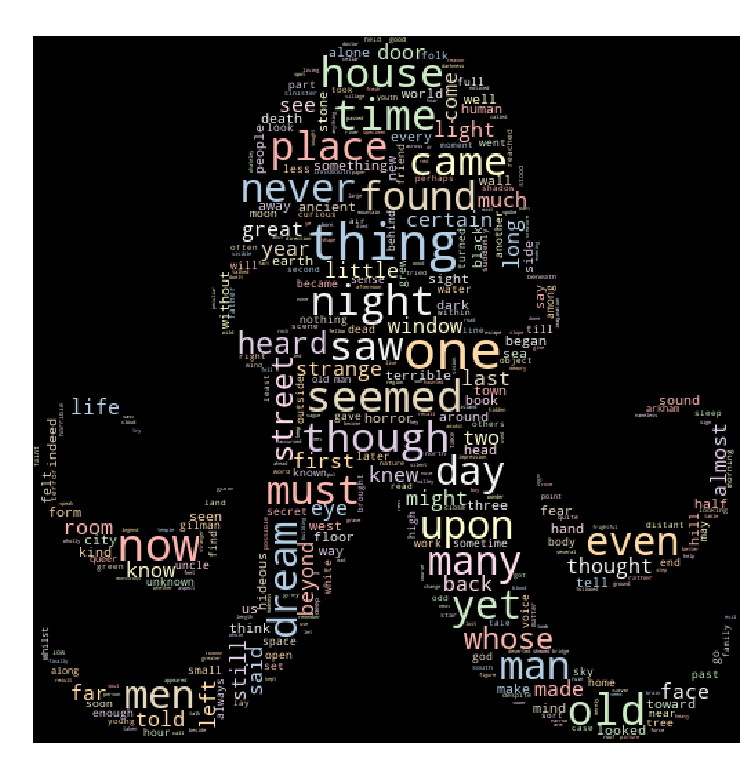

In [732]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=1000, 
               mask = hcmask3, stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(hpl))
plt.title("HP Lovecraft", fontsize=30, color = 'white')
plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17))
#plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 639.5, 390.5, -0.5)

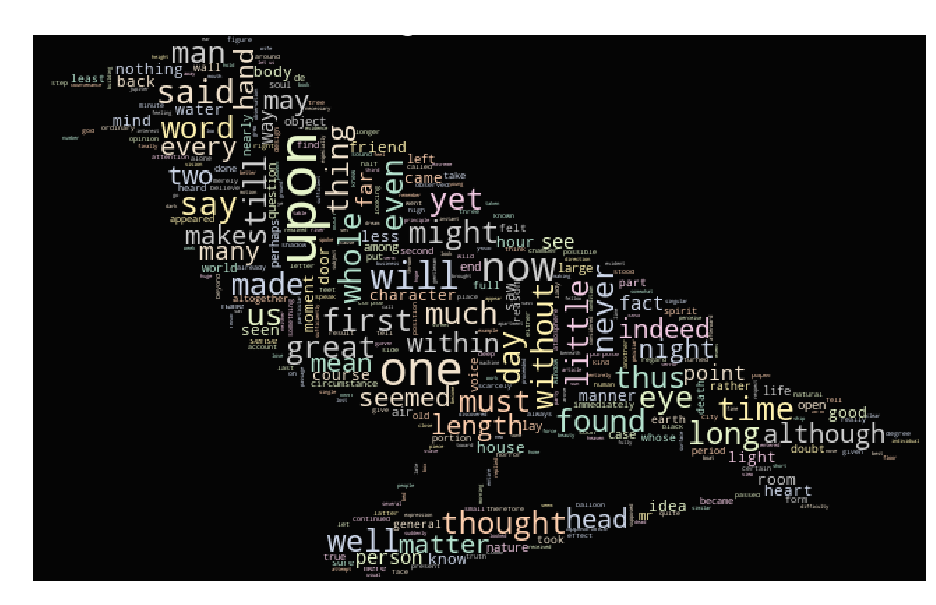

In [733]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=1000, 
               mask = hcmask, stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(eap))
plt.title("Edgar Allen Poe", fontsize=30, color = 'white')
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 639.5, 589.5, -0.5)

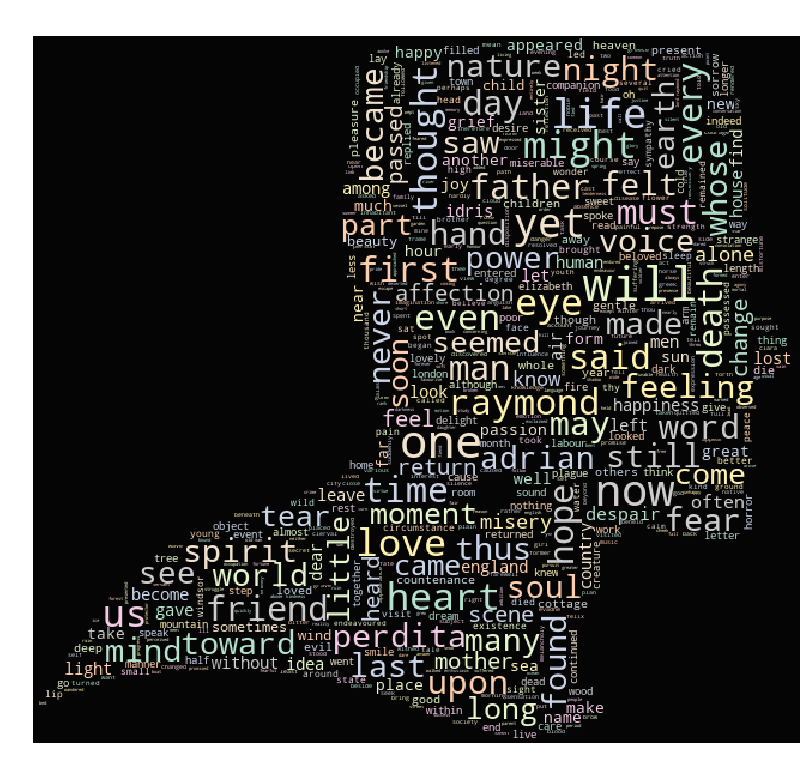

In [734]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=1000, 
               mask = hcmask2, 
               stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(mws))
plt.title("Mary Shelly", fontsize=30, color = 'white')
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

# LDA Analysis

Performed LDA to see if there were any topics that came up in text, but none were apperent

In [715]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

In [716]:
from gensim import corpora, models
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

np.random.seed(42)

In [717]:
def text_process(text):
    if pd.isnull(text):
        return []
    # tokenizing and removing punctuation
    tokenizer = RegexpTokenizer(r'\w+')
    text_processed=tokenizer.tokenize(text)
    
    # removing any stopwords
    text_processed = [word.lower() for word in text_processed if word.lower() not in stopwords.words('english')]

    #try:
    #    text_processed.remove('b')
    #except: 
    #    pass

    return text_processed ## <-- we're keeping our words distinct

In [718]:
texts = []
for i in range(len(X['processed'])):
    texts.append(text_process(X.loc[i, 'processed']))

In [719]:
dictionary = corpora.Dictionary(texts)

corpus = [dictionary.doc2bow(text) for text in texts]

ldamodel = models.ldamodel.LdaModel(corpus,                     # pass in our corpus
                                    id2word = dictionary,       # matches each word to its "number" or "spot" in the dictionary
                                    num_topics = 10,            # number of topics T to find
                                    passes = 5,                 # number of passes through corpus; similar to number of epochs
                                    minimum_probability = 0.01) # only include topics above this probability threshold

In [720]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      14.816546        1       1 -0.197286 -0.080775
0      11.522215        1       2 -0.003337  0.125422
8      11.373518        1       3  0.111724  0.214849
5      11.148340        1       4 -0.025475  0.067016
6      10.858623        1       5 -0.149317 -0.027039
9      10.198553        1       6 -0.095503  0.095245
1       8.258141        1       7  0.047410 -0.126610
2       7.700613        1       8 -0.009200 -0.094976
4       7.188538        1       9  0.157485 -0.113203
7       6.934915        1      10  0.163499 -0.059929, topic_info=     Category         Freq      Term        Total  loglift  logprob
term                                                               
260   Default   333.000000      love   333.000000  30.0000  30.0000
843   Default   234.000000   raymond   234.000000  29.0000  29.0000
63    Default   323.000000     years   323.000000  28.0000  28.0000
700   Default   338.000000    things   338.000000  27.0000  27.0000
590   Default   265.000000     three   265.000000  26.0000  26.0000
2405  Default   144.000000        de   144.000000  25.0000  25.0000
1055  Default   320.000000     thing   320.000000  24.0000  24.0000
428   Default   637.000000      said   637.000000  23.0000  23.0000
1096  Default   275.000000      door   275.000000  22.0000  22.0000
1339  Default   209.000000    father   209.000000  21.0000  21.0000
195   Default   552.000000      life   552.000000  20.0000  20.0000
168   Default   631.000000       yet   631.000000  19.0000  19.0000
784   Default   412.000000       two   412.000000  18.0000  18.0000
167   Default  1111.000000     would  1111.000000  17.0000  17.0000
142   Default   460.000000      eyes   460.000000  16.0000  16.0000
472   Default   563.000000       old   563.000000  15.0000  15.0000
119   Default   261.000000       let   261.000000  14.0000  14.0000
433   Default   540.000000        us   540.000000  13.0000  13.0000
444   Default  1309.000000      upon  1309.000000  12.0000  12.0000
228   Default   575.000000      must   575.000000  11.0000  11.0000
1136  Default   209.000000        mr   209.000000  10.0000  10.0000
2023  Default   167.000000    object   167.000000   9.0000   9.0000
1226  Default   145.000000   perdita   145.000000   8.0000   8.0000
2382  Default   175.000000        go   175.000000   7.0000   7.0000
1350  Default   170.000000      open   170.000000   6.0000   6.0000
965   Default   145.000000    people   145.000000   5.0000   5.0000
747   Default   140.000000        oh   140.000000   4.0000   4.0000
157   Default   390.000000       say   390.000000   3.0000   3.0000
393   Default   237.000000       sea   237.000000   2.0000   2.0000
917   Default   172.000000      feet   172.000000   1.0000   1.0000
...       ...          ...       ...          ...      ...      ...
2148  Topic10    29.618210     notes    30.524094   2.6385  -6.3970
2794  Topic10    26.740206     didnt    27.559830   2.6384  -6.4992
7076  Topic10    26.354923       bob    27.174593   2.6380  -6.5137
5050  Topic10    26.325975   eastern    27.145828   2.6379  -6.5148
8380  Topic10    26.274534      wait    27.094290   2.6379  -6.5168
3217  Topic10    68.300690   whether    74.274429   2.5848  -5.5615
4117  Topic10    50.054855    arkham    54.154739   2.5899  -5.8723
1014  Topic10    71.961166       got    82.168503   2.5360  -5.5093
687   Topic10    37.541550   fortune    42.813717   2.5372  -6.1599
700   Topic10   154.840012    things   338.495605   1.8865  -4.7430
1136  Topic10   105.457695        mr   209.187256   1.9837  -5.1271
3199  Topic10    39.137581    voices    49.756077   2.4286  -6.1183
801   Topic10    46.119251    island    67.772957   2.2837  -5.9542
472   Topic10   114.046524       old   563.369751   1.0713  -5.0488
206   Topic10   104.505714      like   567.135010   0.9772  -5.1362
2956  Topic10    56.287113      read   139.82